In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm
from scipy import stats
from keras.models import Sequential, Model
from keras.layers import * #Dense, Dropout, Activation, Flatten, Input,Concatenate, concatenate
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import cv2 as cv
from os import listdir
from os.path import isfile, join
from scipy import misc
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
import glob
import h5py
import scipy.misc

Using TensorFlow backend.


In [2]:
plt.ion()
plt.show()

In [4]:
%pastebin 3

'https://gist.github.com/cec1e37af9744277db1721f343ae7f1a'

In [7]:
%recall


https://github.com/forcecore/Keras-GAN-Animeface-Character

In [4]:
def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
    return arr

def make_hdf5(hdf5_name, wildcard, no_img, img_size):
    '''
    Preprocess files given by wildcard and save them in hdf5 file, as ofname.
    '''
    pool = list(glob.glob(wildcard))
    if no_img <= 0:
        fnames = pool
    else:
        fnames = []
        for i in range(no_img):
            # possible duplicate but don't care
            fnames.append(random.choice(pool))

    with h5py.File(hdf5_name, "w") as f:
        faces = f.create_dataset("anime-faces", (len(fnames), img_size, img_size, 3), dtype='f')

        for i, fname in enumerate(fnames):
#             print(fname)
            im = scipy.misc.imread(fname, mode='RGB') # some have alpha channel
            im = scipy.misc.imresize(im, (img_size, img_size))
            faces[i] = normalize(im)

In [5]:
make_hdf5("data/data.hdf5", "data/animeface-character-dataset/thumb/*/*.png", -1, 32)

In [6]:
f = h5py.File( "data/data.hdf5", 'r' )
faces = list(f.get( 'anime-faces' ))

In [7]:
len(list(faces))

14490

(32, 32, 3)


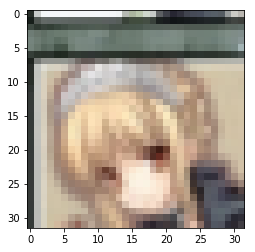

(32, 32)


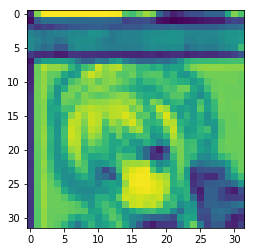

In [29]:
random_id = random.choice(range(len(list(faces))))
print(faces[random_id].shape)
plt.imshow(faces[random_id])
plt.show()
grey = color.rgb2gray(faces[random_id])
print(grey.shape)
# gray = cv.cvtColor(faces[random_id], cv.COLOR_BGR2GRAY)
plt.imshow(grey)
# plt.imshow(faces[random_id])


In [19]:

import skimage
from skimage.feature import hog
from skimage import data, color, exposure

In [35]:
grey = color.rgb2gray(faces[random_id])
fd, hog_image = hog(grey, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(1, 1), visualise=True, block_norm='L2-Hys')

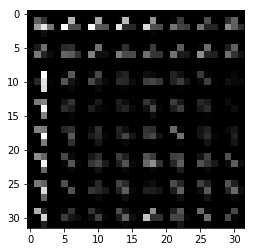

In [36]:
plt.imshow(hog_image, cmap=plt.cm.gray)

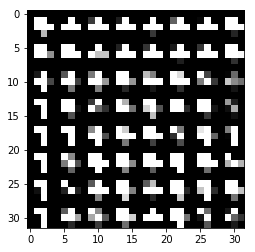

In [37]:
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)

In [48]:
def getInputImages(ids):
    data = [faces[i] for i in  ids]
    data = np.stack(data)
    return data

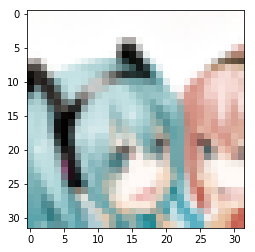

In [49]:
plt.imshow(getInputImages([1])[0])

In [50]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = [] #
        self.fig = plt.figure()
        self.logs = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):     
        self.i += 1

        if self.i% 1 != 0:
            return
        
        self.losses.append(logs.get('loss'))

        self.acc.append(logs.get('acc'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        self.plotLosses(None)
        

        

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.acc, label="accuracy")

        plt.legend()
        
        
myPlot = PlotLosses()
myPlot.initVars()

## GAN

In [60]:
img_size = 32
img_rows = img_size
img_cols = img_size
channels = 3
img_shape = (img_rows, img_cols, channels)
epochs = 100
batch_size = 20
save_interval= 10
half_batch = int(batch_size / 2)



In [70]:
def build_generator():

    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    depth = 128
    dim = 8

    x = Dense(dim * dim *depth, activation='tanh', input_shape=noise_shape)(noise)
    x = BatchNormalization(momentum=0.9)(x)

    x = Reshape((dim, dim, depth))(x)
    
    x = UpSampling2D((2,2))(x)
    x = Convolution2D(int(depth/2), 5, padding='same', activation='tanh')(x)
    
    x = UpSampling2D((2,2))(x)
    x = Convolution2D(3, 5, padding='same', activation='tanh')(x)
    

    model = Model(noise, x)


    model.compile(optimizer=RMSprop(lr=0.0002, decay=6e-8), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return Model(noise, x)

generator = build_generator()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8192)              32768     
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)        204864    
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 32, 32, 64)        0         
__________

In [71]:

def build_discriminator():
    img_shape = (img_rows, img_cols, channels)
    input_img = Input(shape=img_shape)
    depth = 64
    x = Convolution2D(depth, (5, 5), activation='relu', padding='same', input_shape=img_shape)(input_img)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
#     x = LeakyReLU(0.2) (x)
#     x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *2 , (4, 4), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
#     x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *4, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)
    
#     x = Convolution2D(depth *8, (3, 3),  activation='relu', padding='same')(x)
#     x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
#     x = LeakyReLU(0.2) (x)
#     x = Dropout(0.6)(x)
    
    
#     x = Convolution2D(depth *12, (3, 3),  activation='relu', padding='same')(x)
#     x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
#     x = LeakyReLU(0.2) (x)
#     x = Dropout(0.6)(x)

#     x = Convolution2D(16, (3, 3),  activation='relu', padding='same')(x)
#     x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
#     x = Dropout(0.6)(x)
#     x= AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten(input_shape=img_shape)(x)
#     x = Dense(512)(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(input_img, x)

    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
#categorical_accuracy
#     model.compile(optimizer=RMSprop(lr=0.0001, decay=3e-8), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    

    model.summary()
    return model

discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 256)         295168    
__________

In [43]:
def save_imgs(epoch):

    noise = np.random.normal(0, 1, (2, 100))
    gen_imgs = generator.predict(noise)
    fig = plt.figure(figsize =(8,12))
    plt.subplot(1,2,1)
    plt.imshow(gen_imgs[0])
    plt.subplot(1,2,2)
#     gen_imgs[1] = 0.5 * gen_imgs[1] + 0.5
    plt.imshow(gen_imgs[1])
    plt.show()
    # Rescale images 0 - 1
#     gen_imgs = 0.5 * gen_imgs + 0.5
#     fig = plt.figure(figsize =())
#     fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#         for j in range(c):
#             axs[i,j].imshow(gen_imgs[cnt, :,:,0])
#             axs[i,j].axis('off')
#             cnt += 1
#     plt.show()
#     fig.savefig("gan/images/mnist_%d.png" % epoch)
#     plt.close()


In [56]:
to_categorical(np.ones((2, 1)))

array([[ 0.,  1.],
       [ 0.,  1.]])

## Test discriminator

In [57]:
def getData(size):
    idx = list(np.random.randint(0, len(faces), size))

    imgs = getInputImages(idx)
    noise = np.random.normal(0, 1, (size, 100))
    gen_imgs = generator.predict(noise)
    d_input = np.append(imgs, gen_imgs, axis=0)

    d_output = np.append(np.ones((size, 1), dtype=np.int), np.zeros((size, 1)), axis=0)

    return d_input, d_output
    

In [58]:
getData(2)
1

1

In [1]:
# half_batch = 2
# for epoch in range(100):

#     d_input, d_output = getData(half_batch)
#     discriminator.fit(d_input, d_output, epochs = 1)
#     pred1 = discriminator.predict(d_input)

    
#     t_input, t_output = getData(2)

#     pred = (discriminator.predict(t_input) > 0.5).astype(int)

#     print('accuracy_score : ' , accuracy_score(pred, t_output))


<IPython.core.display.Javascript object>


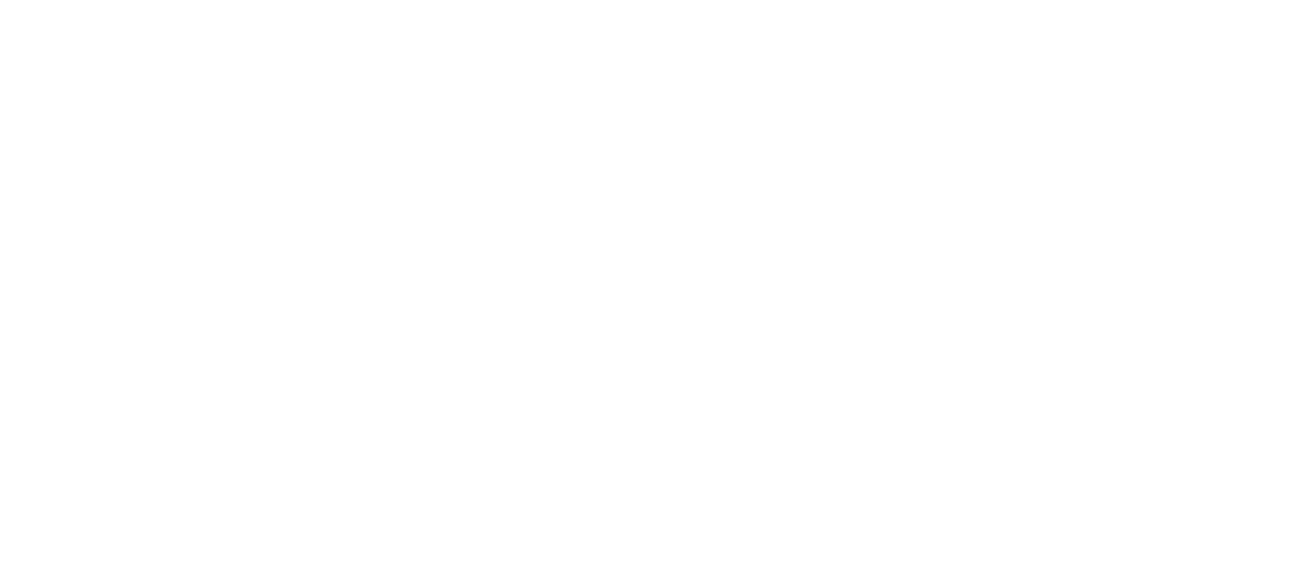

<IPython.core.display.Javascript object>


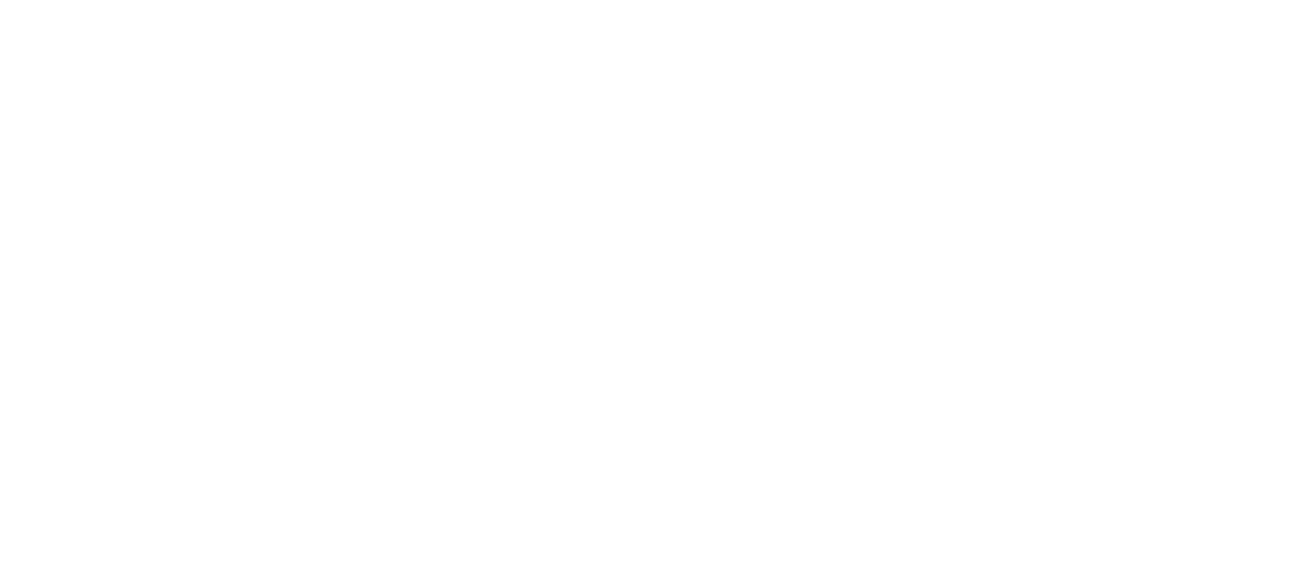

In [64]:
%matplotlib notebook
accuracyFig = plt.figure(figsize=(9,4))
accuracyFig.clf()

g_loss :  0.737463


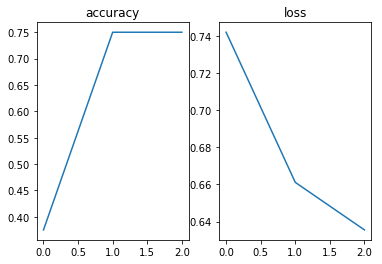

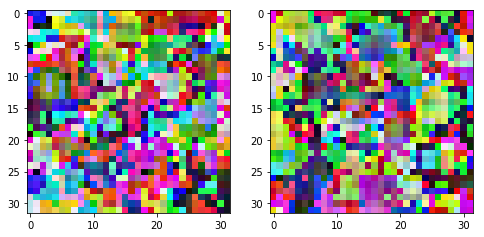

g_loss :  1.1472
g_loss :  1.6432
g_loss :  3.39801
g_loss :  4.59717
g_loss :  7.28772
g_loss :  6.35677
g_loss :  10.1418
g_loss :  11.1645
g_loss :  11.469
g_loss :  7.62136


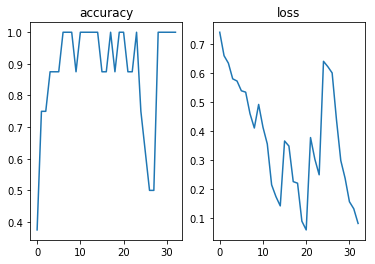

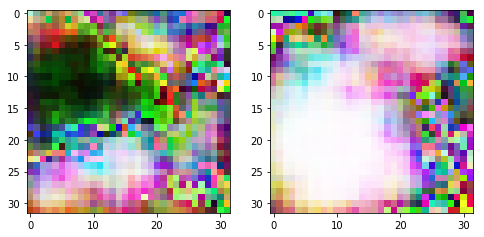

g_loss :  10.599
g_loss :  8.13655
g_loss :  8.83908
g_loss :  10.1609
g_loss :  13.0811
g_loss :  10.1843
g_loss :  10.6597
g_loss :  14.1419
g_loss :  11.6052
g_loss :  10.8954


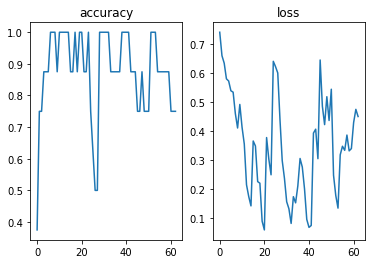

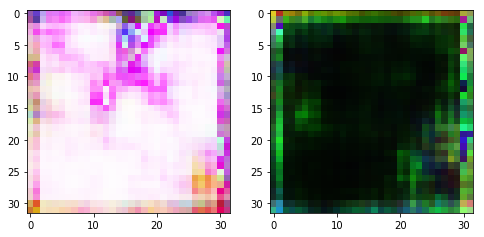

g_loss :  9.67292
g_loss :  9.31793
g_loss :  11.2452
g_loss :  11.4441
g_loss :  12.1459
g_loss :  14.1011
g_loss :  12.3533
g_loss :  9.82596
g_loss :  11.0326
g_loss :  11.017


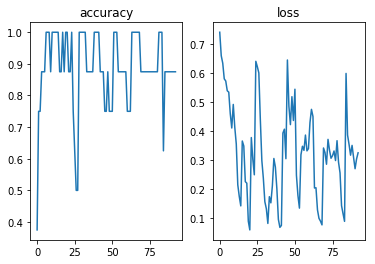

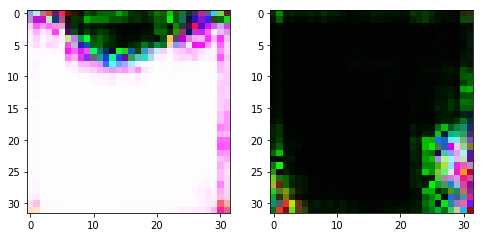

g_loss :  12.6035
g_loss :  7.8143
g_loss :  10.5809
g_loss :  12.2091
g_loss :  12.1913
g_loss :  12.1492
g_loss :  12.2092
g_loss :  10.1734
g_loss :  14.0372
g_loss :  10.2342


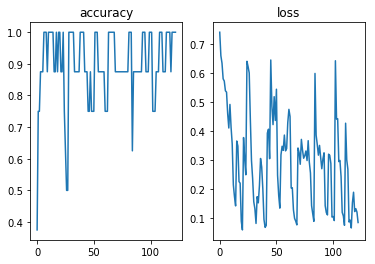

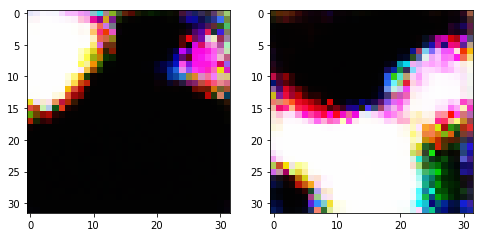

g_loss :  12.3219
g_loss :  10.0612
g_loss :  10.2941
g_loss :  13.072
g_loss :  12.2711
g_loss :  13.6365
g_loss :  11.5427
g_loss :  12.4
g_loss :  12.6809
g_loss :  14.317


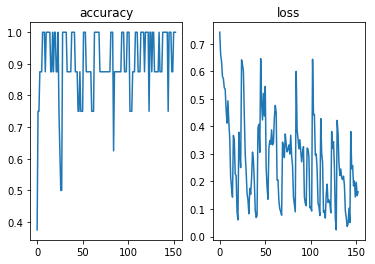

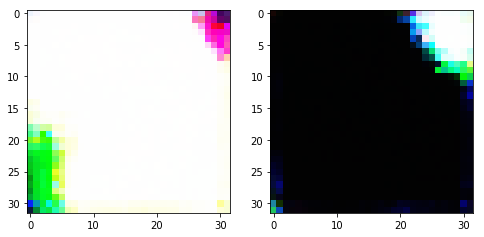

g_loss :  12.8301
g_loss :  11.8196
g_loss :  12.3541
g_loss :  10.8582
g_loss :  13.0249
g_loss :  13.5054
g_loss :  12.4669
g_loss :  14.235
g_loss :  9.03134
g_loss :  14.2749


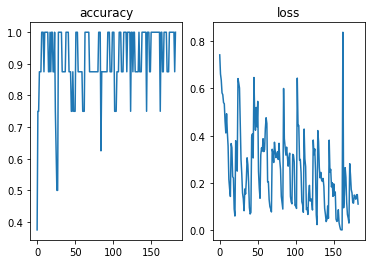

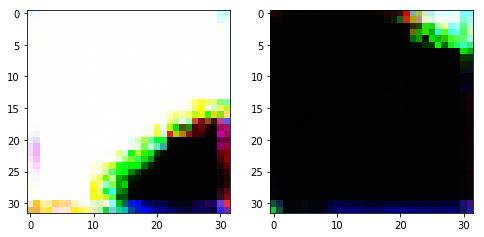

g_loss :  12.3109
g_loss :  12.1834
g_loss :  10.9227
g_loss :  13.5517
g_loss :  11.8683
g_loss :  10.3697
g_loss :  12.1721
g_loss :  10.6057
g_loss :  13.8938
g_loss :  11.1186


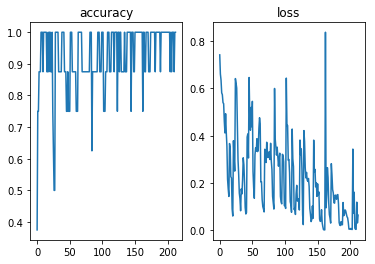

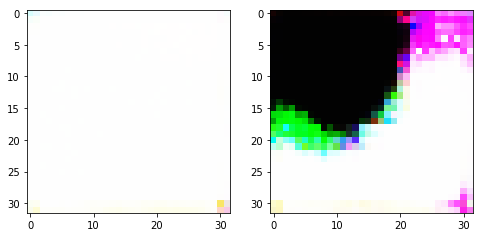

g_loss :  11.8991
g_loss :  13.5691
g_loss :  13.3508
g_loss :  14.426
g_loss :  13.761
g_loss :  10.8098
g_loss :  13.0459
g_loss :  12.177
g_loss :  14.9161
g_loss :  11.5584


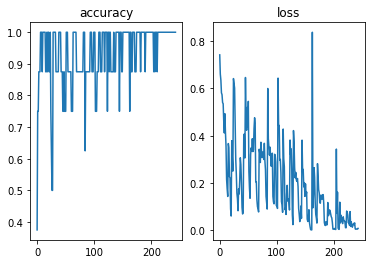

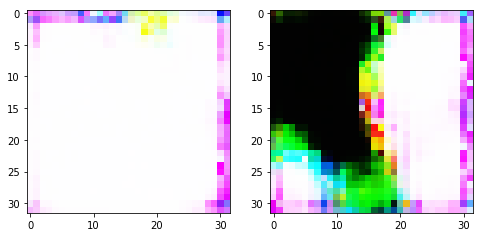

g_loss :  12.9963
g_loss :  14.5114
g_loss :  16.1181
g_loss :  11.044
g_loss :  10.4871
g_loss :  11.2807
g_loss :  13.9144
g_loss :  14.1629
g_loss :  9.51479
g_loss :  12.7327


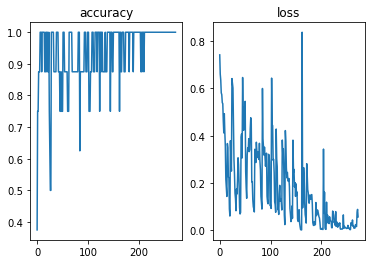

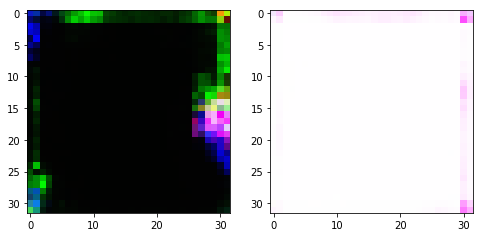

g_loss :  12.0181
g_loss :  12.2329
g_loss :  9.49917
g_loss :  14.6315
g_loss :  13.0875
g_loss :  11.4047
g_loss :  15.1404
g_loss :  14.2712
g_loss :  13.0812
g_loss :  14.6567


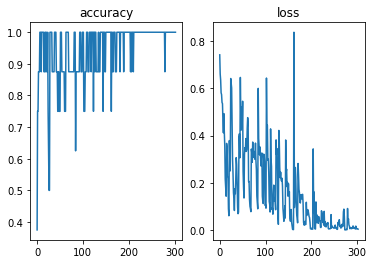

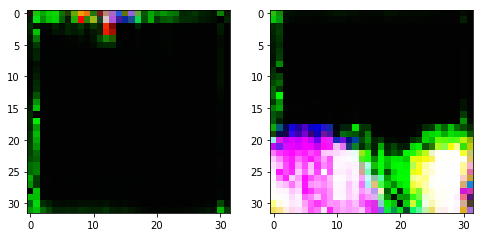

g_loss :  12.8275
g_loss :  13.1829
g_loss :  10.2953
g_loss :  11.7038
g_loss :  14.3355
g_loss :  14.4803
g_loss :  14.6765
g_loss :  12.9936
g_loss :  13.2503
g_loss :  11.7588


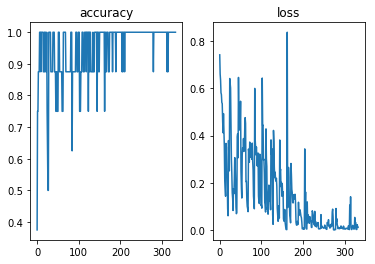

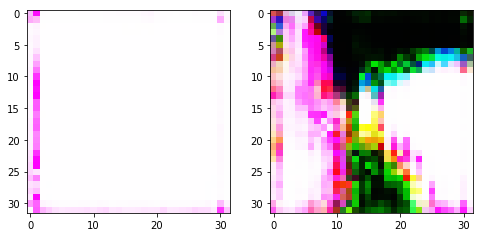

g_loss :  14.5657
g_loss :  12.4824
g_loss :  12.8436
g_loss :  12.5135
g_loss :  12.4579
g_loss :  11.4765
g_loss :  10.0991
g_loss :  12.2254
g_loss :  12.7817
g_loss :  14.1794


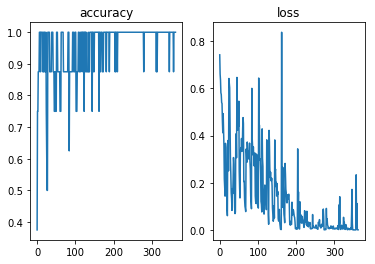

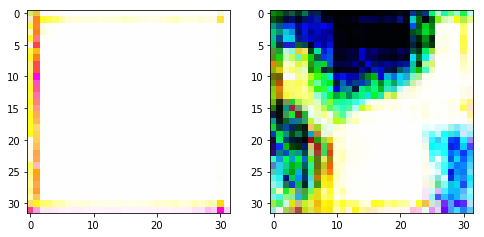

g_loss :  12.7561
g_loss :  14.1182
g_loss :  13.9836
g_loss :  14.3907
g_loss :  10.3409
g_loss :  14.5808
g_loss :  13.8311
g_loss :  13.0264
g_loss :  12.9233
g_loss :  14.0406


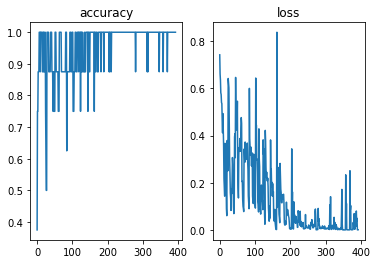

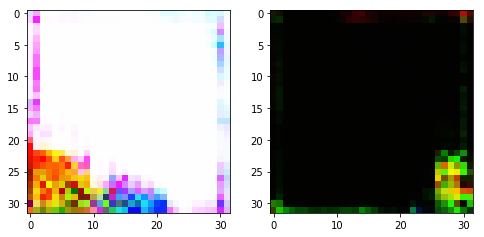

g_loss :  14.5127
g_loss :  12.8947
g_loss :  11.5523
g_loss :  12.799
g_loss :  13.0271
g_loss :  12.1521
g_loss :  12.4298
g_loss :  10.1511
g_loss :  12.8099
g_loss :  12.8272


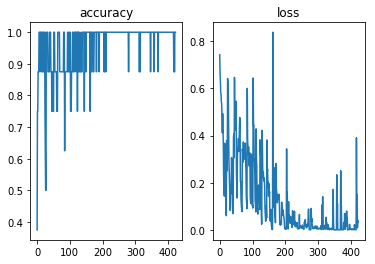

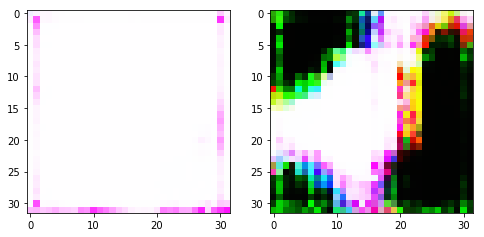

g_loss :  11.9806
g_loss :  14.6004
g_loss :  14.564
g_loss :  14.3349
g_loss :  15.6683
g_loss :  14.6931
g_loss :  14.8893
g_loss :  16.1181
g_loss :  14.6738
g_loss :  11.8773


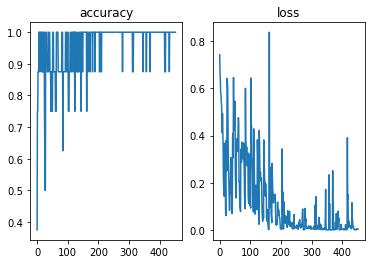

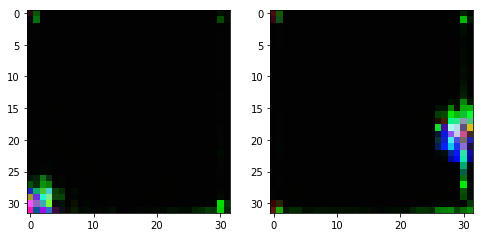

g_loss :  14.7026
g_loss :  12.9261
g_loss :  13.2328
g_loss :  12.773
g_loss :  11.7194
g_loss :  15.3275
g_loss :  14.5334
g_loss :  16.1181
g_loss :  13.4199
g_loss :  13.5834


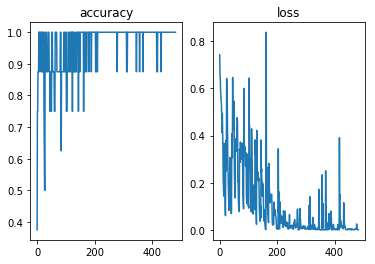

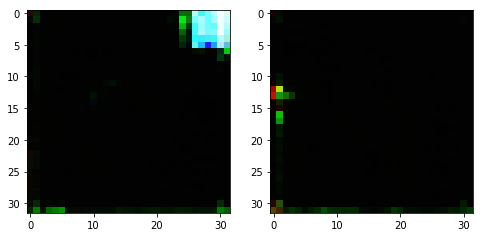

g_loss :  13.5646
g_loss :  14.6481
g_loss :  14.7513
g_loss :  13.5077
g_loss :  11.565
g_loss :  13.179
g_loss :  13.75
g_loss :  14.7268
g_loss :  10.9841
g_loss :  13.0797


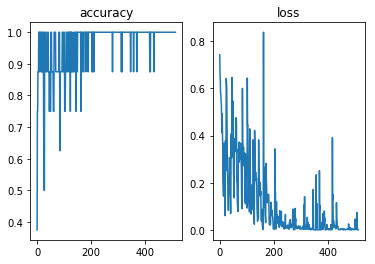

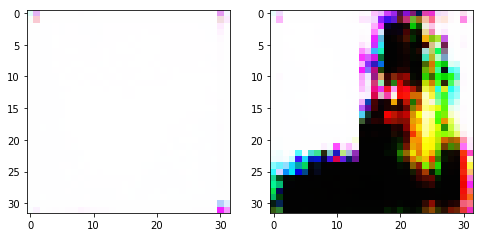

g_loss :  11.802
g_loss :  14.7533
g_loss :  12.9858
g_loss :  16.1181
g_loss :  12.4136
g_loss :  16.1181
g_loss :  11.7202
g_loss :  12.1085
g_loss :  12.1487
g_loss :  12.2469


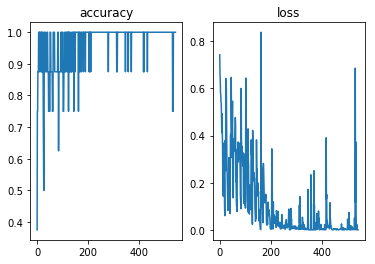

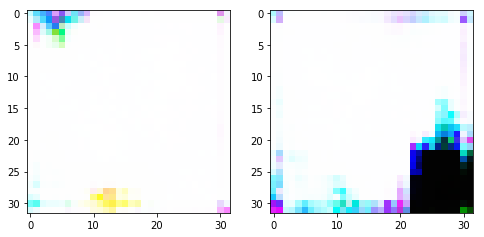

g_loss :  13.0756
g_loss :  14.0894
g_loss :  10.6728
g_loss :  11.1861
g_loss :  15.219
g_loss :  11.0527
g_loss :  11.4864
g_loss :  14.0012
g_loss :  13.0765
g_loss :  12.5421


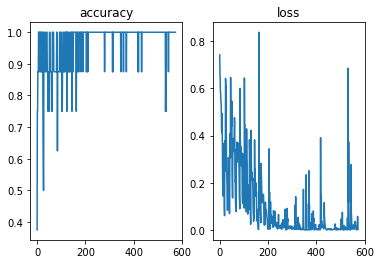

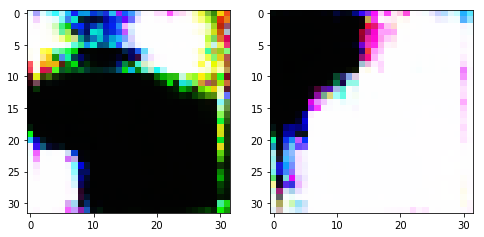

g_loss :  13.0073
g_loss :  11.5536
g_loss :  11.7227
g_loss :  12.9753
g_loss :  14.5389
g_loss :  12.2198
g_loss :  12.0407
g_loss :  14.3792
g_loss :  14.3545
g_loss :  13.431


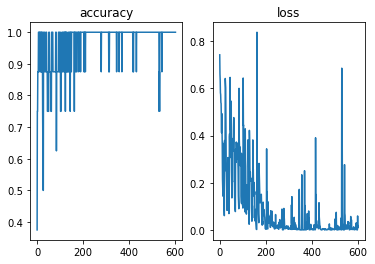

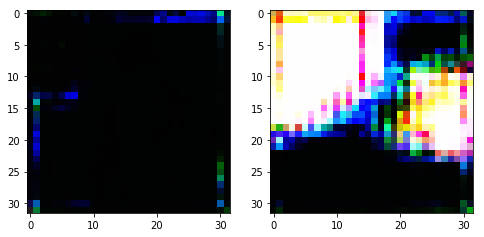

g_loss :  13.3415
g_loss :  12.3667
g_loss :  14.0613
g_loss :  11.7195
g_loss :  14.183
g_loss :  12.1432
g_loss :  12.7871
g_loss :  11.6721
g_loss :  14.6464
g_loss :  14.2366


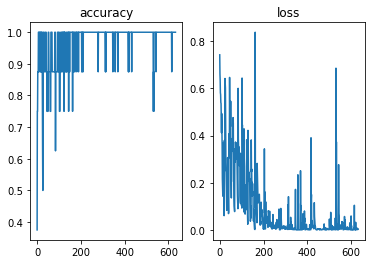

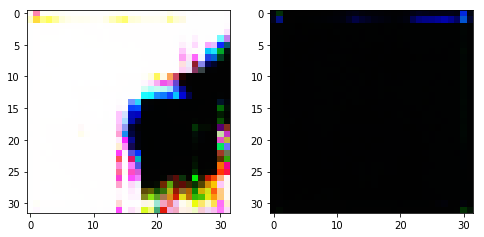

g_loss :  14.5302
g_loss :  13.3469
g_loss :  13.5869
g_loss :  14.3185
g_loss :  14.5705
g_loss :  13.2083
g_loss :  13.2832
g_loss :  11.9222
g_loss :  14.9678
g_loss :  13.5565


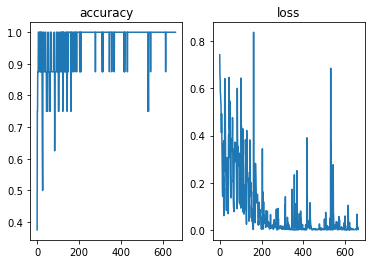

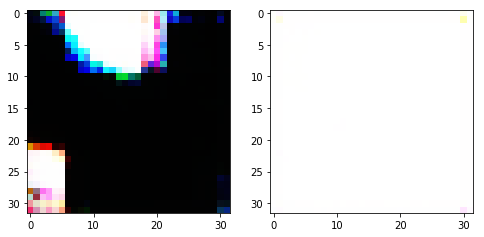

g_loss :  9.70379
g_loss :  12.555
g_loss :  13.0586
g_loss :  12.416
g_loss :  12.1891
g_loss :  8.17417
g_loss :  13.9366
g_loss :  13.3341
g_loss :  12.2363
g_loss :  11.2435


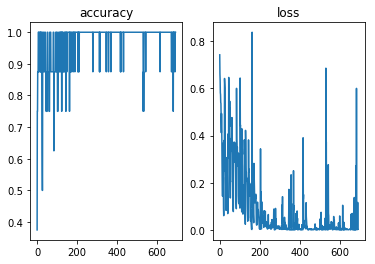

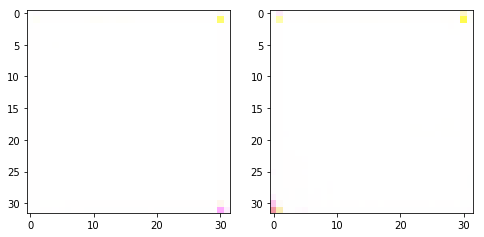

g_loss :  12.748
g_loss :  12.4893
g_loss :  15.0336
g_loss :  11.3794
g_loss :  11.5306
g_loss :  14.5553
g_loss :  14.5977
g_loss :  11.6949
g_loss :  13.0651
g_loss :  14.1766


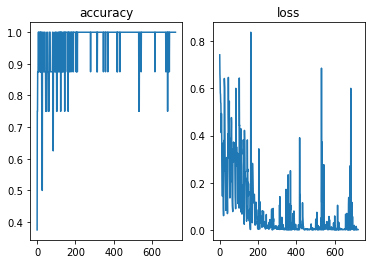

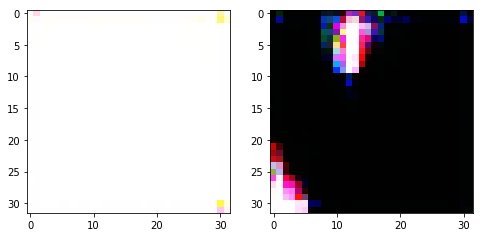

g_loss :  13.2312
g_loss :  14.031
g_loss :  14.7624
g_loss :  14.7765
g_loss :  14.3867
g_loss :  12.6895
g_loss :  13.2289
g_loss :  13.5409
g_loss :  12.5813
g_loss :  13.1084


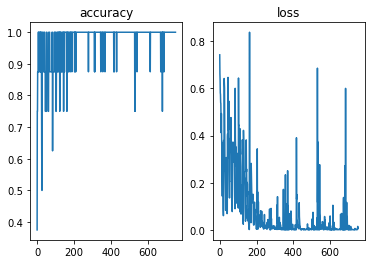

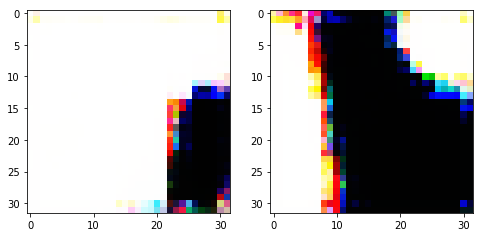

g_loss :  13.3252
g_loss :  13.2227
g_loss :  11.7028
g_loss :  11.8338
g_loss :  13.2608
g_loss :  14.5712
g_loss :  14.3929
g_loss :  11.9041
g_loss :  12.3424
g_loss :  14.1105


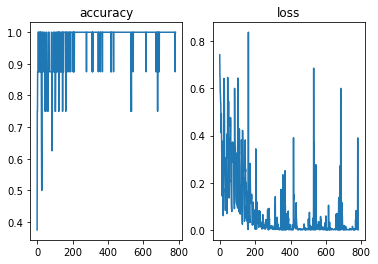

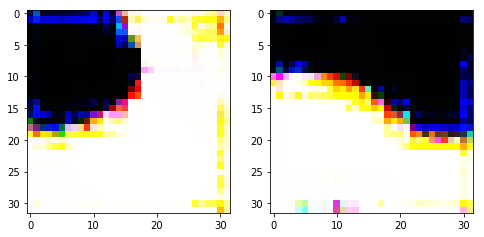

g_loss :  13.5715
g_loss :  11.9961
g_loss :  14.4474
g_loss :  12.8015
g_loss :  14.3777
g_loss :  11.6489
g_loss :  12.6411
g_loss :  13.3318
g_loss :  13.3524
g_loss :  14.8345


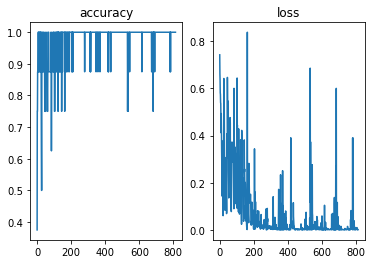

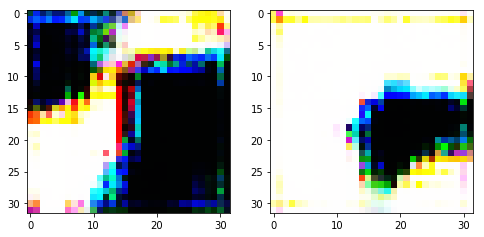

g_loss :  13.2308
g_loss :  10.8402
g_loss :  11.7846
g_loss :  11.0904
g_loss :  10.2742
g_loss :  13.7581
g_loss :  12.5225
g_loss :  10.2902
g_loss :  13.3744
g_loss :  14.7303


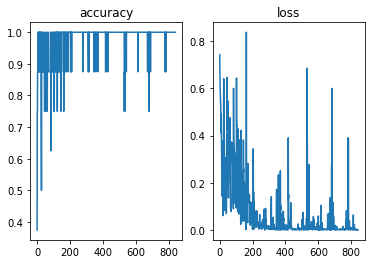

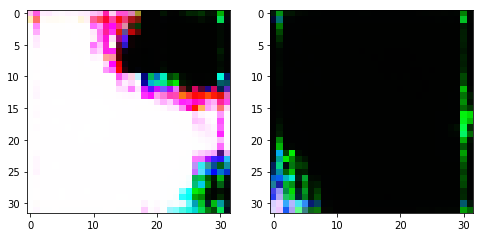

g_loss :  8.20913
g_loss :  11.8736
g_loss :  14.4105
g_loss :  11.7697
g_loss :  14.5166
g_loss :  12.917
g_loss :  11.3819
g_loss :  13.1798
g_loss :  14.6507
g_loss :  11.4071


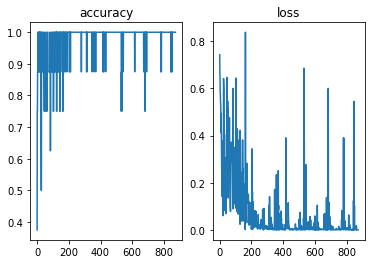

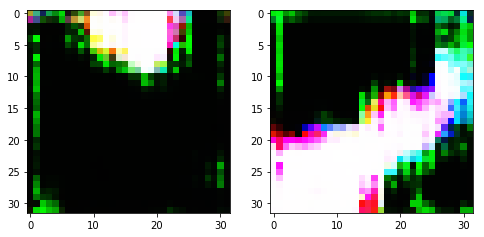

g_loss :  15.891
g_loss :  13.4373
g_loss :  14.8486
g_loss :  13.6458
g_loss :  14.1878
g_loss :  14.8475
g_loss :  14.1919
g_loss :  13.5591
g_loss :  11.2497
g_loss :  12.155


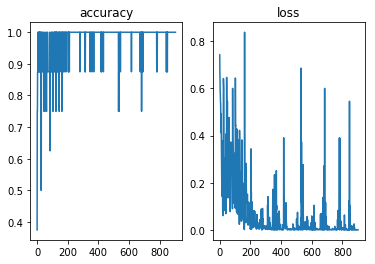

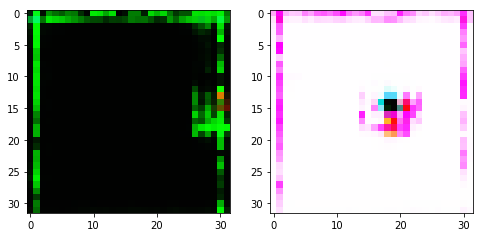

g_loss :  14.9291
g_loss :  12.3457
g_loss :  14.7521
g_loss :  15.8828
g_loss :  11.9662
g_loss :  11.961
g_loss :  14.6255
g_loss :  12.0897
g_loss :  14.7183
g_loss :  14.0196


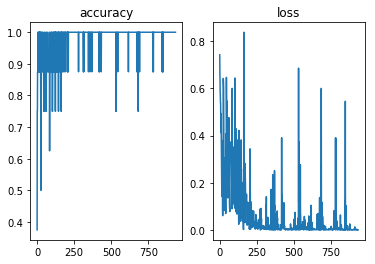

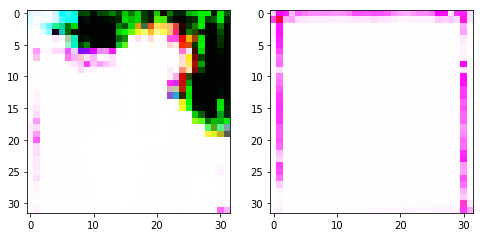

g_loss :  13.5363
g_loss :  11.3211
g_loss :  9.58423
g_loss :  14.6628
g_loss :  14.7296
g_loss :  14.1442
g_loss :  12.1898
g_loss :  15.0903
g_loss :  12.9217
g_loss :  13.3979


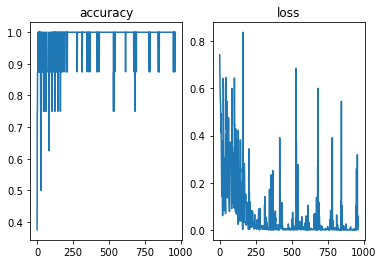

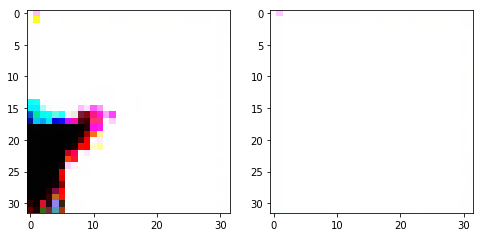

g_loss :  11.7962
g_loss :  14.5794
g_loss :  13.0902
g_loss :  13.5414
g_loss :  12.3238
g_loss :  12.4559
g_loss :  13.4444
g_loss :  13.6226
g_loss :  13.5752
g_loss :  11.7697


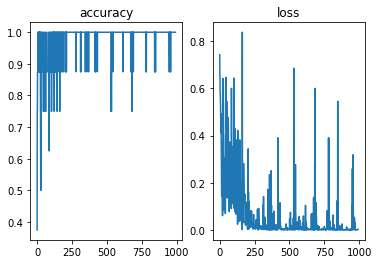

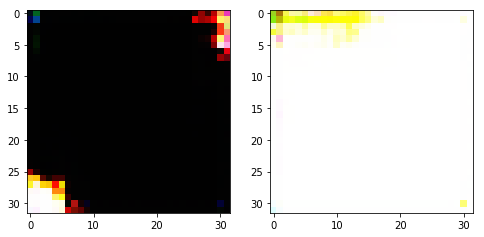

g_loss :  13.1603
g_loss :  13.0242
g_loss :  12.3472
g_loss :  13.7872
g_loss :  14.9508
g_loss :  14.9087
g_loss :  12.7427
g_loss :  10.6446
g_loss :  13.203
g_loss :  11.8383


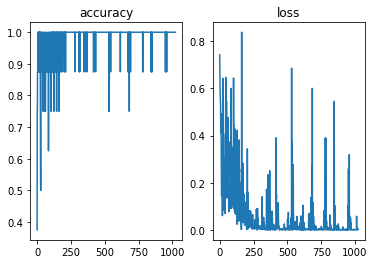

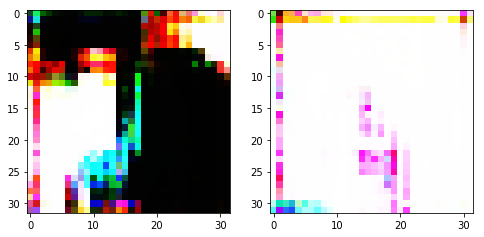

g_loss :  13.3763
g_loss :  13.701
g_loss :  12.9147
g_loss :  16.018
g_loss :  11.3277
g_loss :  12.0338
g_loss :  12.7634
g_loss :  13.3379
g_loss :  13.469
g_loss :  12.0877


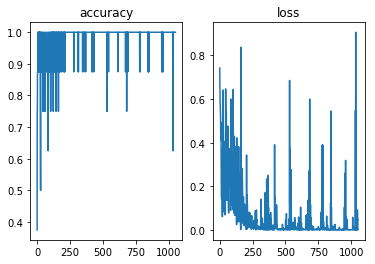

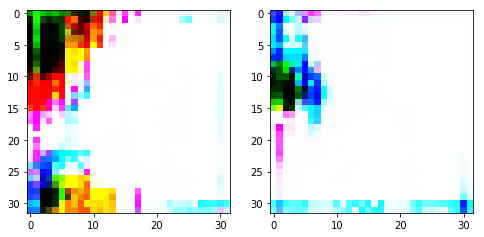

g_loss :  13.4412
g_loss :  14.7145
g_loss :  13.4882
g_loss :  14.8091
g_loss :  12.3963
g_loss :  13.9704
g_loss :  12.8398
g_loss :  14.9205
g_loss :  14.6305
g_loss :  14.8285


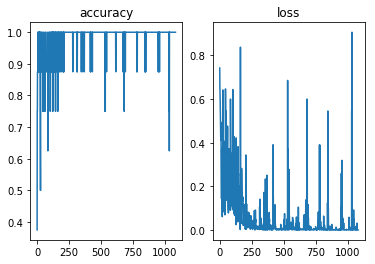

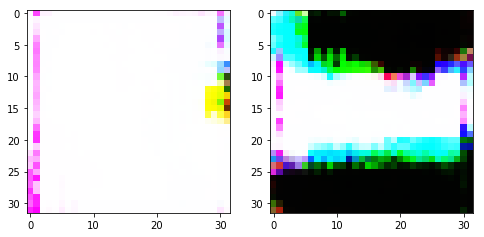

g_loss :  13.5748
g_loss :  13.6048
g_loss :  12.5763
g_loss :  12.2137
g_loss :  13.5079
g_loss :  13.5674
g_loss :  12.3904
g_loss :  12.2336
g_loss :  13.6187
g_loss :  12.9246


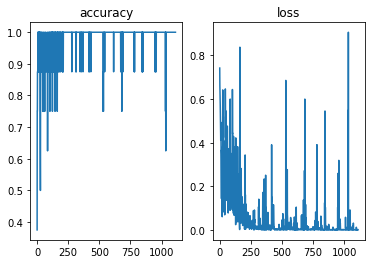

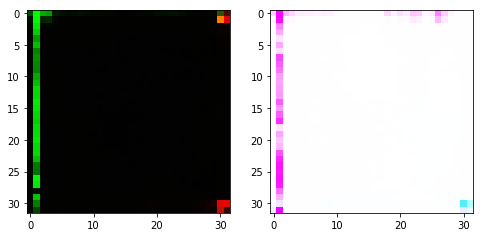

g_loss :  12.0798
g_loss :  14.855
g_loss :  14.1772
g_loss :  11.0512
g_loss :  13.7253
g_loss :  13.966
g_loss :  14.7889
g_loss :  14.7562
g_loss :  12.2258
g_loss :  12.2981


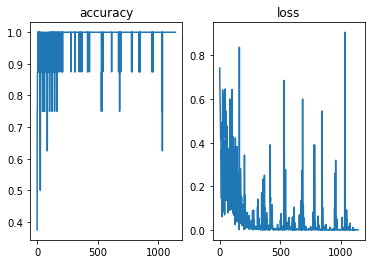

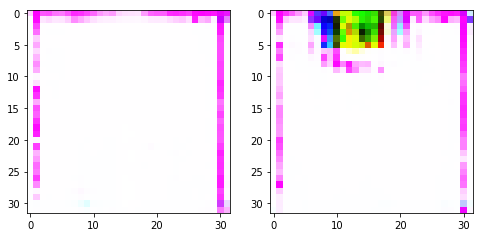

g_loss :  11.1427
g_loss :  13.7469
g_loss :  13.623
g_loss :  12.5006
g_loss :  12.7556
g_loss :  13.7437
g_loss :  14.8545
g_loss :  12.4213
g_loss :  13.669
g_loss :  12.1158


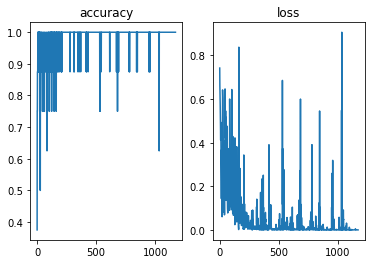

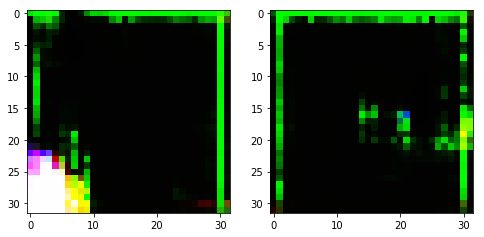

g_loss :  13.5067
g_loss :  12.2623
g_loss :  13.9117
g_loss :  13.8207
g_loss :  15.1185
g_loss :  12.8298
g_loss :  11.9205
g_loss :  11.8487
g_loss :  14.1488
g_loss :  12.8438


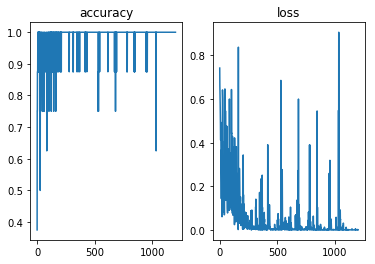

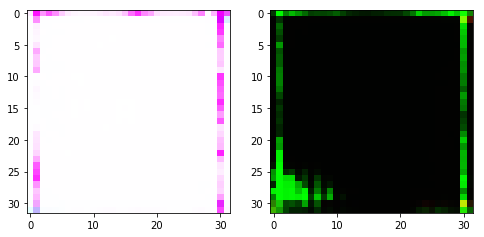

g_loss :  12.8081
g_loss :  12.8239
g_loss :  13.8195
g_loss :  11.9902
g_loss :  14.1707
g_loss :  10.6339
g_loss :  14.1137
g_loss :  13.9693
g_loss :  11.8099
g_loss :  14.0881


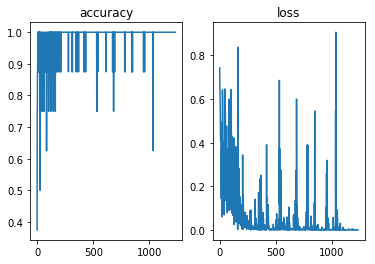

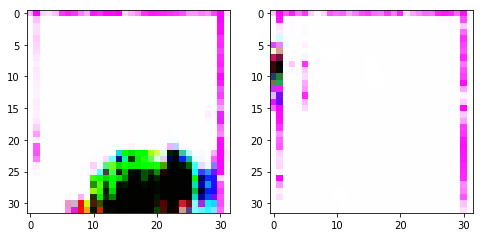

g_loss :  12.4206
g_loss :  14.0639
g_loss :  15.0337
g_loss :  12.8194
g_loss :  13.004
g_loss :  12.7982
g_loss :  13.3728
g_loss :  12.9715
g_loss :  13.5661
g_loss :  13.7755


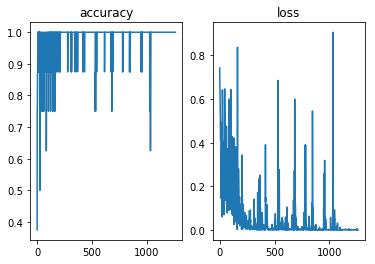

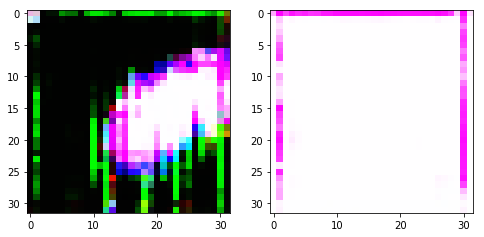

g_loss :  14.7419
g_loss :  15.4002
g_loss :  12.9848
g_loss :  13.1833
g_loss :  12.2906
g_loss :  13.713
g_loss :  12.5592
g_loss :  14.8722
g_loss :  13.4825
g_loss :  12.3527


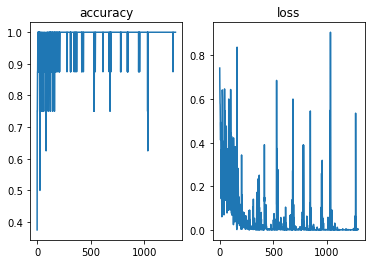

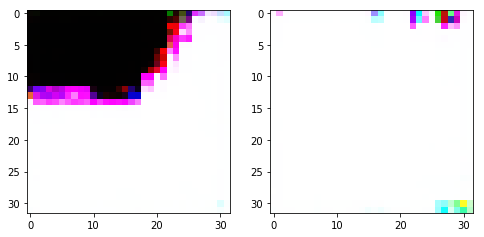

g_loss :  12.4404
g_loss :  15.873
g_loss :  13.706
g_loss :  12.4752
g_loss :  13.776
g_loss :  13.6832
g_loss :  12.4993
g_loss :  13.7871
g_loss :  12.5915
g_loss :  12.4925


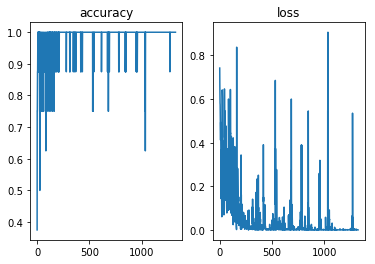

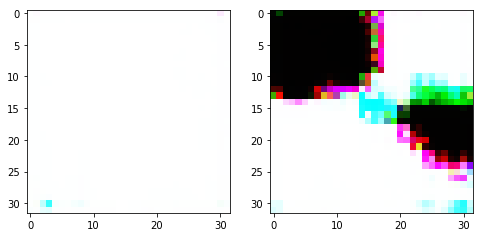

g_loss :  13.7993
g_loss :  13.7739
g_loss :  11.5969
g_loss :  12.5222
g_loss :  10.2252
g_loss :  12.4297
g_loss :  10.3654
g_loss :  13.6988
g_loss :  14.9711
g_loss :  12.4022


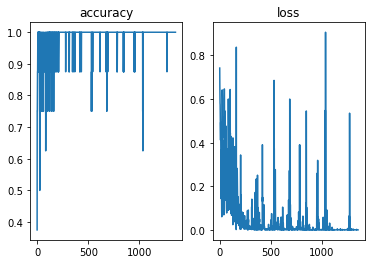

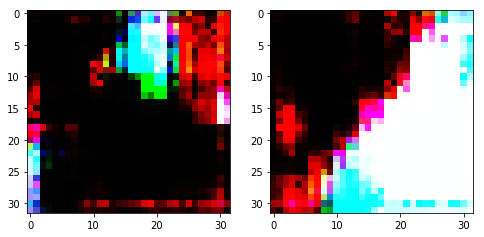

g_loss :  14.4627
g_loss :  12.9635
g_loss :  13.632
g_loss :  12.5017
g_loss :  13.3203
g_loss :  15.0958
g_loss :  12.4144
g_loss :  13.6119
g_loss :  12.3913
g_loss :  12.3691


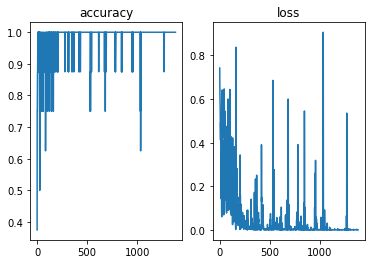

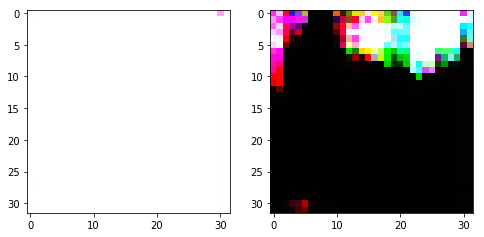

g_loss :  13.7093
g_loss :  13.8806
g_loss :  13.8697
g_loss :  11.2427
g_loss :  12.6943
g_loss :  12.5158
g_loss :  12.4694
g_loss :  14.9477
g_loss :  13.6897
g_loss :  12.4315


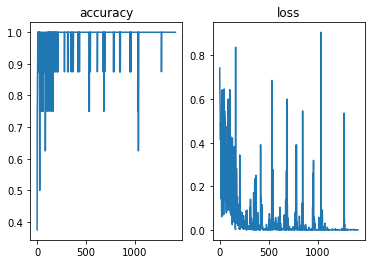

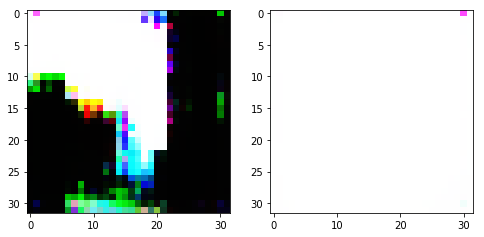

g_loss :  12.5506
g_loss :  13.2749
g_loss :  13.6628
g_loss :  10.9901
g_loss :  13.6238
g_loss :  12.6456
g_loss :  12.5207
g_loss :  12.9391
g_loss :  14.9466
g_loss :  13.5817


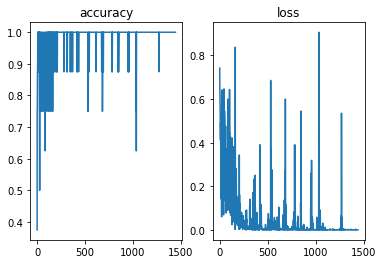

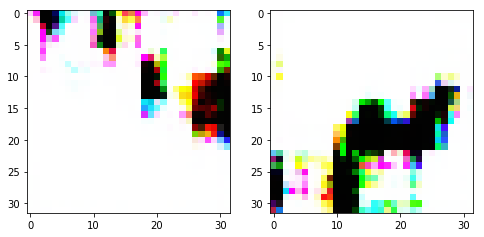

g_loss :  13.6432
g_loss :  12.4565
g_loss :  13.5566
g_loss :  13.6886
g_loss :  13.0865
g_loss :  14.9889
g_loss :  13.5412
g_loss :  14.1237
g_loss :  12.811
g_loss :  13.5722


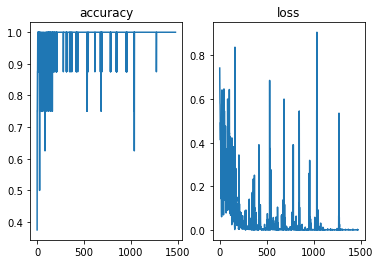

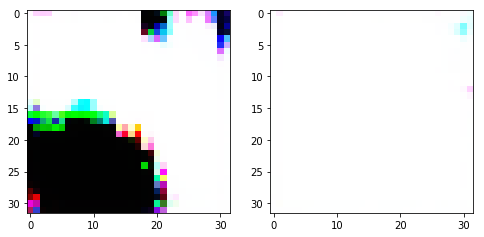

g_loss :  11.5956
g_loss :  12.6256
g_loss :  11.5632
g_loss :  12.8366
g_loss :  12.624
g_loss :  14.3528
g_loss :  12.6684
g_loss :  13.8076
g_loss :  13.9039
g_loss :  12.5776


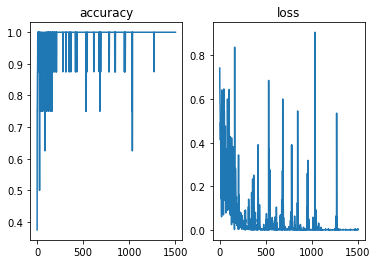

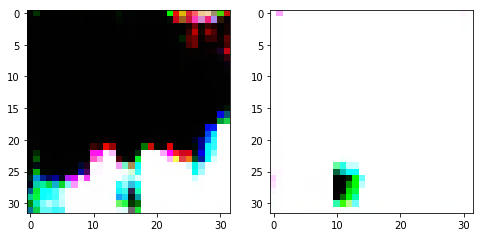

g_loss :  14.925
g_loss :  15.0383
g_loss :  14.9875
g_loss :  14.003
g_loss :  14.7529
g_loss :  15.0093
g_loss :  13.7763
g_loss :  12.7538
g_loss :  12.4836
g_loss :  13.8297


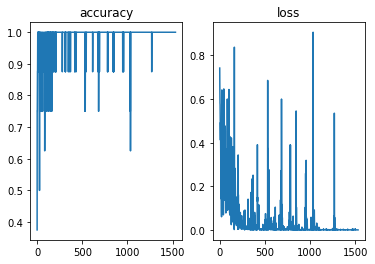

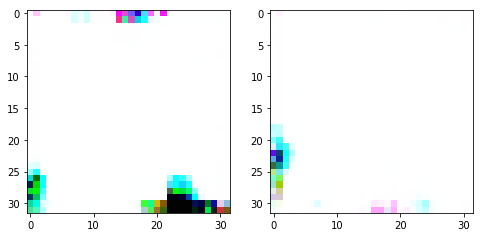

g_loss :  13.6531
g_loss :  12.6212
g_loss :  13.9987
g_loss :  13.7578
g_loss :  12.9917
g_loss :  13.9545
g_loss :  11.9086
g_loss :  12.9173
g_loss :  15.0492
g_loss :  13.9001


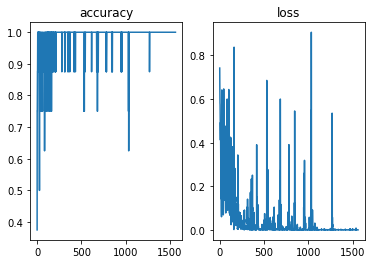

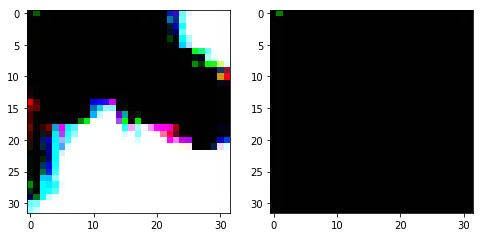

g_loss :  15.0937
g_loss :  13.9014
g_loss :  13.9959
g_loss :  13.2354
g_loss :  13.1697
g_loss :  13.9313
g_loss :  14.921
g_loss :  14.0437
g_loss :  14.6675
g_loss :  13.839


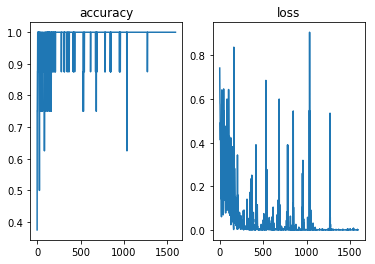

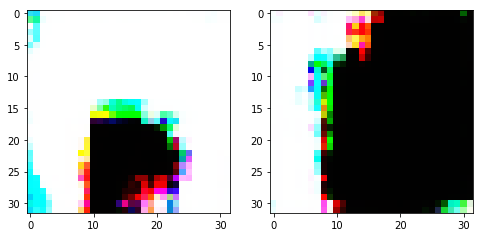

g_loss :  12.1257
g_loss :  13.7644
g_loss :  14.9476
g_loss :  13.8891
g_loss :  12.9721
g_loss :  13.8322
g_loss :  12.5784
g_loss :  12.8626
g_loss :  12.9904
g_loss :  13.292


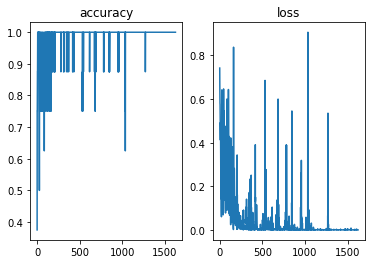

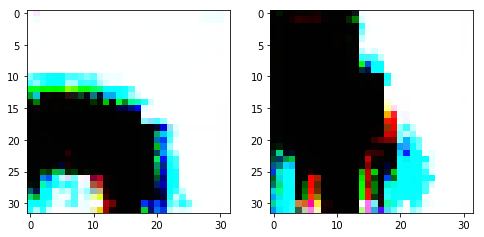

g_loss :  13.9348
g_loss :  13.9687
g_loss :  13.2007
g_loss :  13.8349
g_loss :  15.0523
g_loss :  14.645
g_loss :  12.717
g_loss :  13.8378
g_loss :  13.9631
g_loss :  12.4441


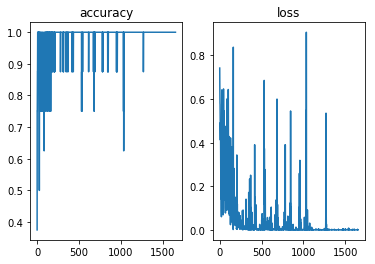

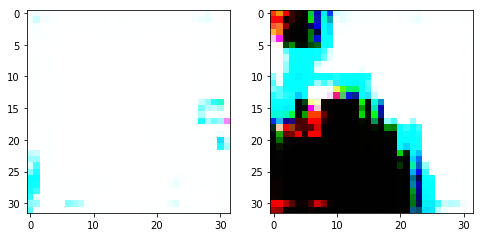

g_loss :  11.9763
g_loss :  14.3121
g_loss :  12.5605
g_loss :  14.3813
g_loss :  12.0168
g_loss :  11.4857
g_loss :  15.263
g_loss :  13.2462
g_loss :  14.2162
g_loss :  14.2805


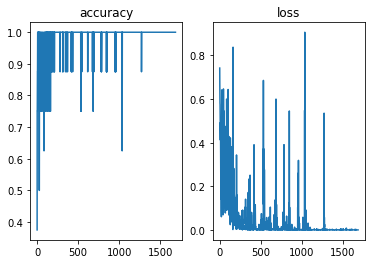

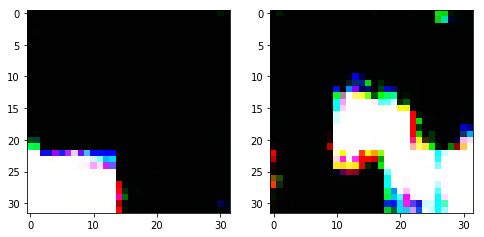

g_loss :  14.3334
g_loss :  14.1596
g_loss :  13.1407
g_loss :  13.8656
g_loss :  14.2399
g_loss :  13.7725
g_loss :  15.1871
g_loss :  14.2096
g_loss :  13.2477
g_loss :  14.1474


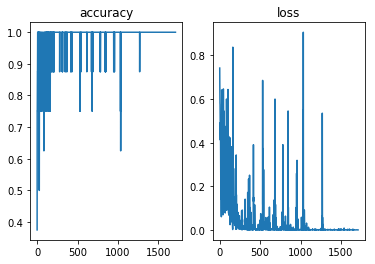

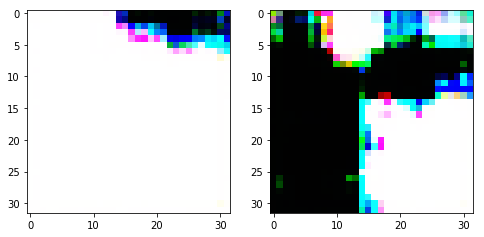

g_loss :  15.1347
g_loss :  13.2875
g_loss :  13.1988
g_loss :  12.3289
g_loss :  13.8152
g_loss :  12.4902
g_loss :  14.1681
g_loss :  13.3663
g_loss :  13.6667
g_loss :  13.6661


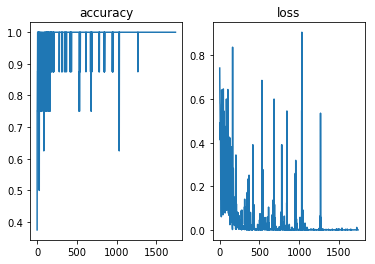

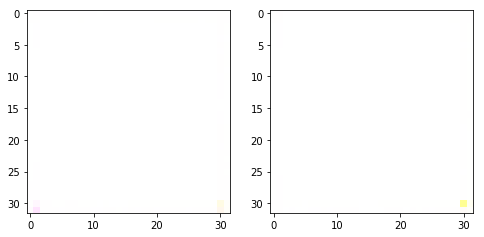

g_loss :  14.3569
g_loss :  14.8485
g_loss :  14.2533
g_loss :  14.5747
g_loss :  13.5149
g_loss :  13.4393
g_loss :  15.2331
g_loss :  14.4735
g_loss :  14.3449
g_loss :  14.3323


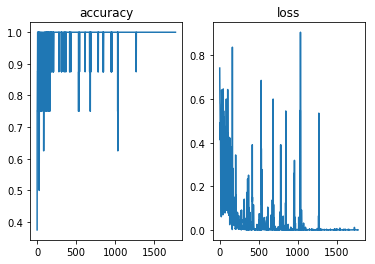

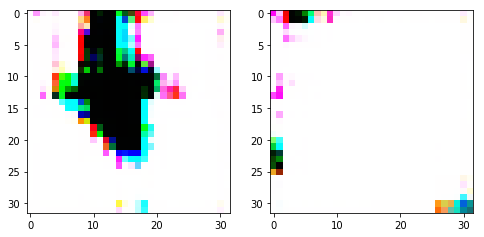

g_loss :  13.6785
g_loss :  14.3716
g_loss :  13.7232
g_loss :  14.4407
g_loss :  14.0396
g_loss :  13.4576
g_loss :  12.4274
g_loss :  14.3414
g_loss :  13.2584
g_loss :  14.4156


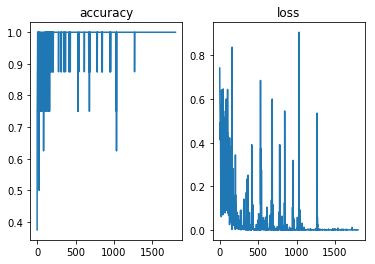

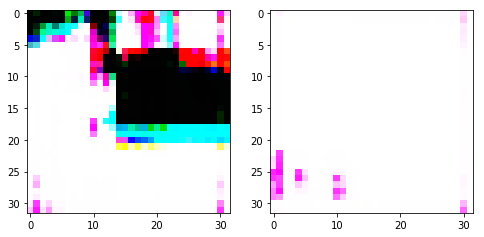

g_loss :  14.9383
g_loss :  13.6197
g_loss :  13.4513
g_loss :  14.5042
g_loss :  15.1516
g_loss :  14.4085
g_loss :  13.1516
g_loss :  13.062
g_loss :  15.2386
g_loss :  13.649


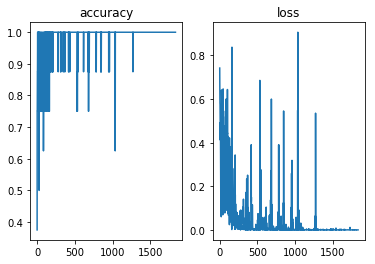

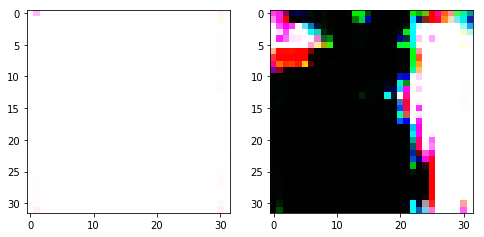

g_loss :  13.7002
g_loss :  13.3532
g_loss :  14.2437
g_loss :  14.4274
g_loss :  14.5138
g_loss :  13.8376
g_loss :  13.0006
g_loss :  12.4624
g_loss :  12.867
g_loss :  13.9459


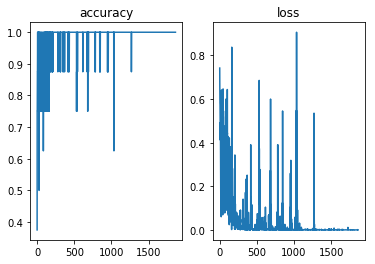

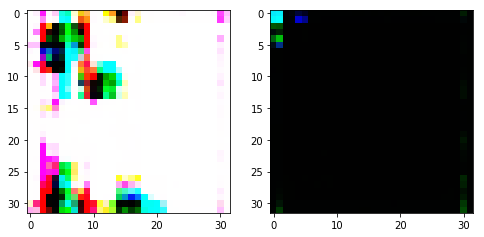

g_loss :  13.6001
g_loss :  15.3955
g_loss :  14.9262
g_loss :  15.0541
g_loss :  15.2989
g_loss :  13.8351
g_loss :  14.3482
g_loss :  15.3503
g_loss :  12.2357
g_loss :  14.5055


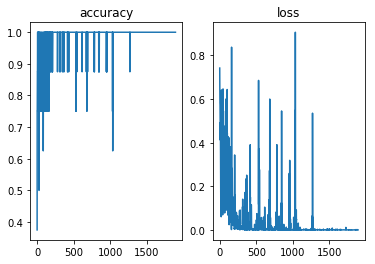

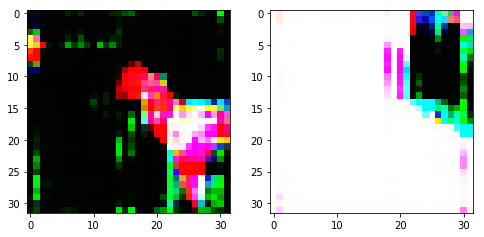

g_loss :  11.4426
g_loss :  14.6482
g_loss :  14.4239
g_loss :  14.43
g_loss :  14.0477
g_loss :  12.8396
g_loss :  14.6673
g_loss :  13.3763
g_loss :  12.0172
g_loss :  14.4095


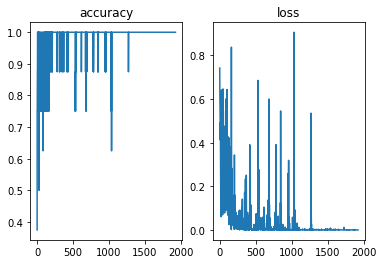

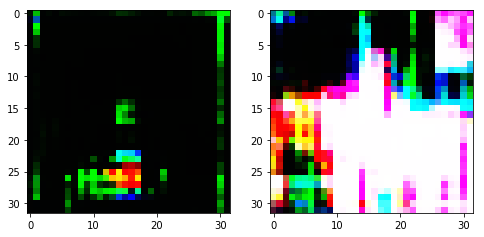

g_loss :  13.7904
g_loss :  14.4234
g_loss :  13.459
g_loss :  15.3059
g_loss :  13.2618
g_loss :  14.2523
g_loss :  14.319
g_loss :  13.8735
g_loss :  14.4933
g_loss :  12.55


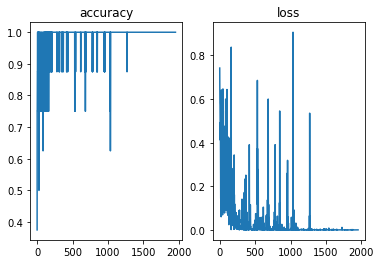

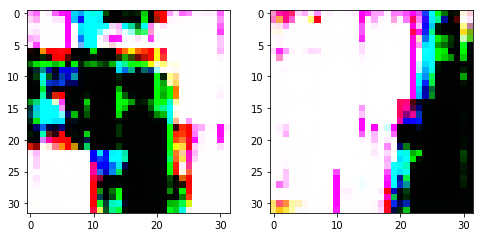

g_loss :  13.8615
g_loss :  13.9012
g_loss :  14.2828
g_loss :  13.4805
g_loss :  15.1711
g_loss :  12.8839
g_loss :  14.5386
g_loss :  12.1725
g_loss :  15.33
g_loss :  15.015


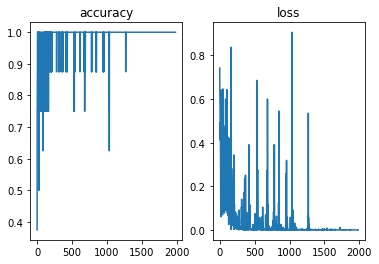

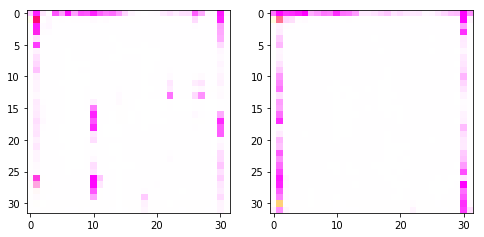

g_loss :  12.8217
g_loss :  14.7982
g_loss :  14.4003
g_loss :  13.1435
g_loss :  13.9943
g_loss :  13.1426
g_loss :  14.0244
g_loss :  14.0455
g_loss :  13.2753
g_loss :  11.7434


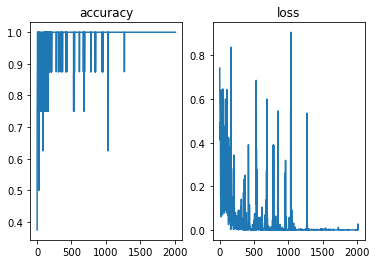

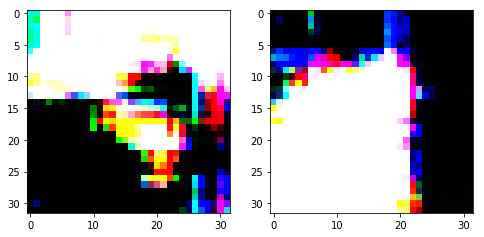

g_loss :  11.146
g_loss :  11.794
g_loss :  11.8031
g_loss :  14.1689
g_loss :  11.9148
g_loss :  13.1866
g_loss :  15.2234
g_loss :  13.8863
g_loss :  12.7234
g_loss :  13.2133


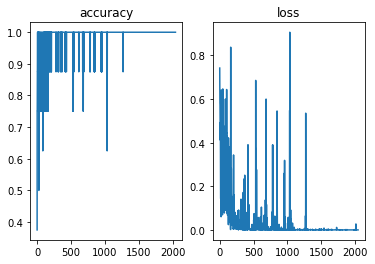

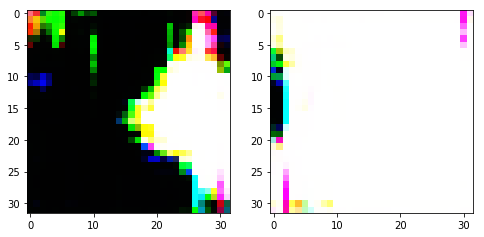

g_loss :  14.0894
g_loss :  12.8737
g_loss :  13.7603
g_loss :  13.9628
g_loss :  12.9632
g_loss :  12.975
g_loss :  12.8521
g_loss :  14.4965
g_loss :  13.0932
g_loss :  13.9584


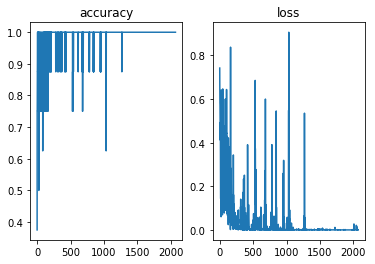

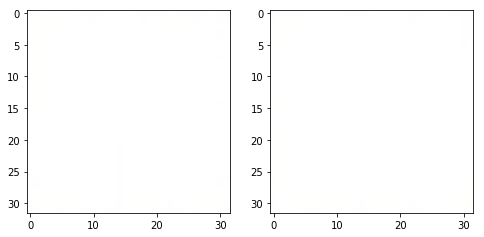

g_loss :  13.5017
g_loss :  12.4083
g_loss :  11.6051
g_loss :  12.5284
g_loss :  13.2991
g_loss :  11.3905
g_loss :  15.0306
g_loss :  11.1008
g_loss :  6.08934
g_loss :  8.05905


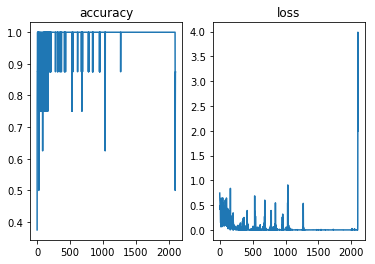

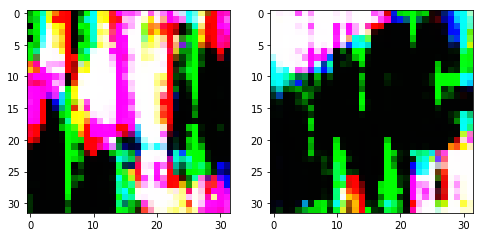

g_loss :  11.479
g_loss :  10.0738
g_loss :  6.74377
g_loss :  11.5499
g_loss :  10.3963
g_loss :  11.7015
g_loss :  10.4594
g_loss :  12.5018
g_loss :  11.3007
g_loss :  8.72484


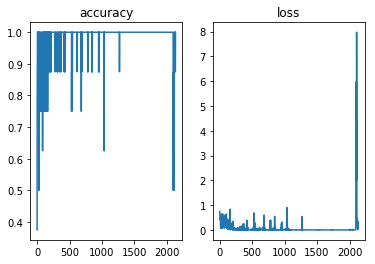

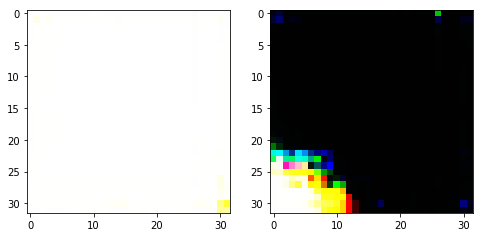

g_loss :  10.6787
g_loss :  12.6258
g_loss :  10.8108
g_loss :  12.9031
g_loss :  8.43043
g_loss :  9.37052
g_loss :  11.4055
g_loss :  11.1729
g_loss :  9.7831
g_loss :  9.68753


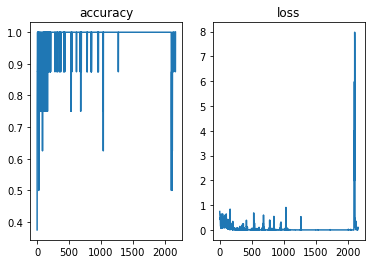

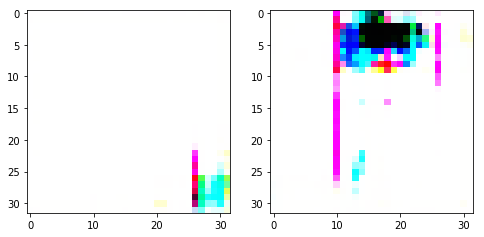

g_loss :  11.9478
g_loss :  11.6539
g_loss :  10.0052
g_loss :  11.6159
g_loss :  11.6195
g_loss :  10.2455
g_loss :  10.3907
g_loss :  13.3589
g_loss :  10.2922
g_loss :  11.8943


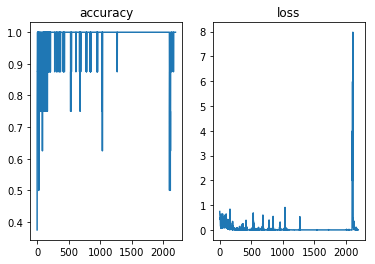

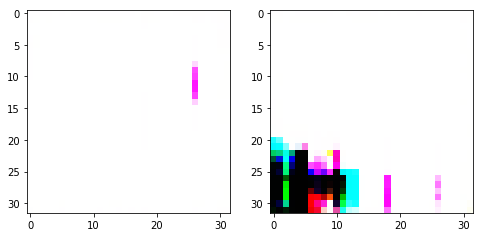

g_loss :  11.597
g_loss :  13.4553
g_loss :  13.383
g_loss :  13.4831
g_loss :  13.4108
g_loss :  11.7762
g_loss :  12.2753
g_loss :  11.1533
g_loss :  12.1337
g_loss :  11.993


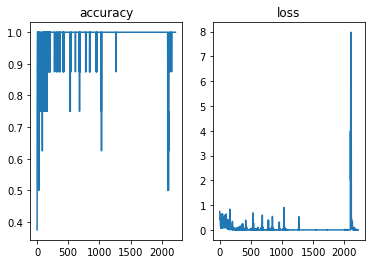

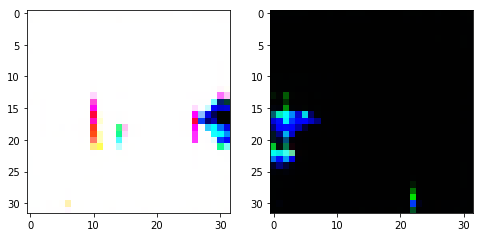

g_loss :  10.4787
g_loss :  10.6136
g_loss :  11.7579
g_loss :  12.0256
g_loss :  12.9352
g_loss :  10.0173
g_loss :  11.1072
g_loss :  12.5394
g_loss :  13.0261
g_loss :  12.6363


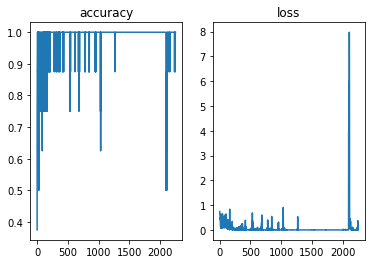

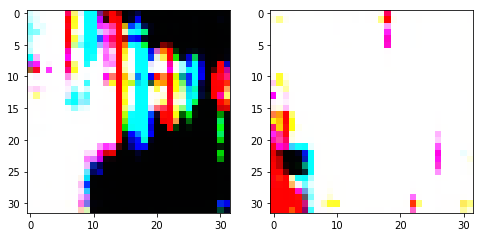

g_loss :  13.6202
g_loss :  12.5322
g_loss :  13.6478
g_loss :  11.4443
g_loss :  14.9252
g_loss :  14.6894
g_loss :  11.4483
g_loss :  13.1654
g_loss :  11.1103
g_loss :  13.8668


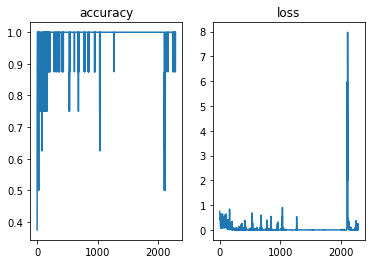

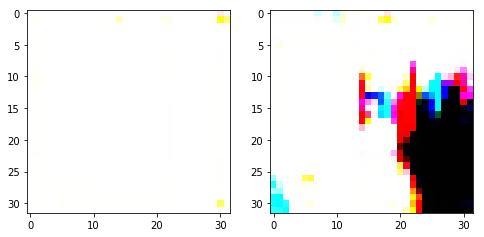

g_loss :  13.772
g_loss :  11.8061
g_loss :  12.1022
g_loss :  13.1023
g_loss :  14.4633
g_loss :  13.4759
g_loss :  10.0433
g_loss :  11.9322
g_loss :  8.17952
g_loss :  8.33523


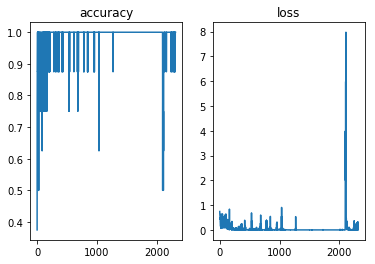

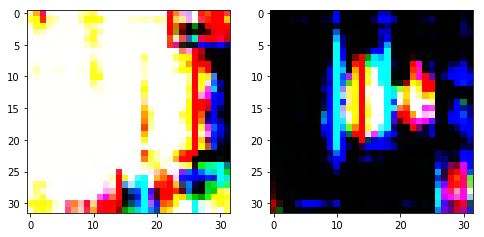

g_loss :  11.3945
g_loss :  11.6778
g_loss :  9.01974
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


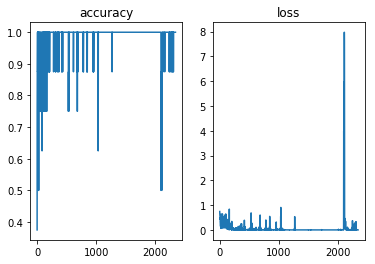

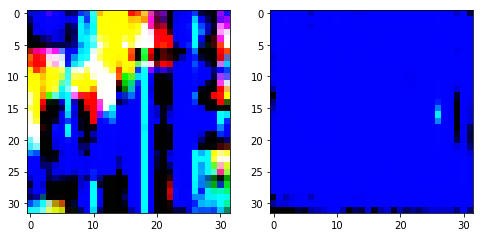

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


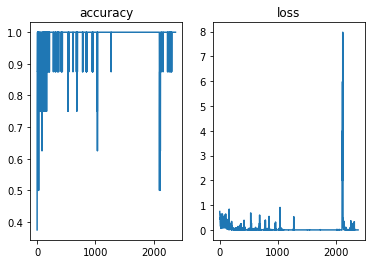

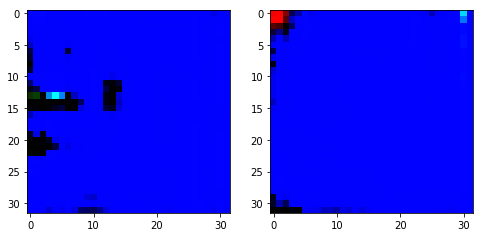

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


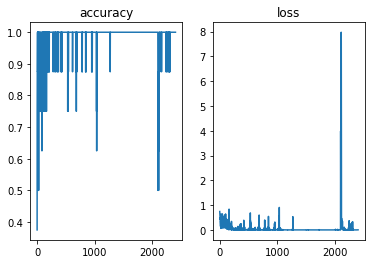

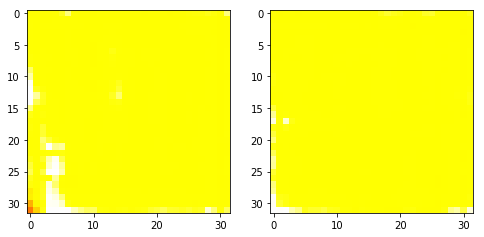

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


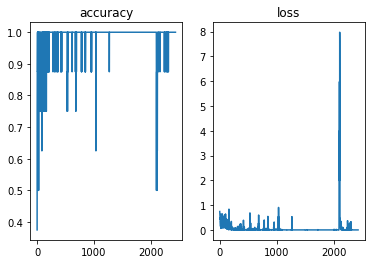

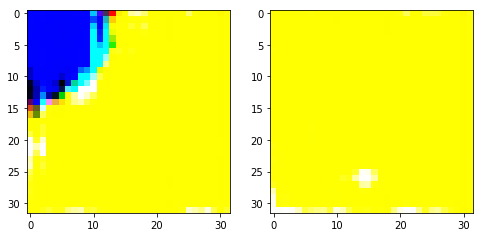

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


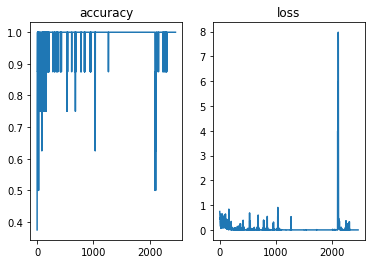

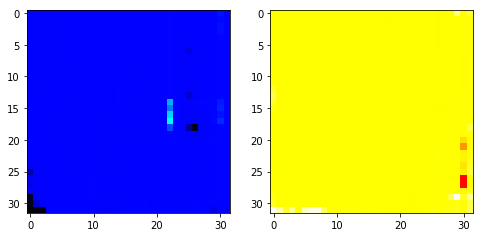

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


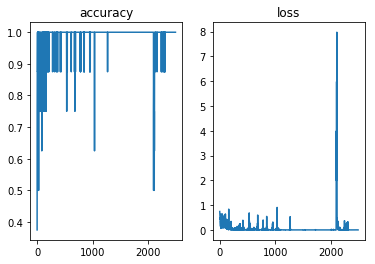

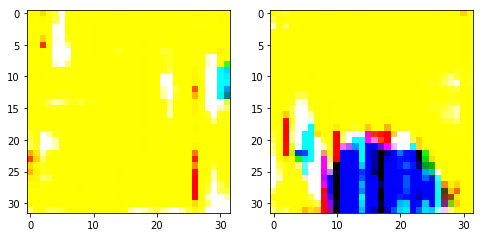

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


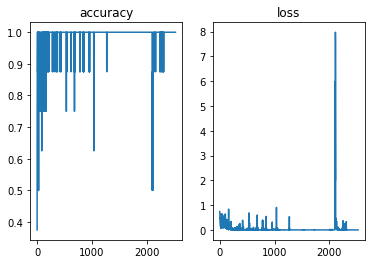

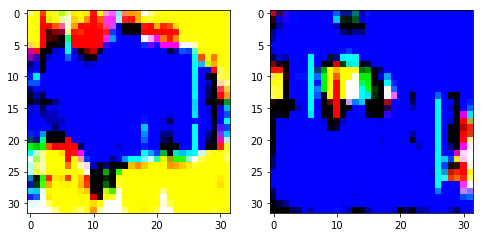

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


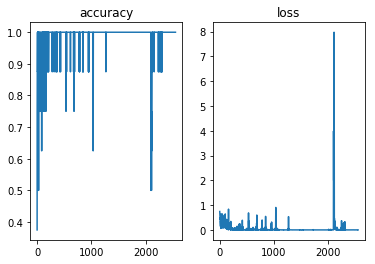

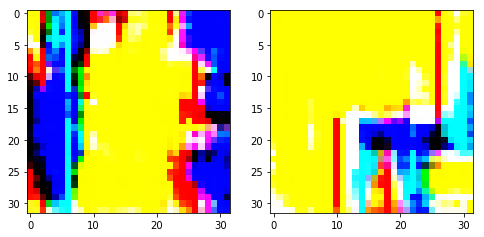

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


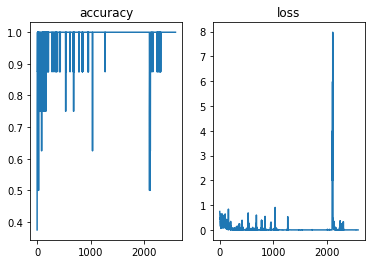

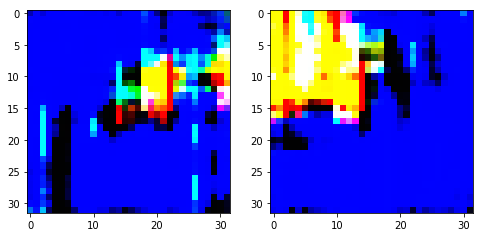

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


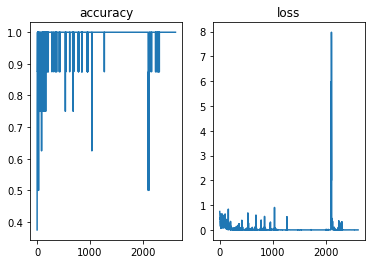

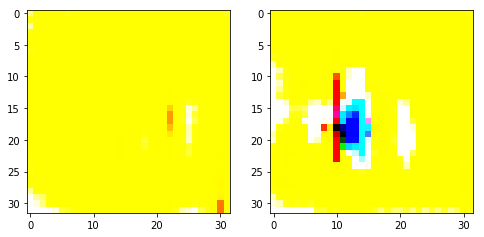

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


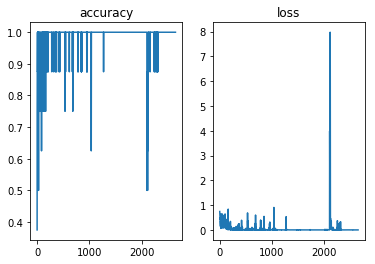

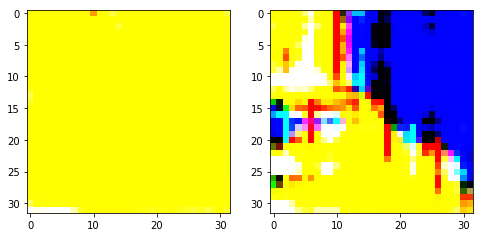

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


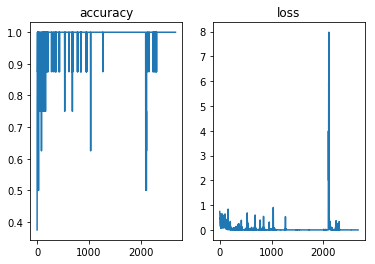

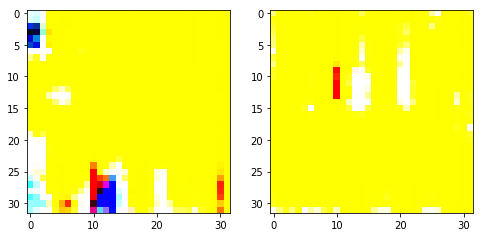

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


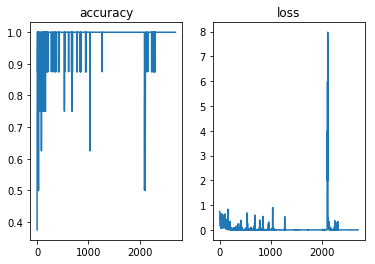

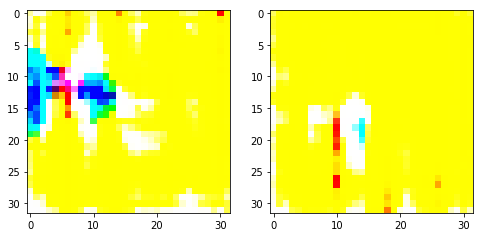

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


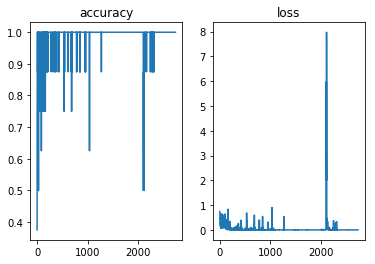

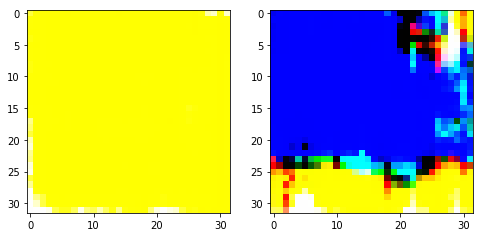

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


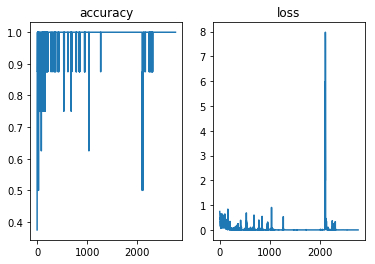

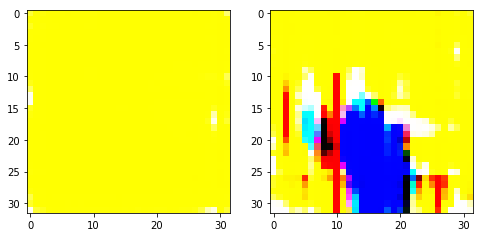

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


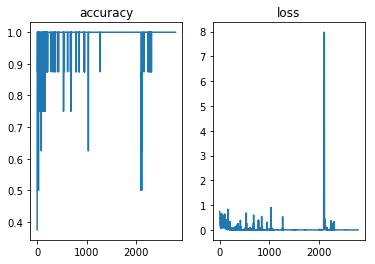

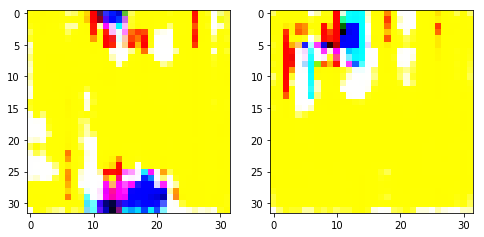

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


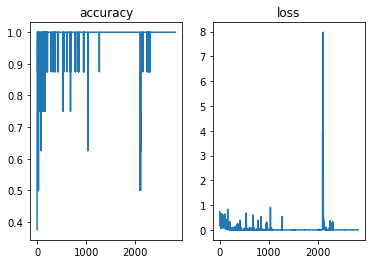

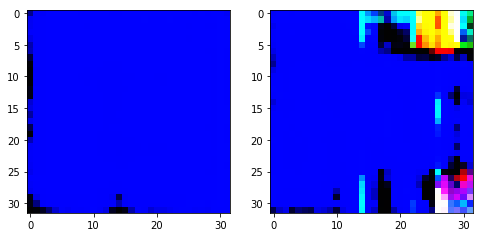

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


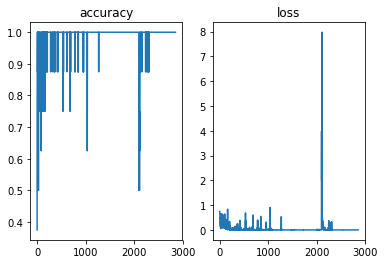

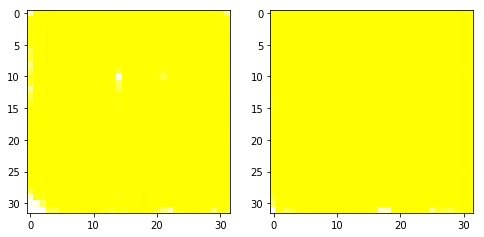

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


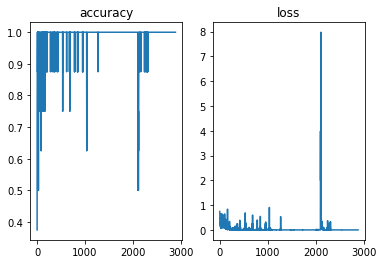

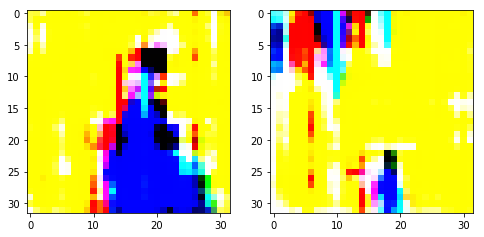

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


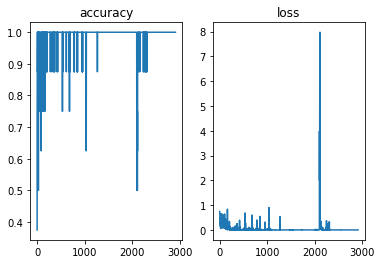

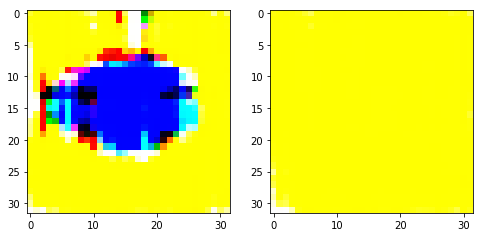

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


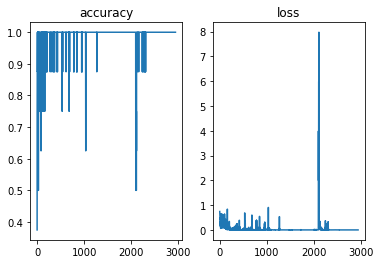

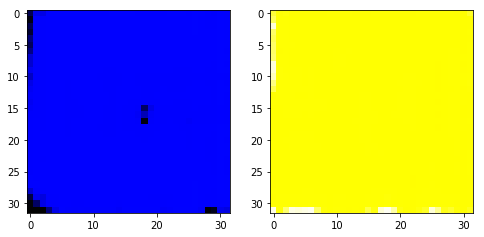

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


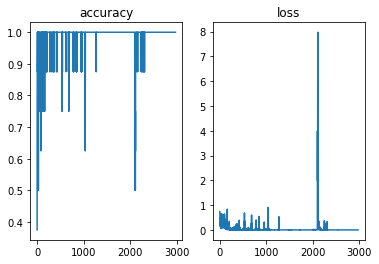

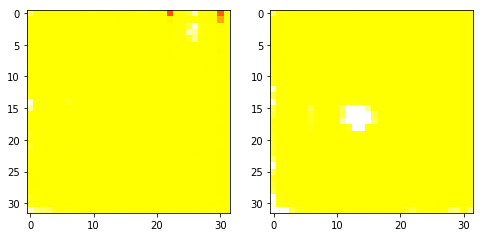

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


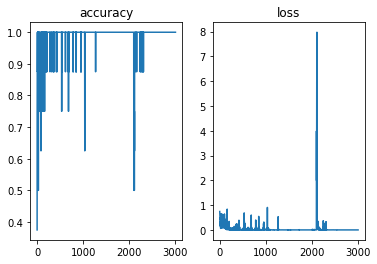

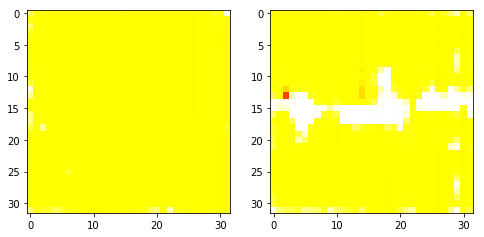

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


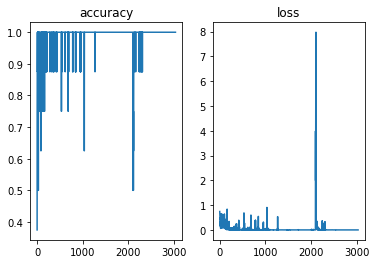

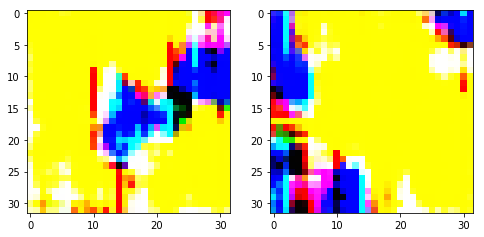

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


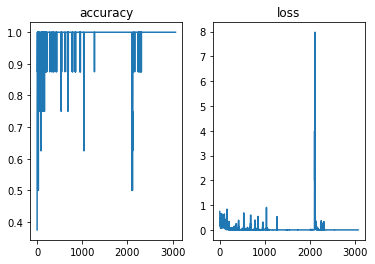

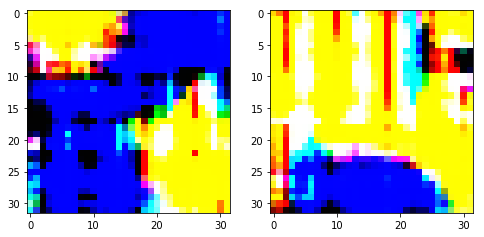

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


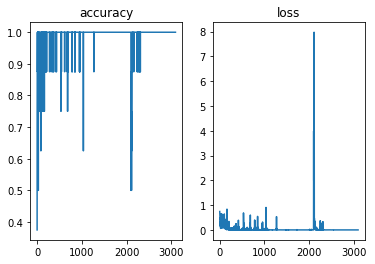

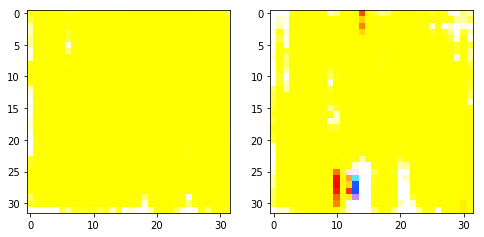

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


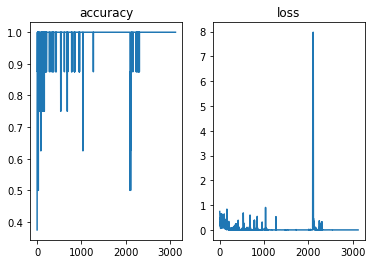

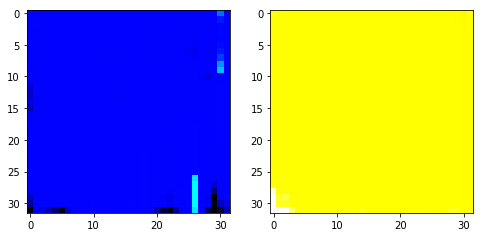

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


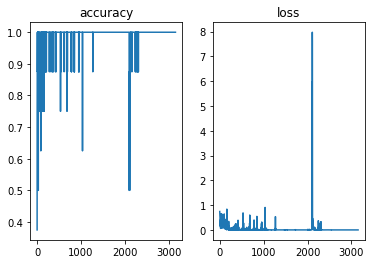

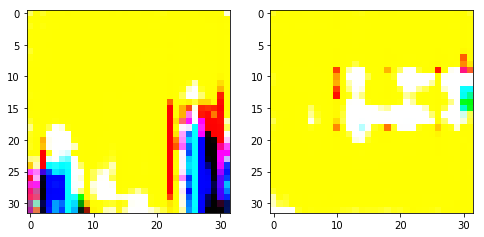

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


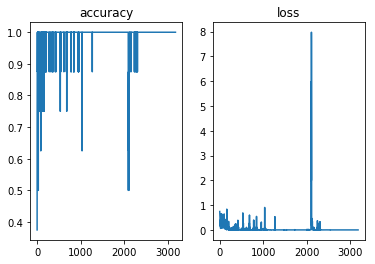

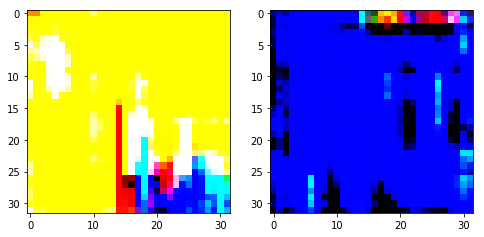

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


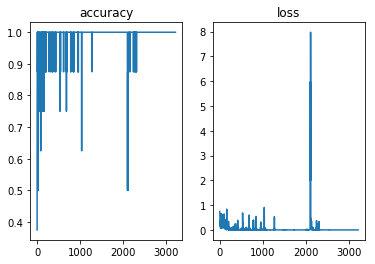

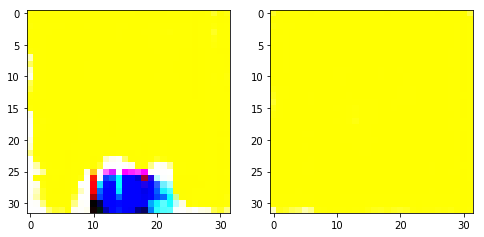

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


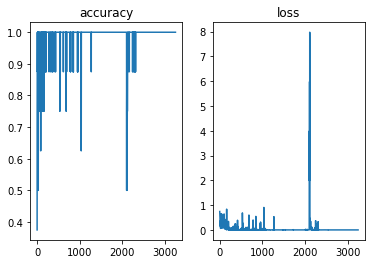

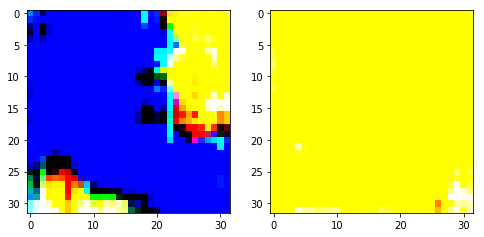

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


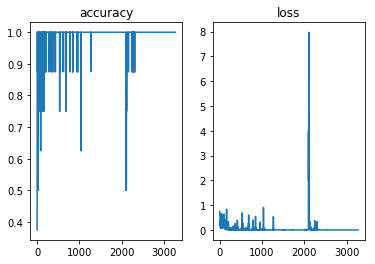

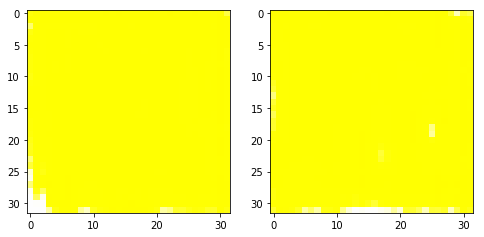

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


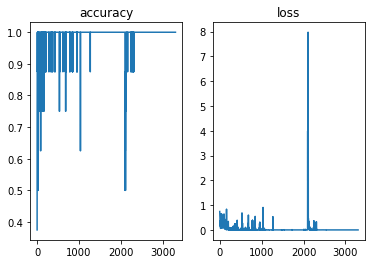

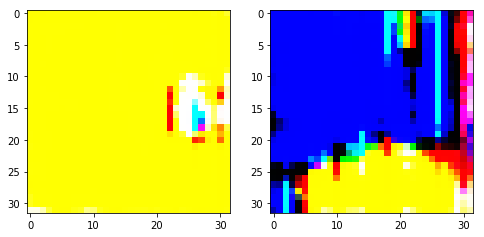

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


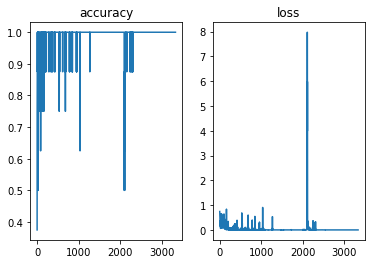

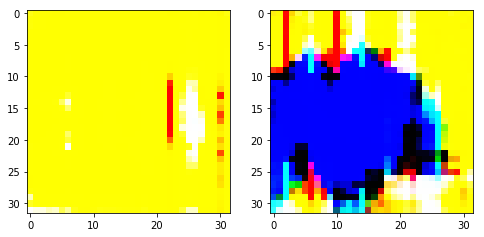

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


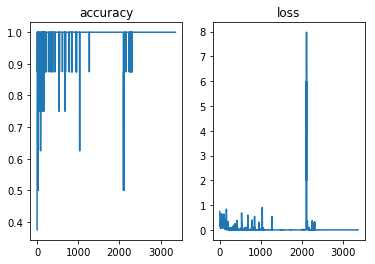

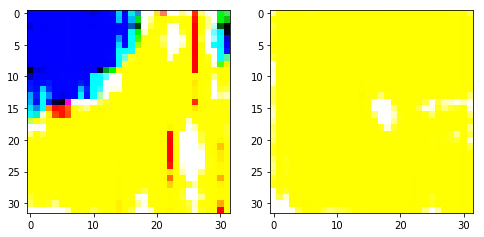

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


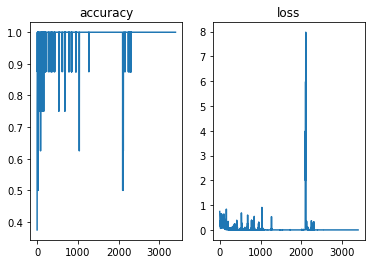

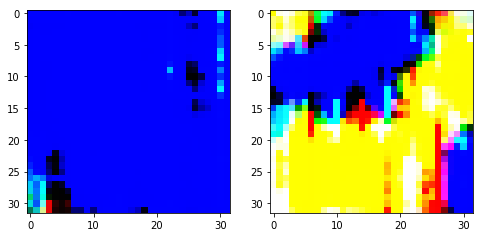

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


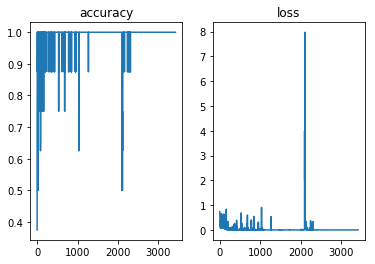

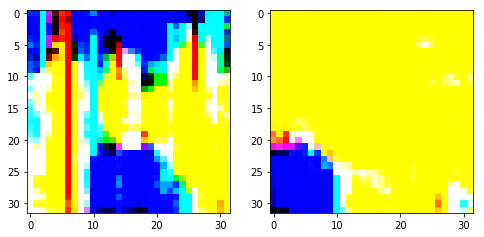

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


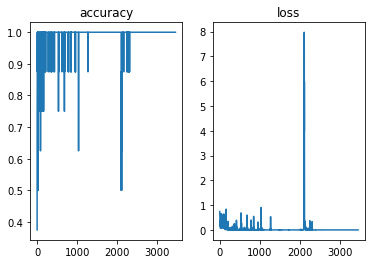

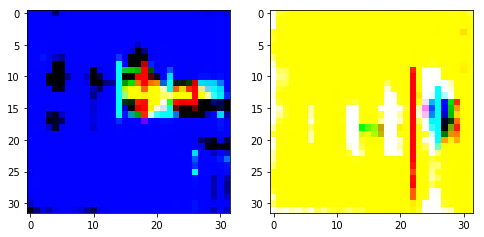

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


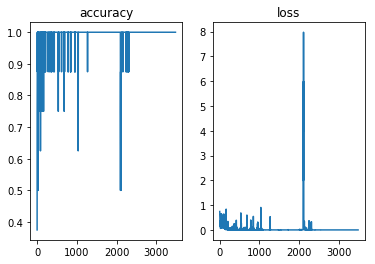

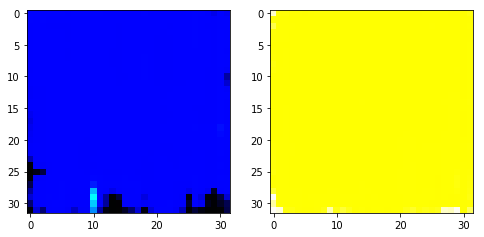

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


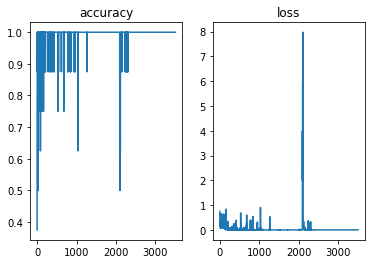

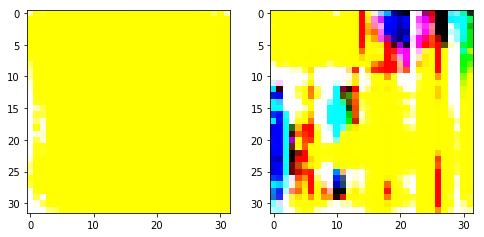

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


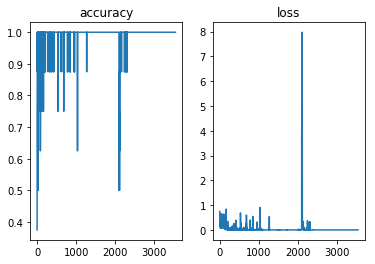

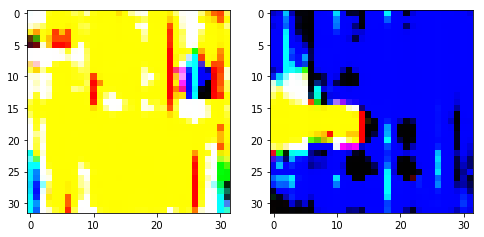

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


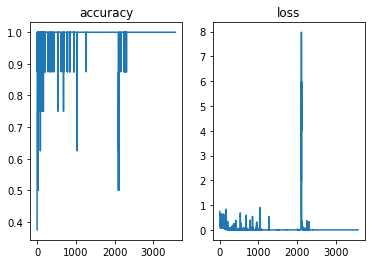

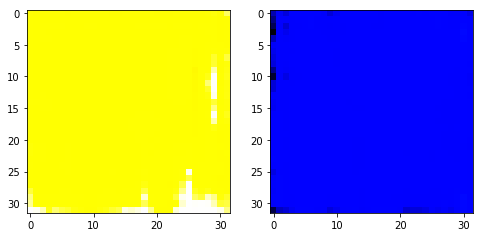

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


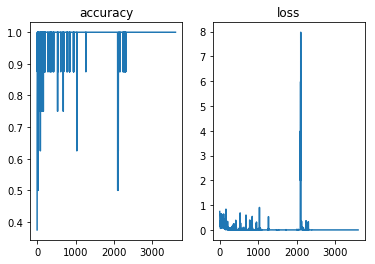

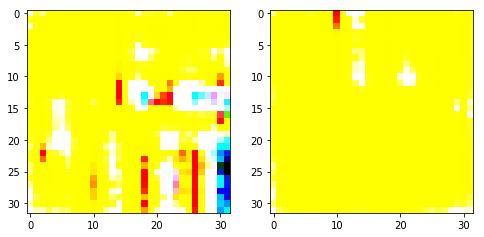

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


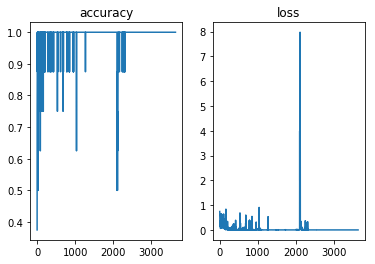

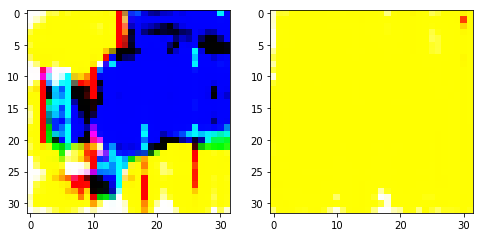

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


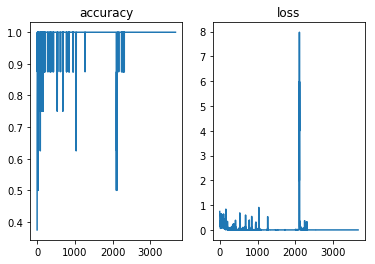

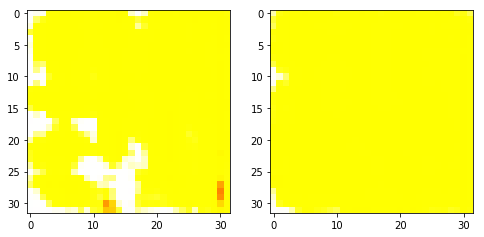

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


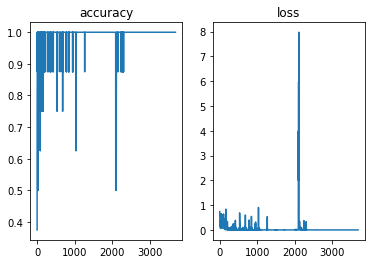

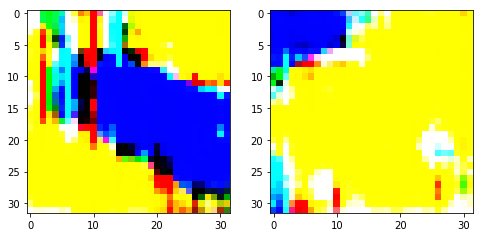

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


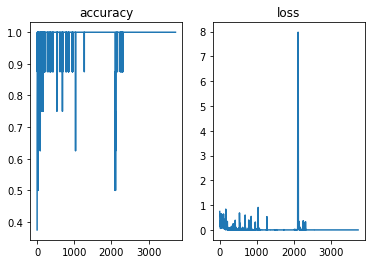

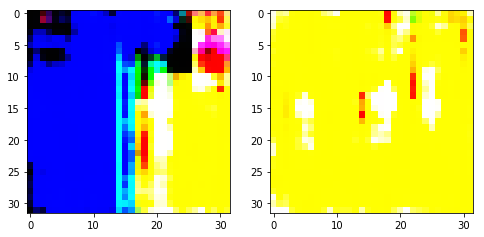

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


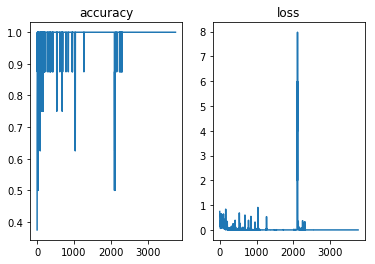

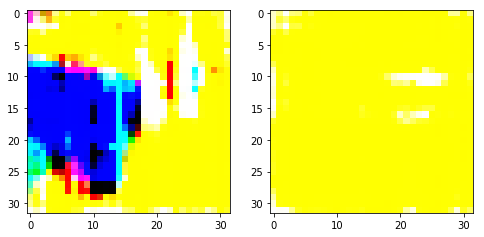

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


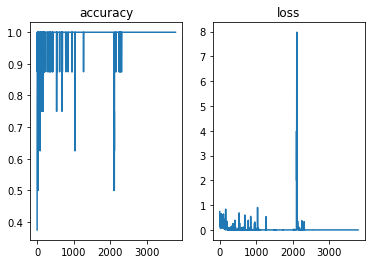

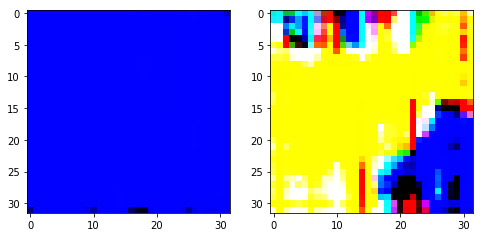

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


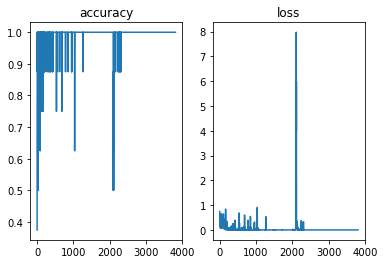

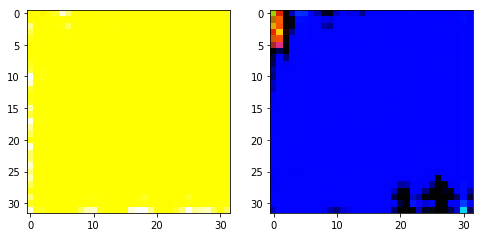

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


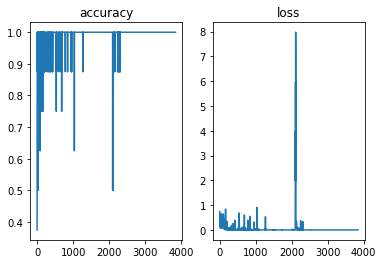

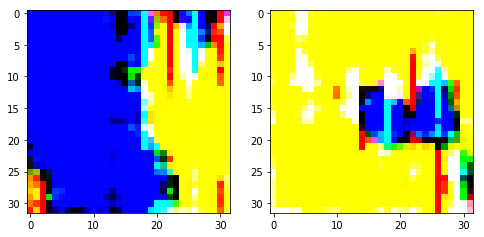

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


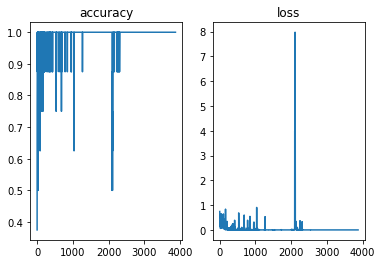

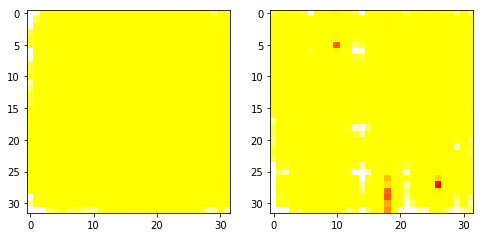

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


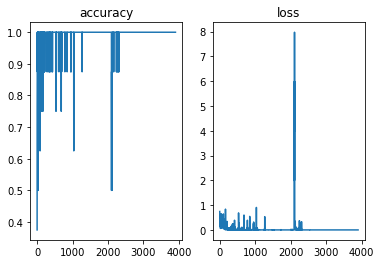

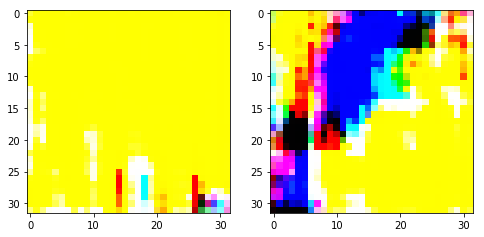

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


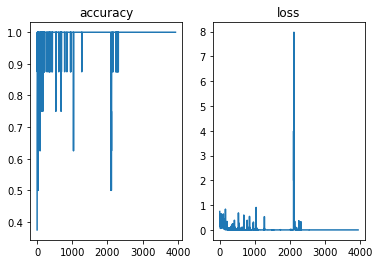

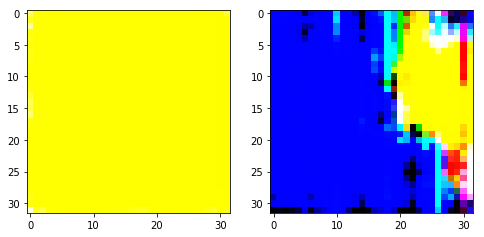

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


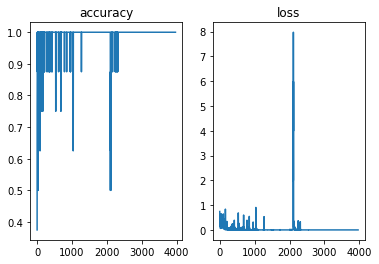

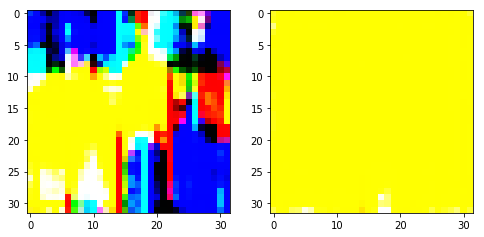

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


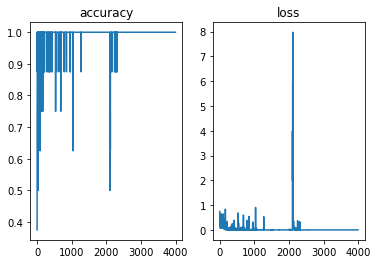

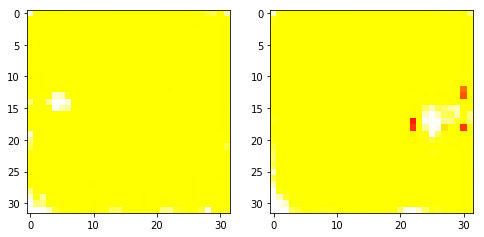

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


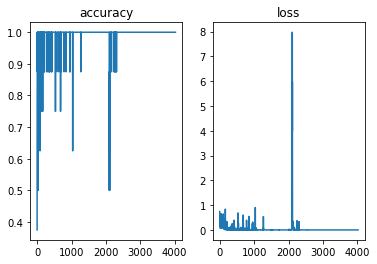

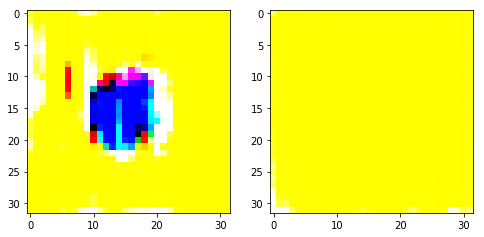

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


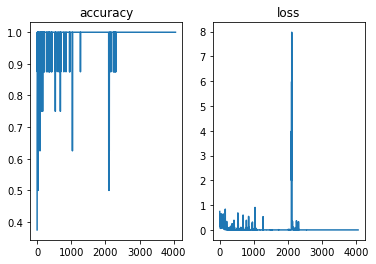

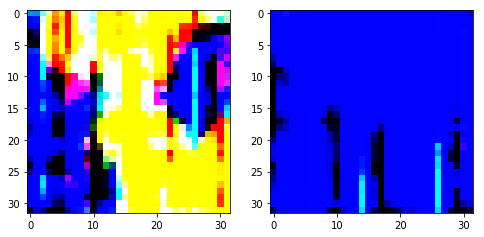

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


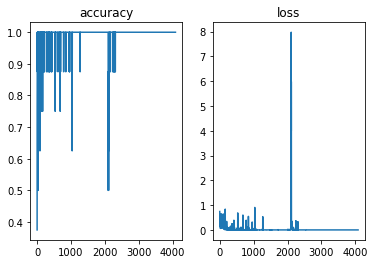

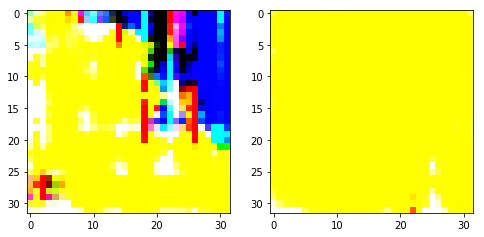

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


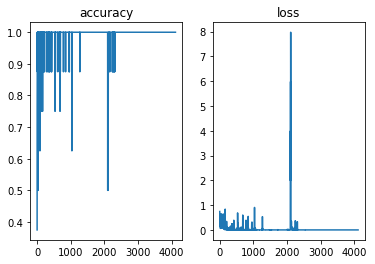

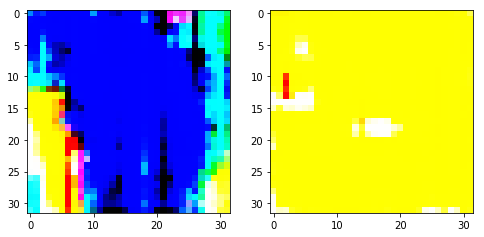

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


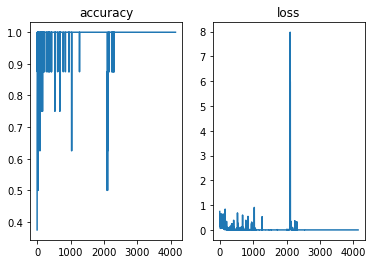

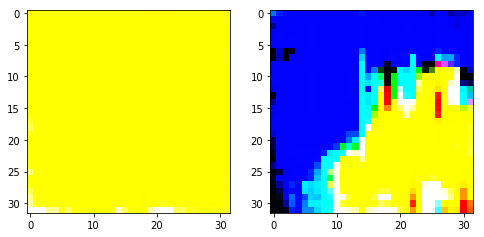

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


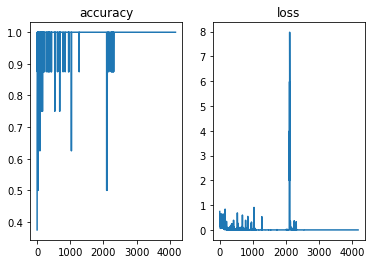

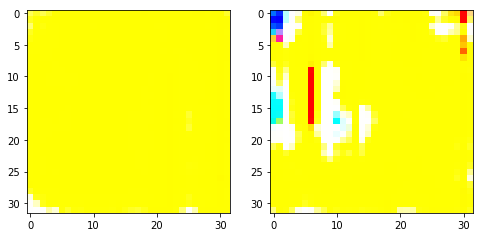

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


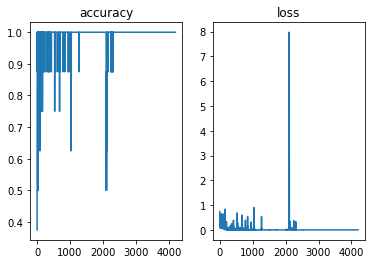

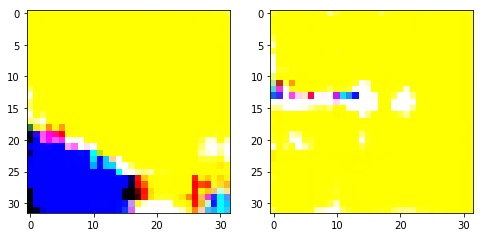

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


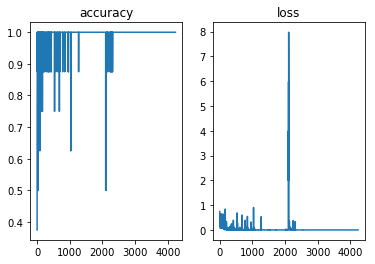

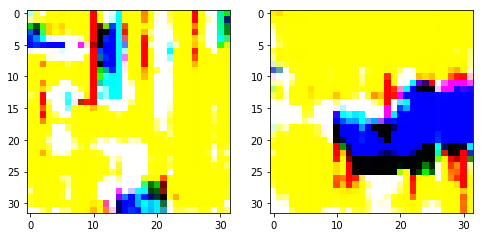

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


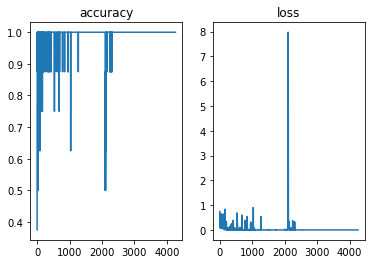

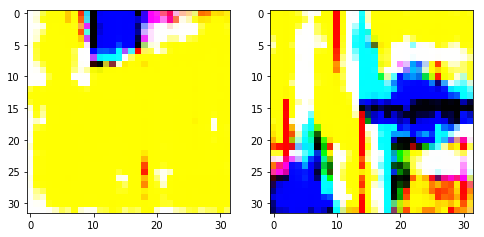

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


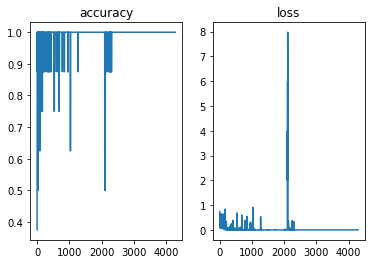

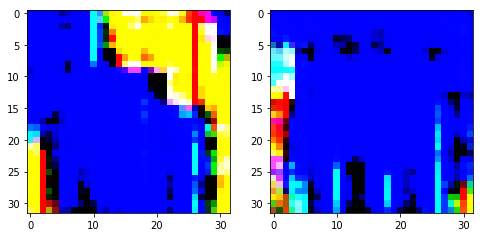

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


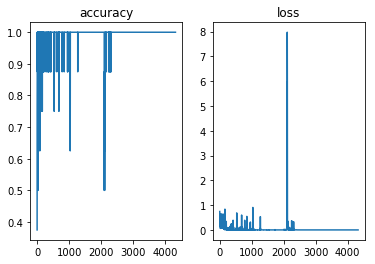

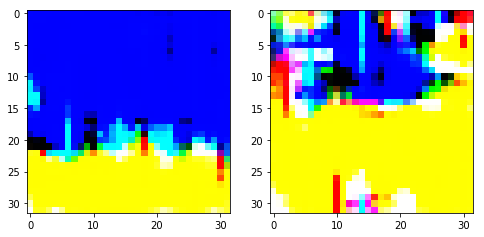

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


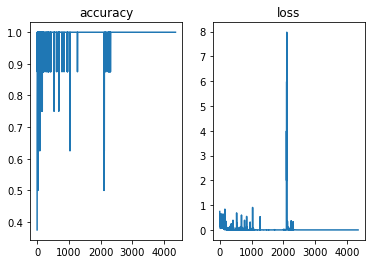

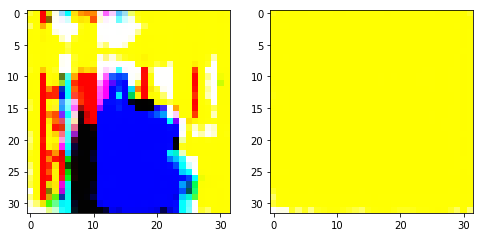

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


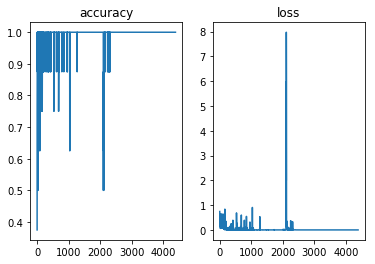

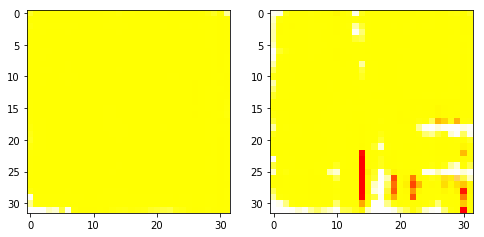

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


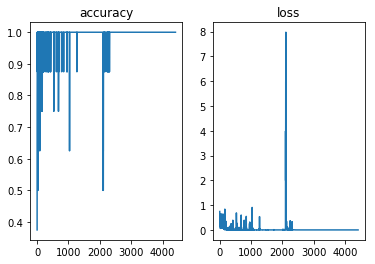

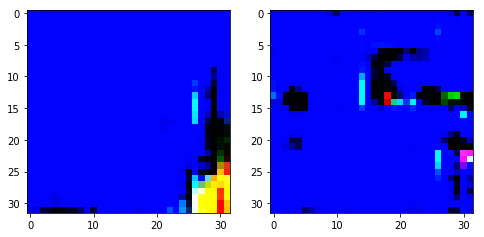

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


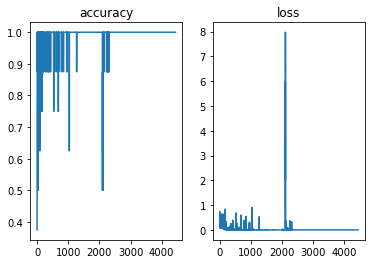

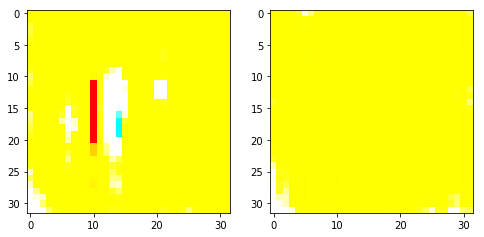

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


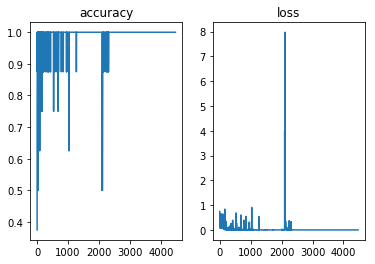

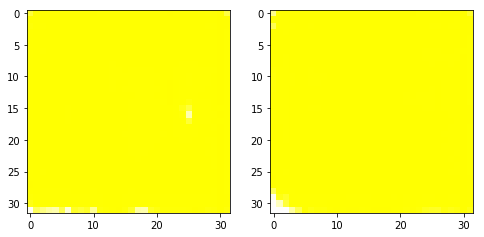

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


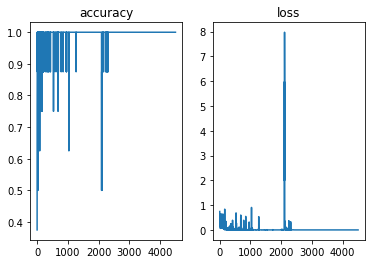

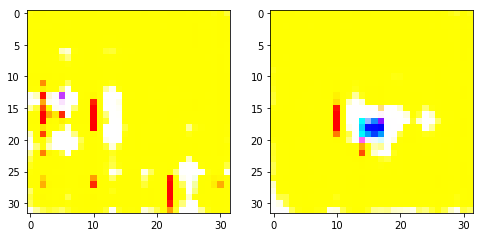

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


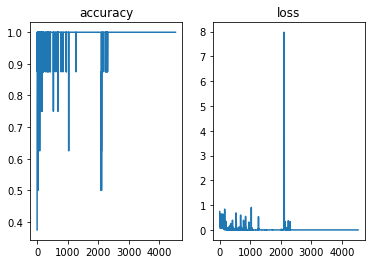

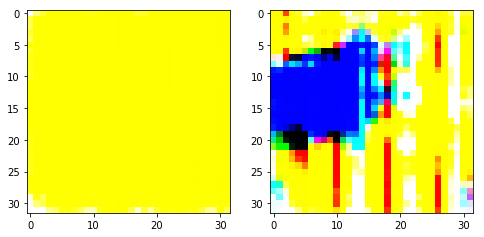

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


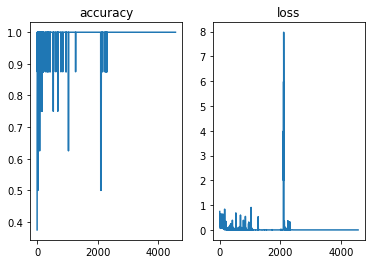

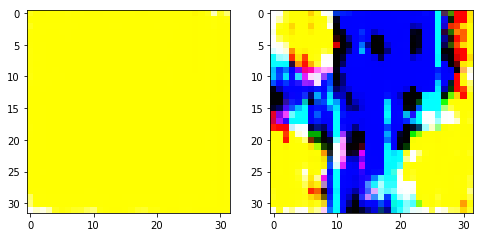

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


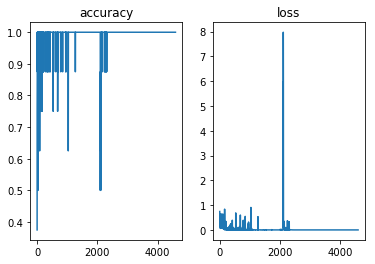

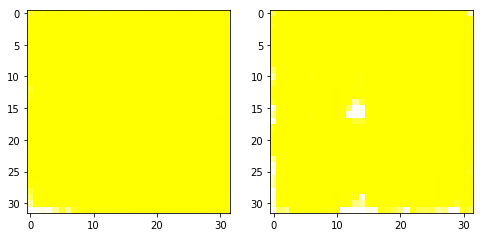

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


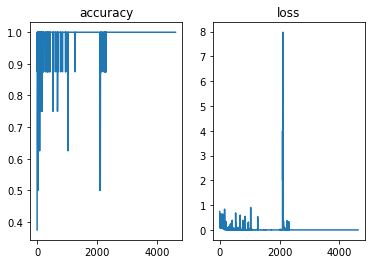

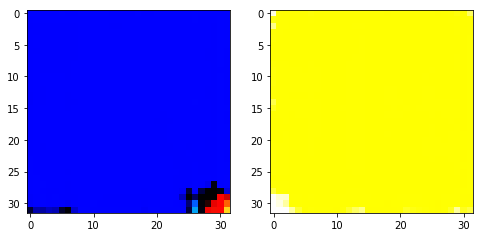

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


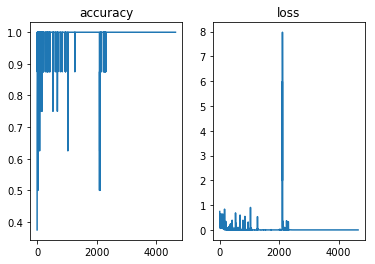

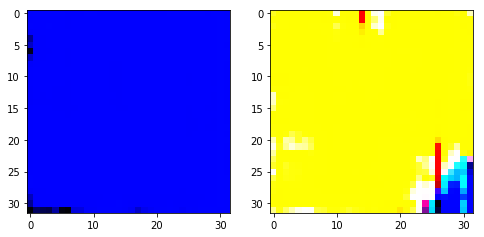

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


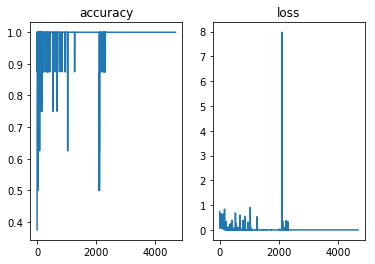

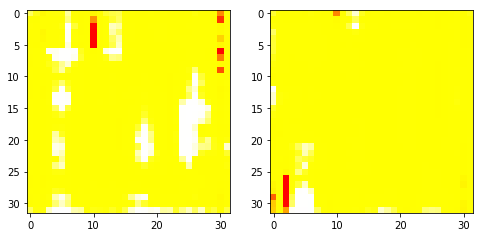

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


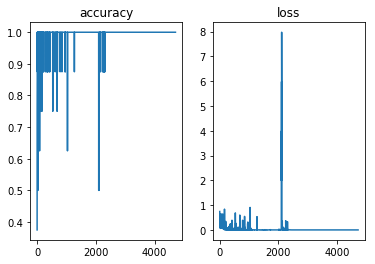

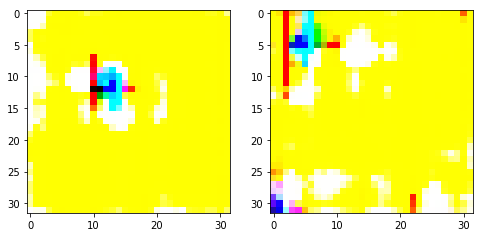

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


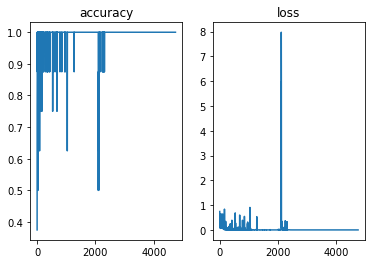

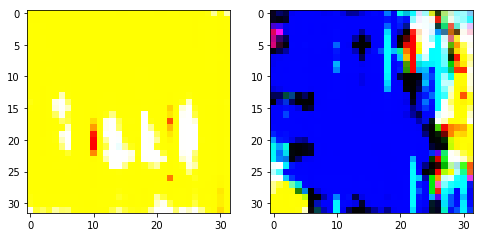

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


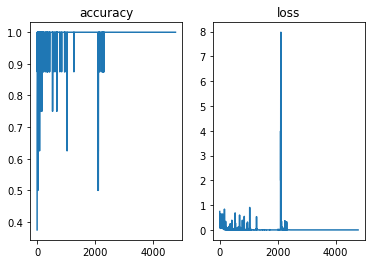

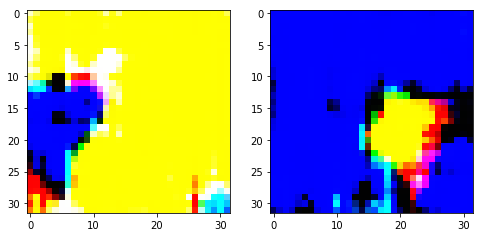

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


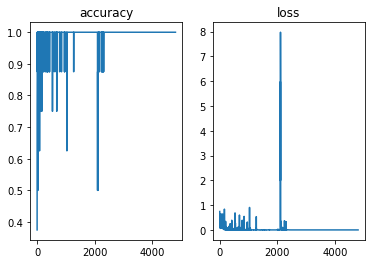

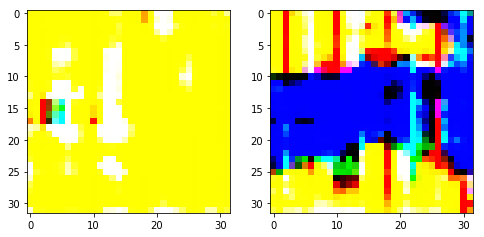

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


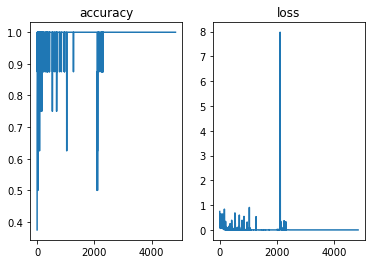

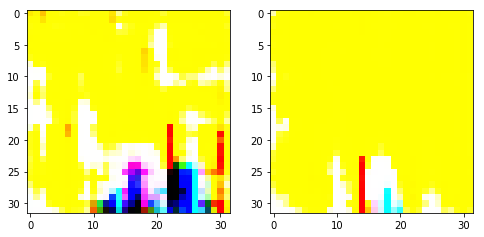

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


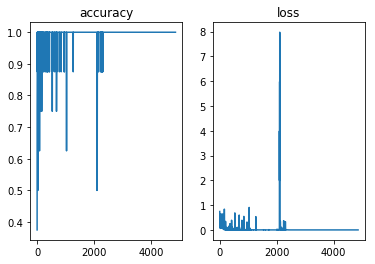

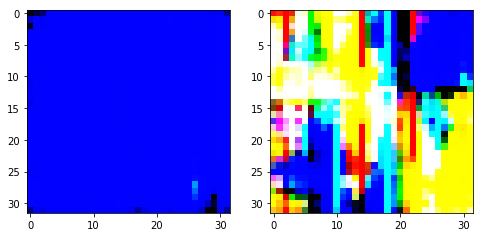

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


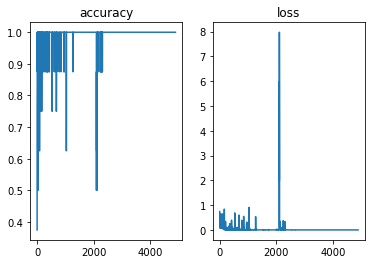

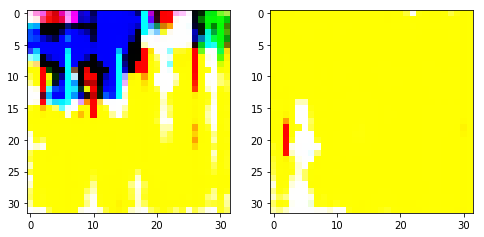

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


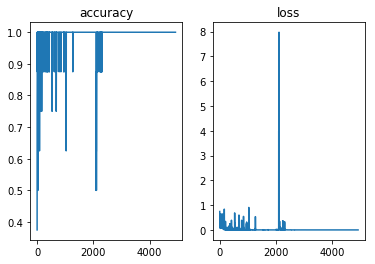

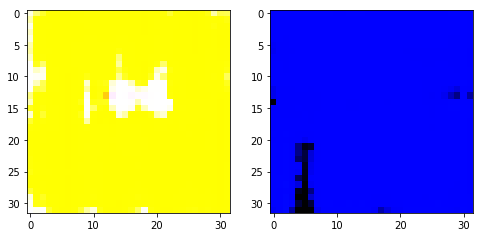

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


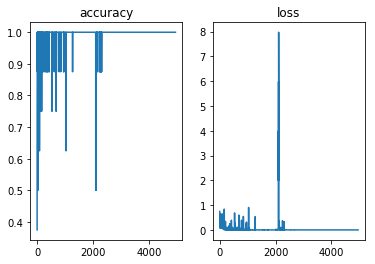

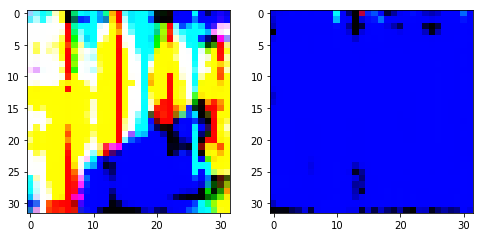

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


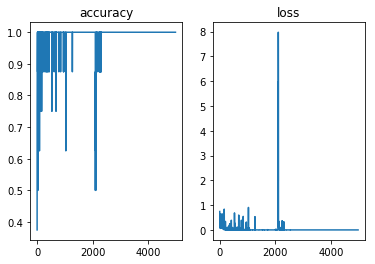

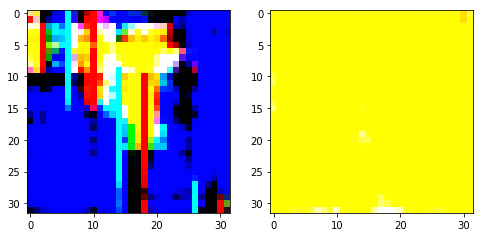

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


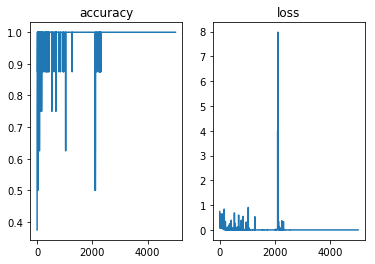

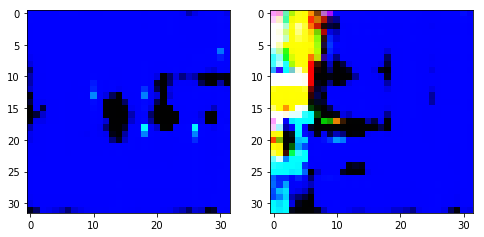

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


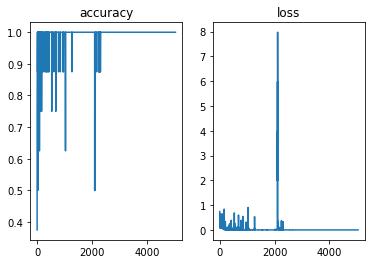

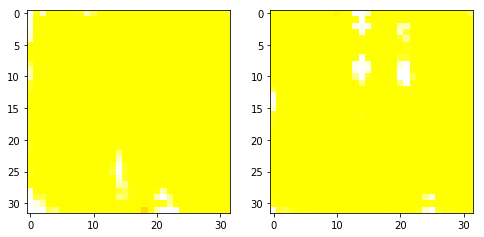

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


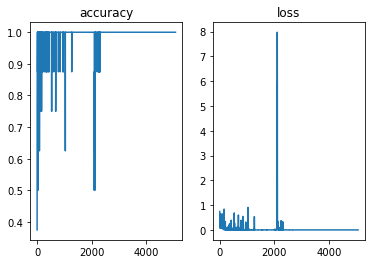

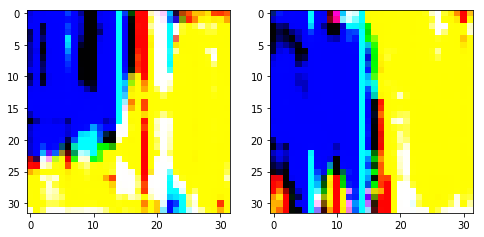

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


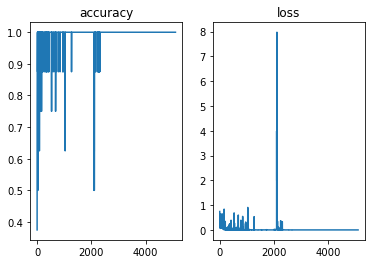

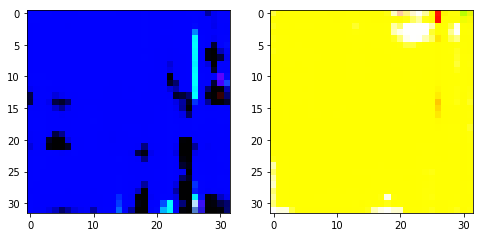

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


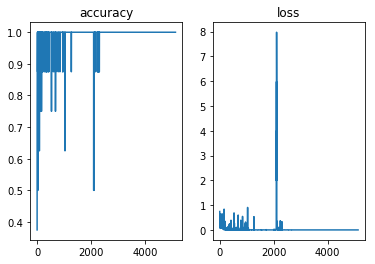

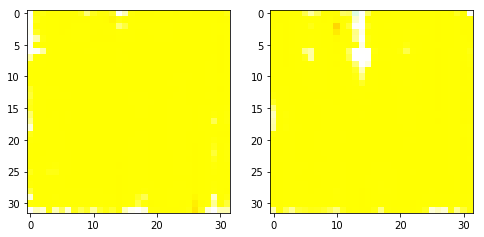

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


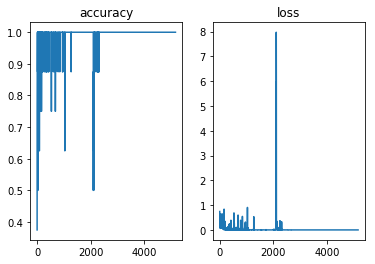

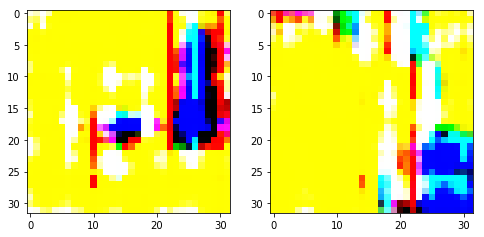

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


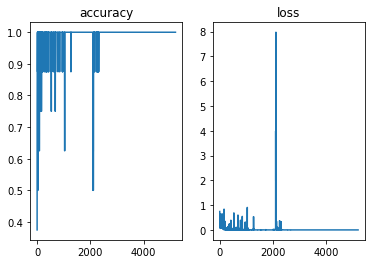

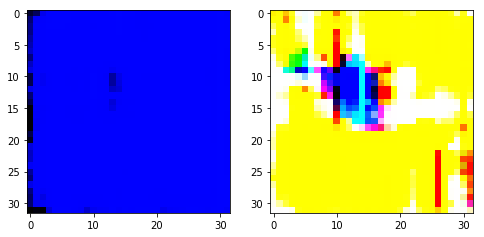

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


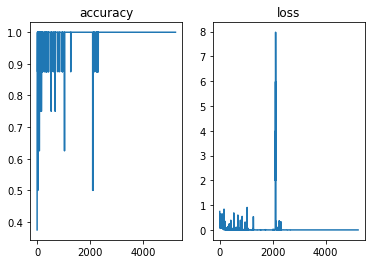

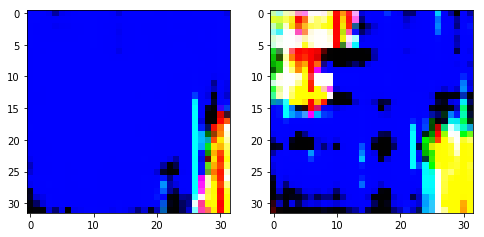

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


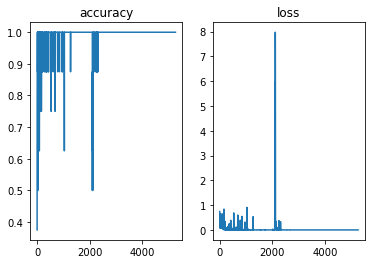

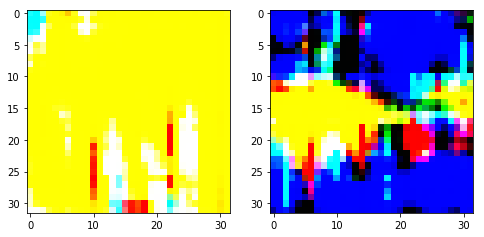

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


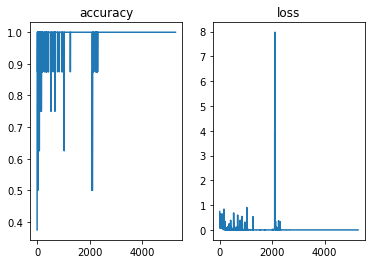

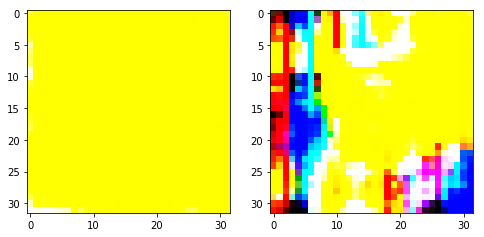

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


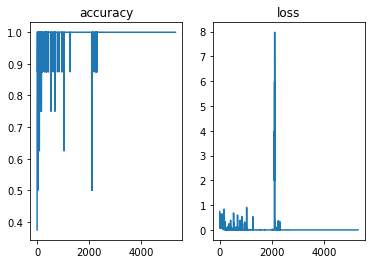

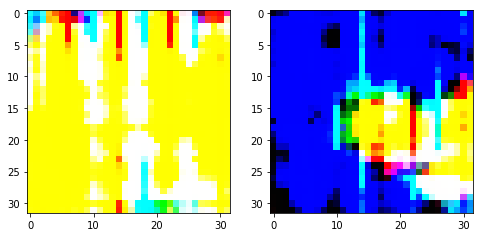

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


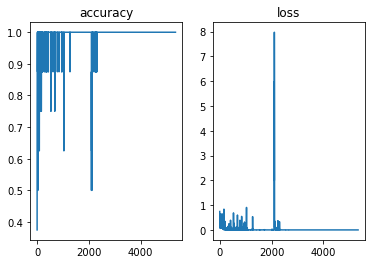

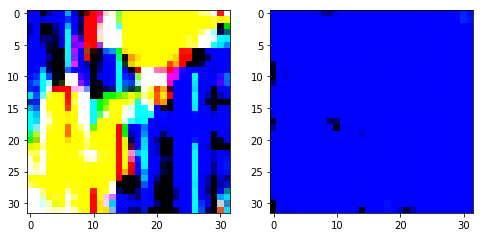

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


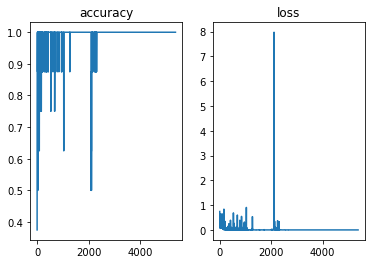

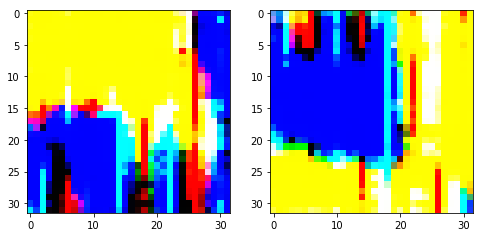

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


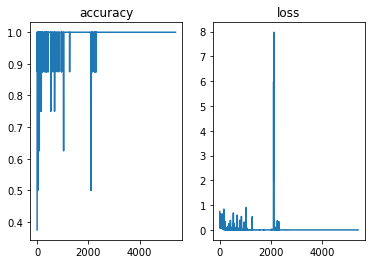

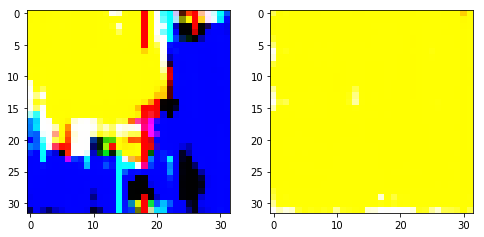

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


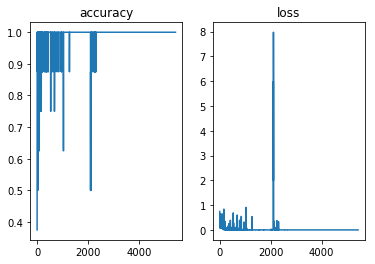

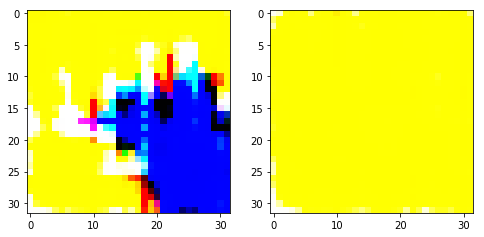

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


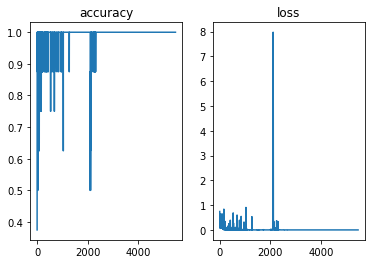

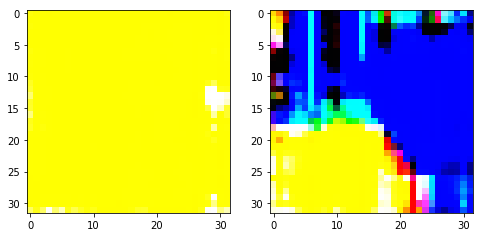

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


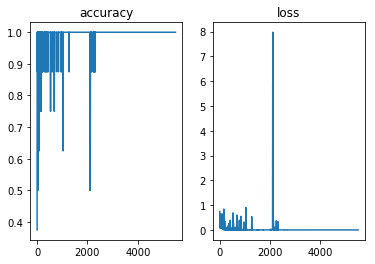

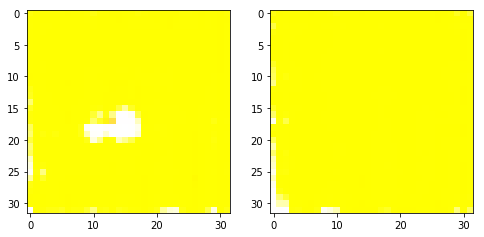

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


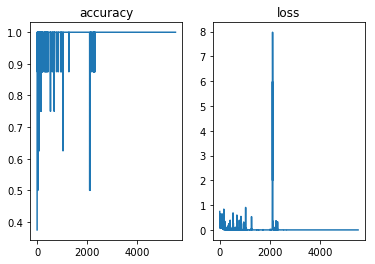

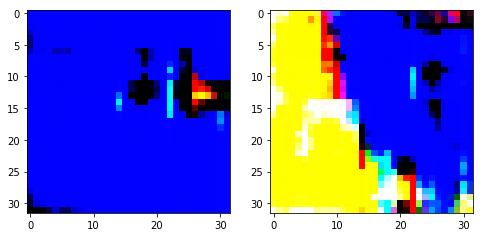

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


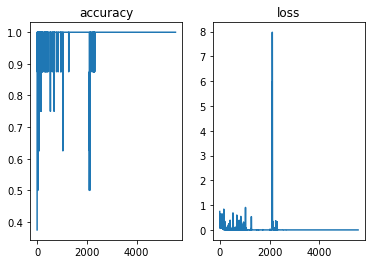

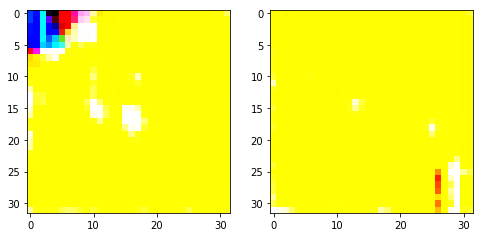

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


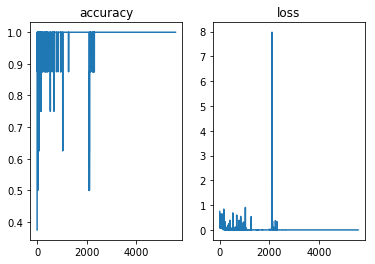

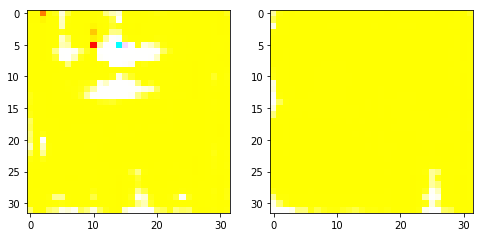

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


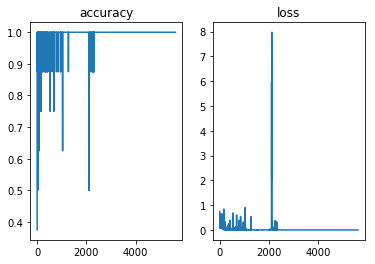

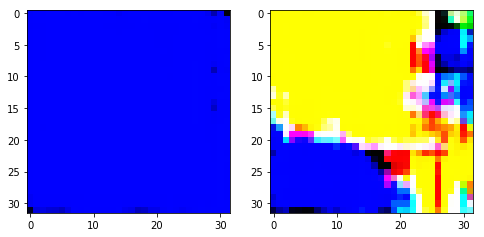

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


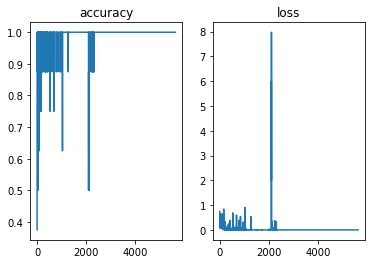

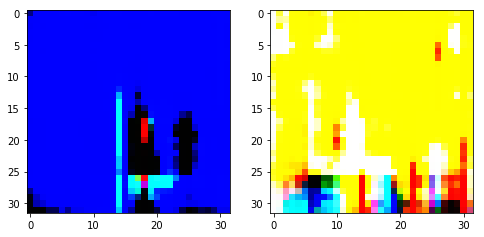

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


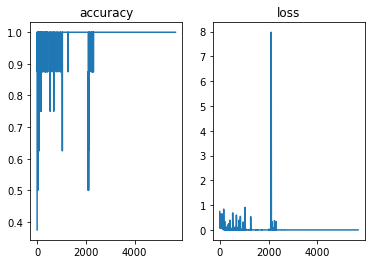

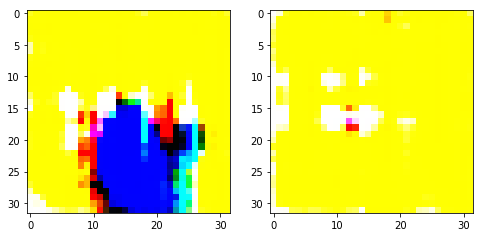

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


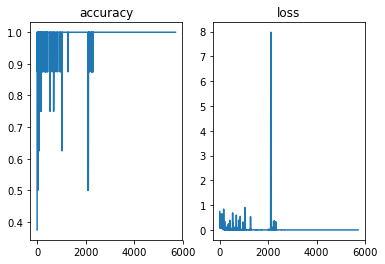

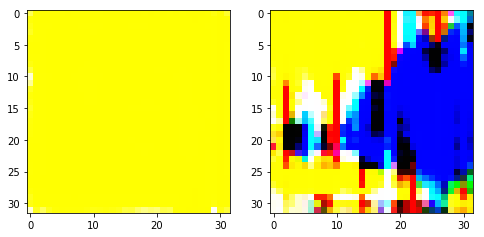

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


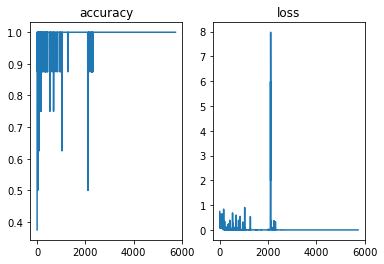

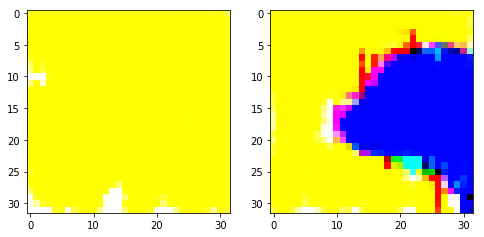

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


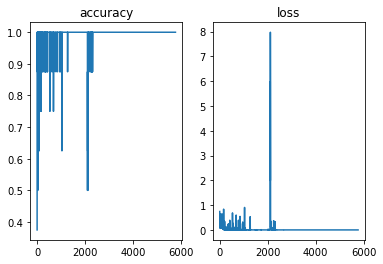

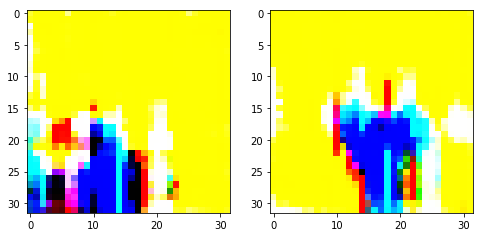

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


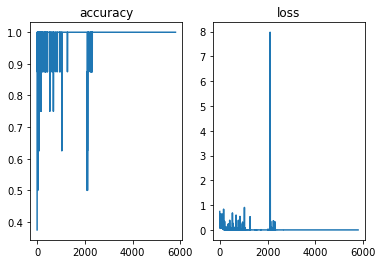

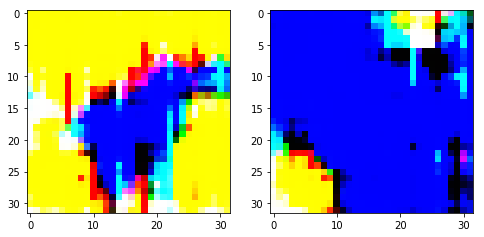

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


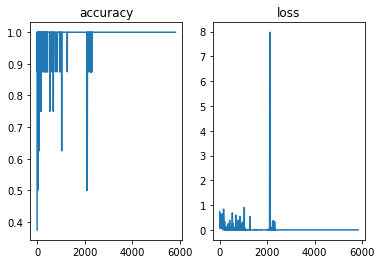

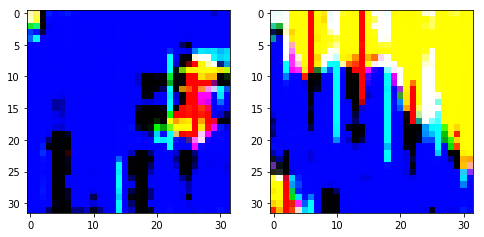

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


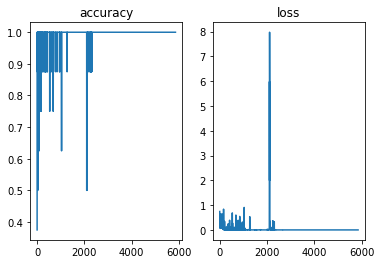

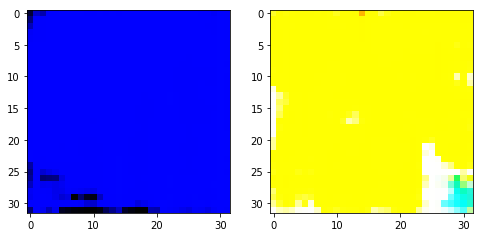

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


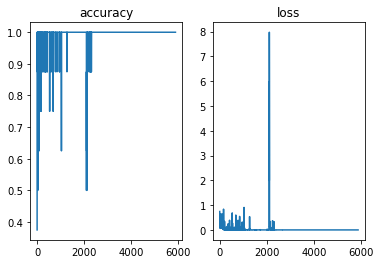

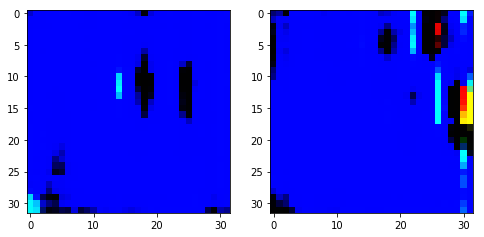

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


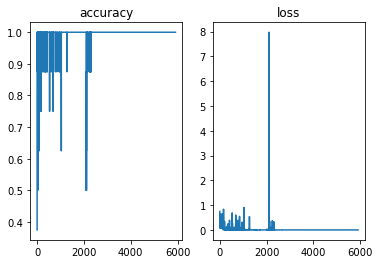

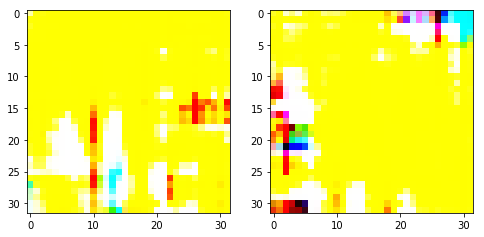

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


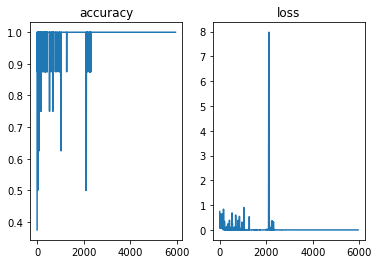

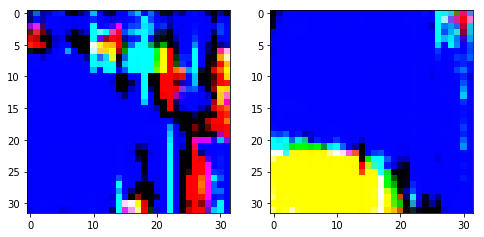

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


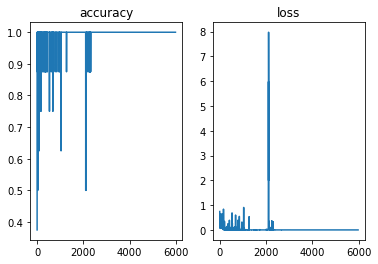

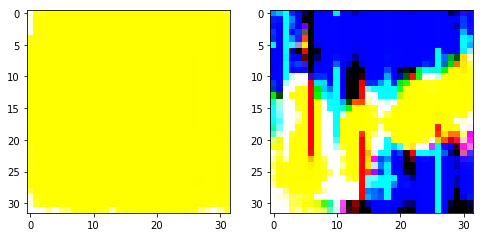

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


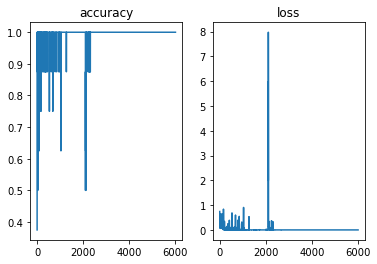

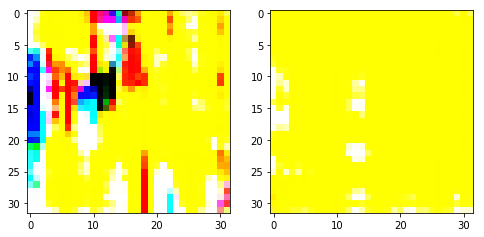

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


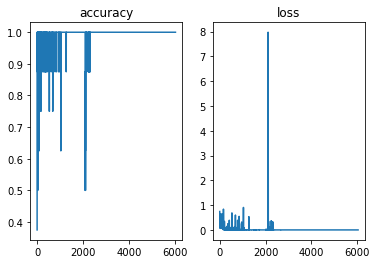

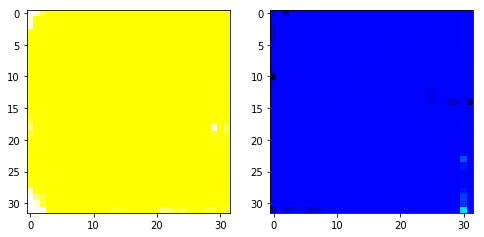

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


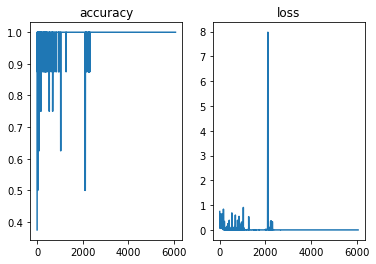

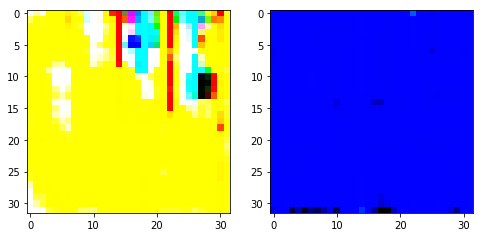

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


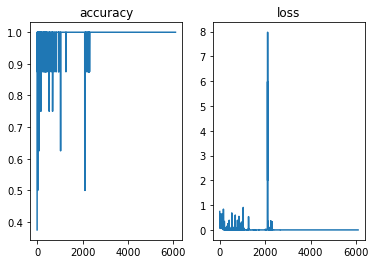

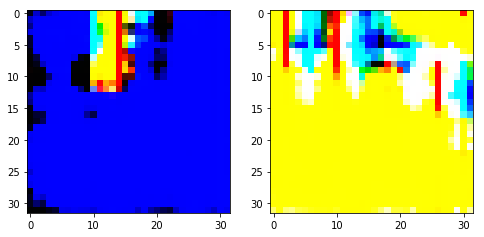

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


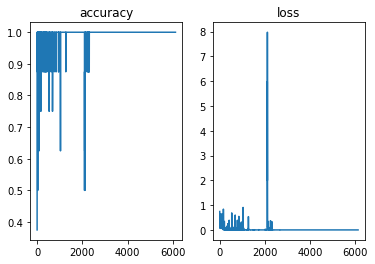

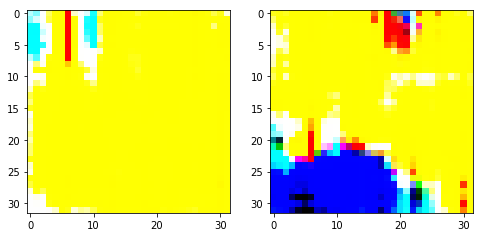

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


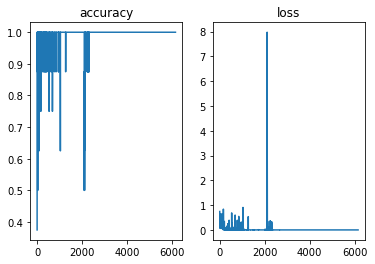

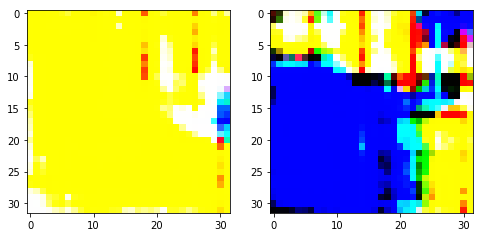

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


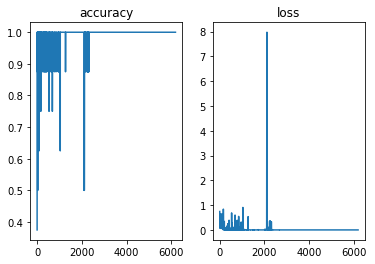

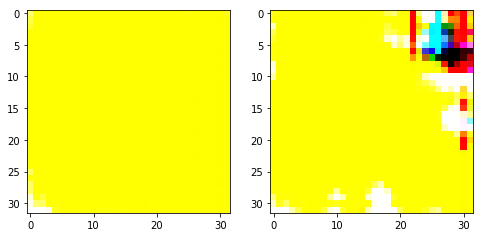

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


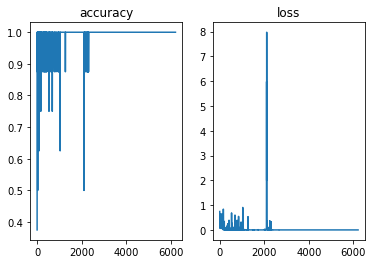

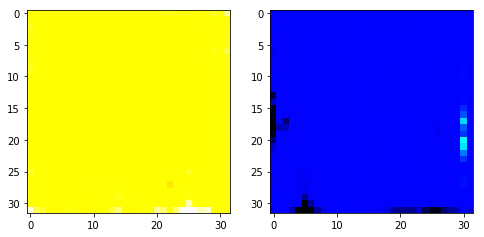

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


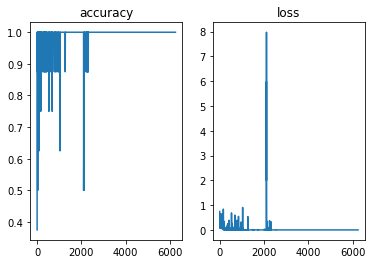

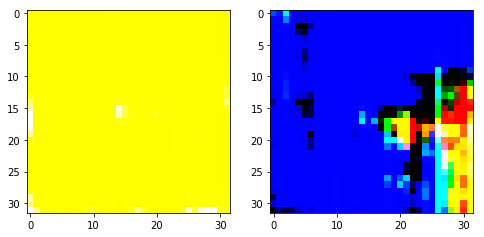

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


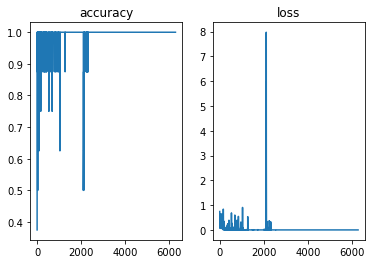

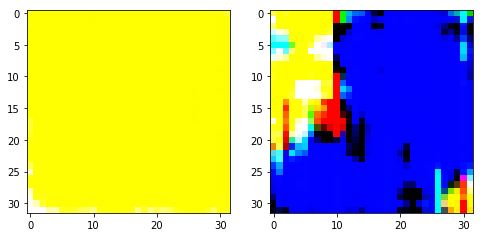

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


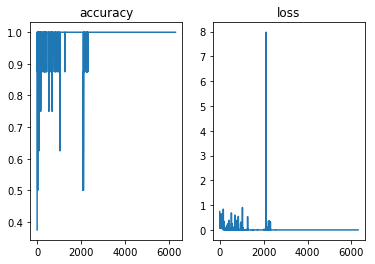

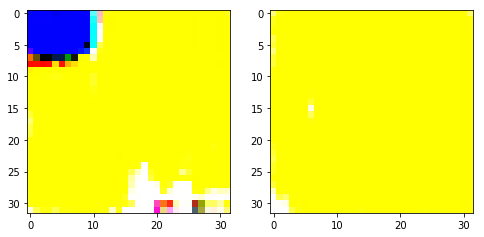

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


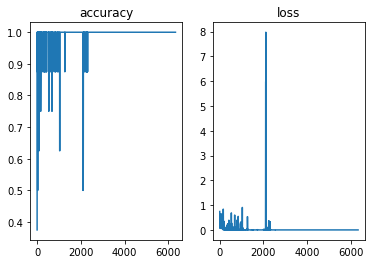

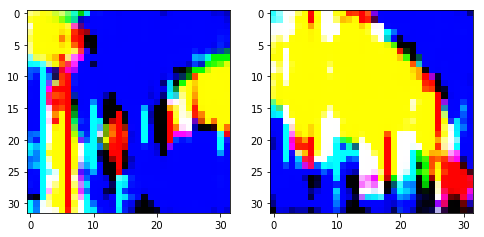

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


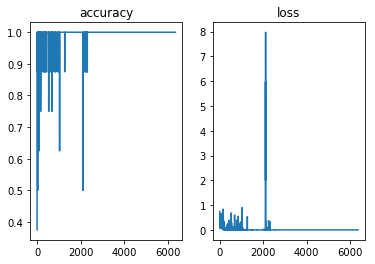

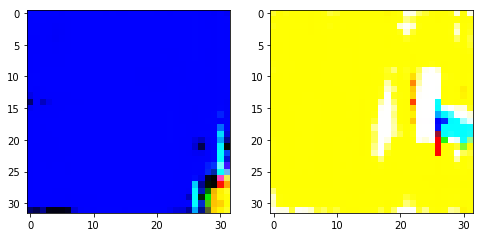

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


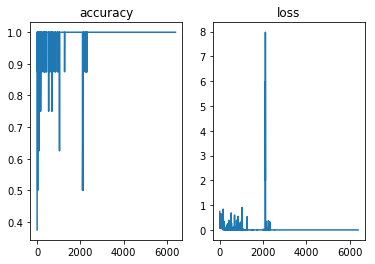

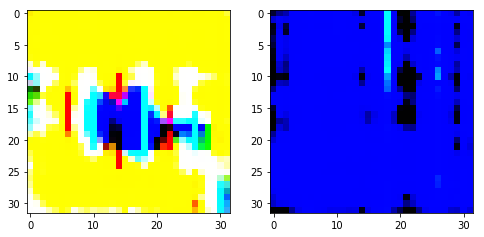

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


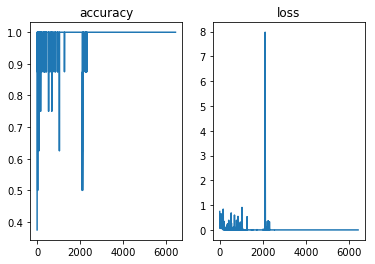

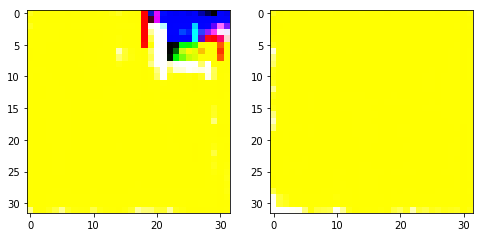

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


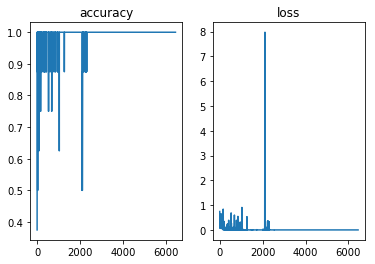

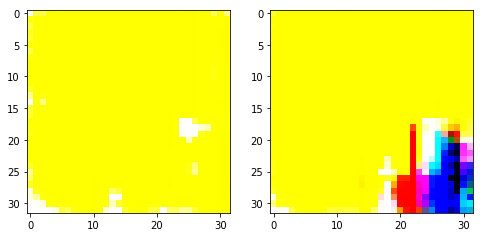

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


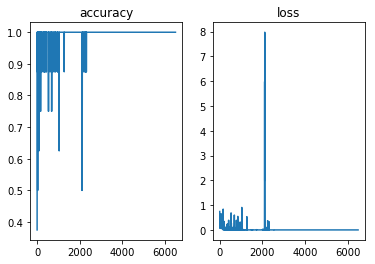

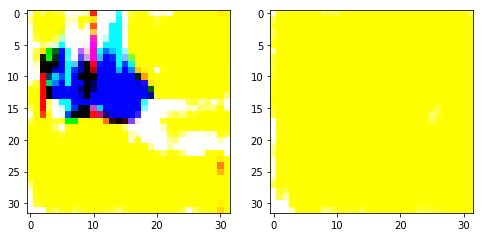

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


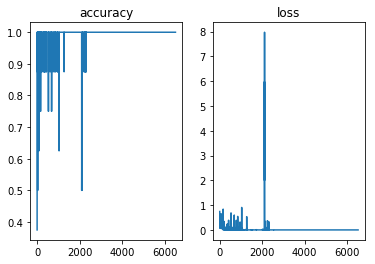

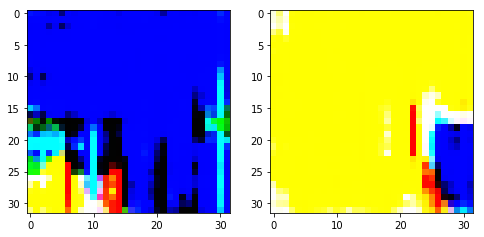

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


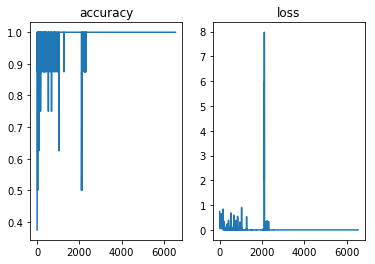

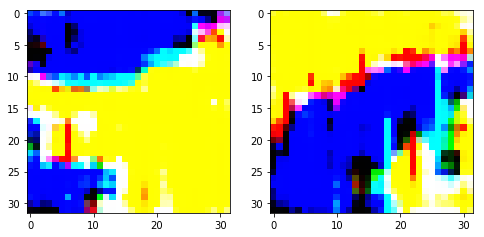

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


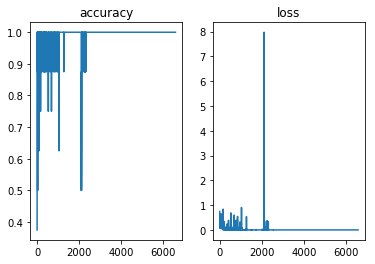

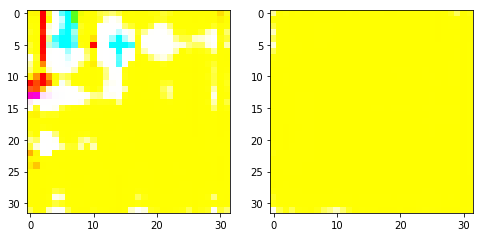

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


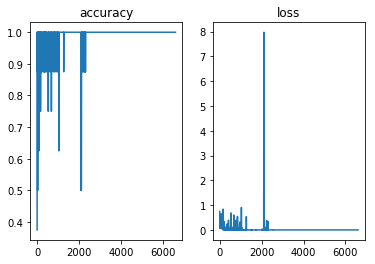

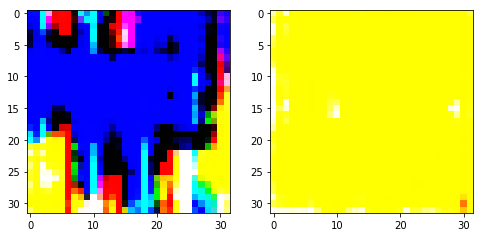

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


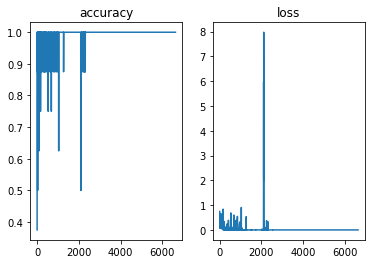

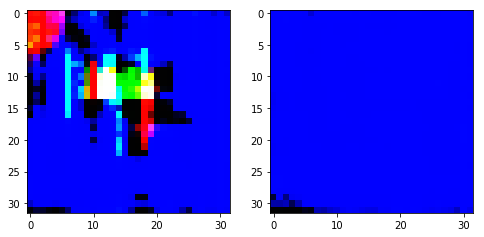

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


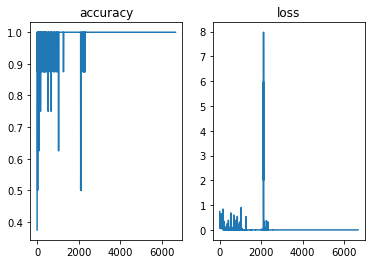

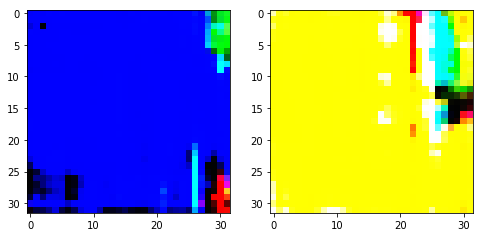

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


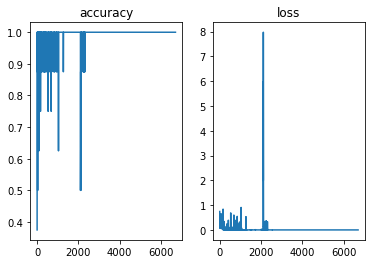

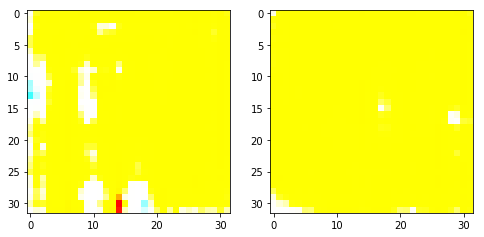

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


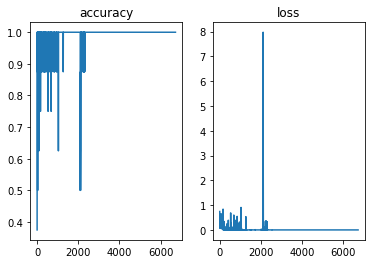

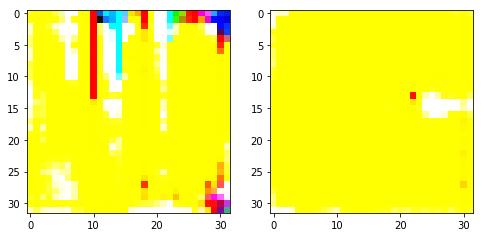

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


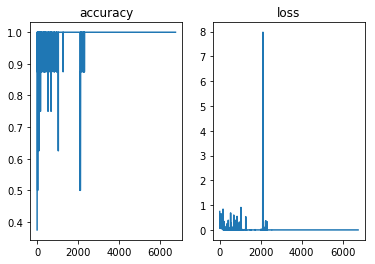

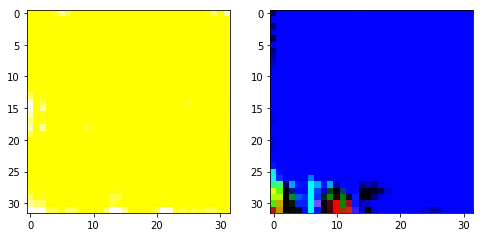

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


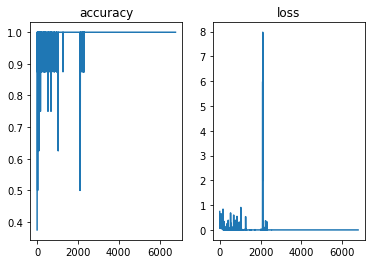

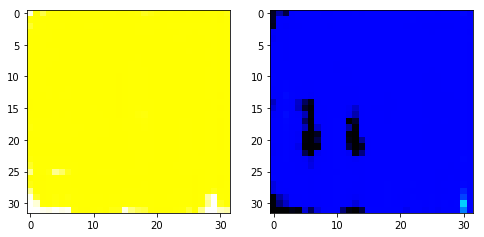

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


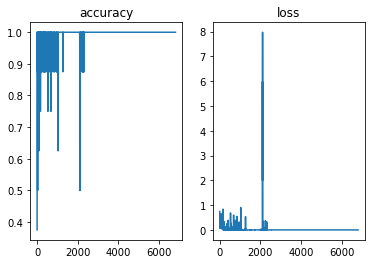

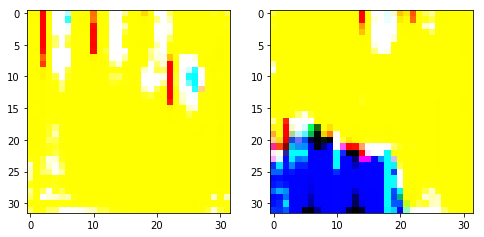

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


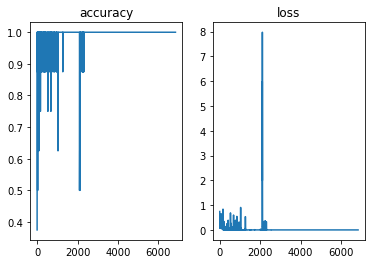

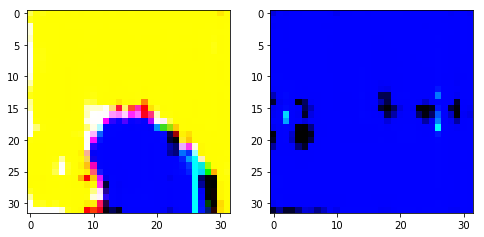

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


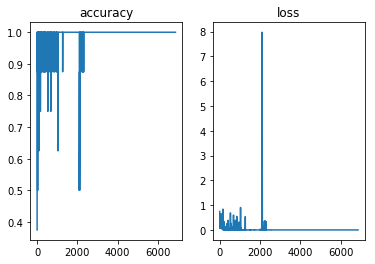

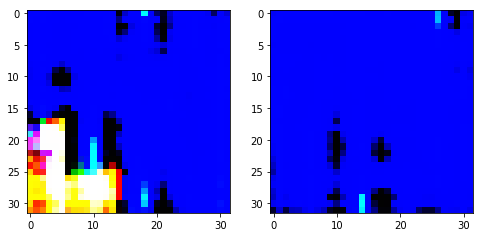

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


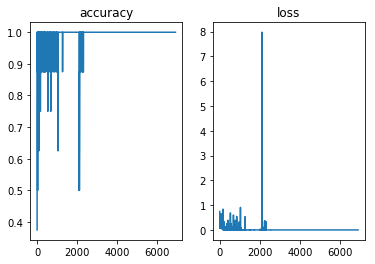

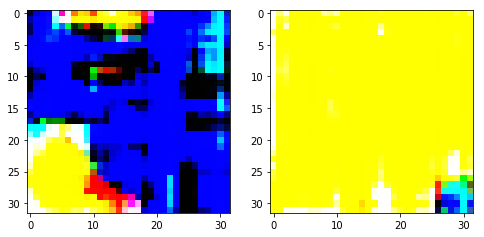

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


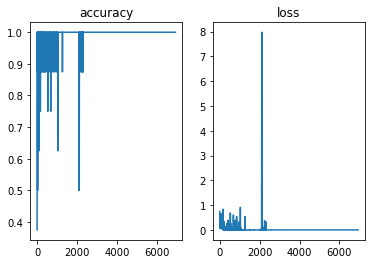

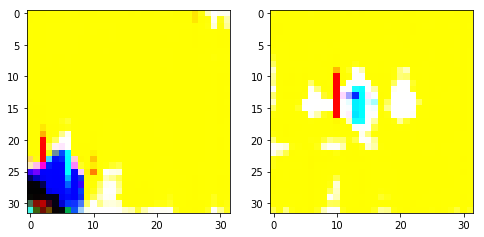

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


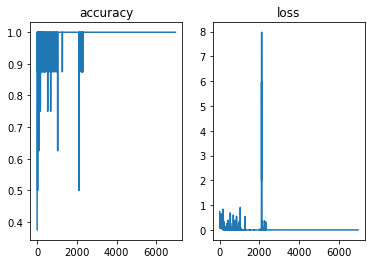

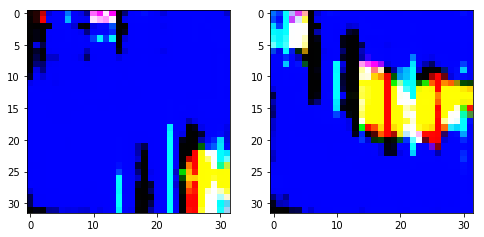

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


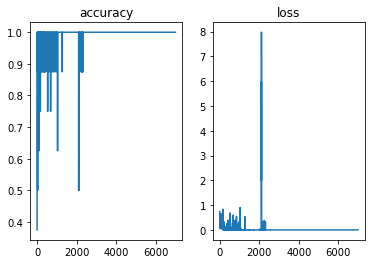

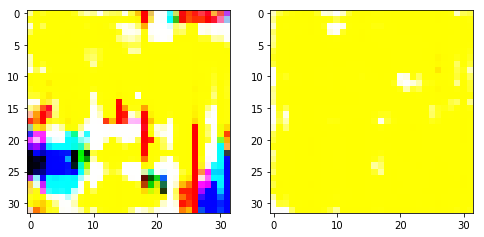

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


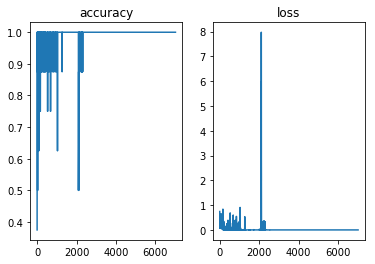

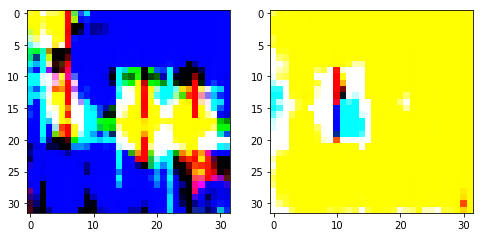

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


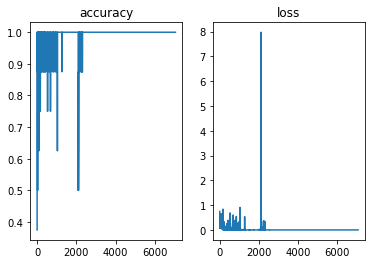

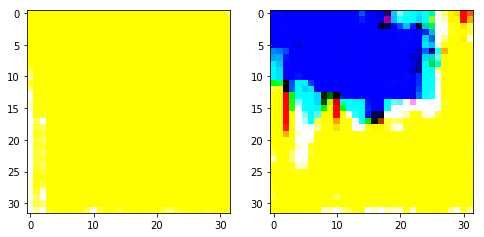

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


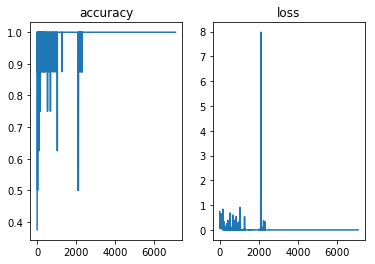

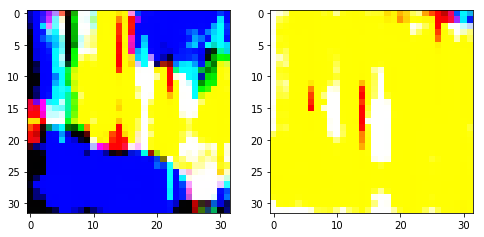

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


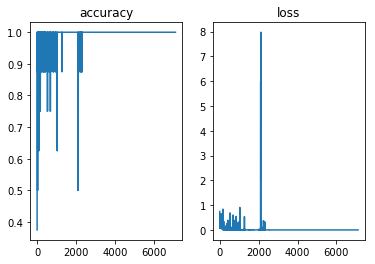

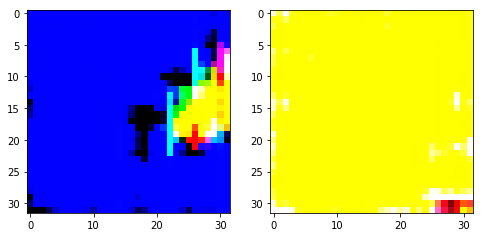

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


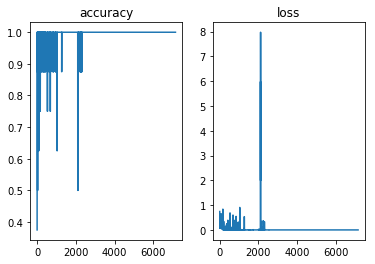

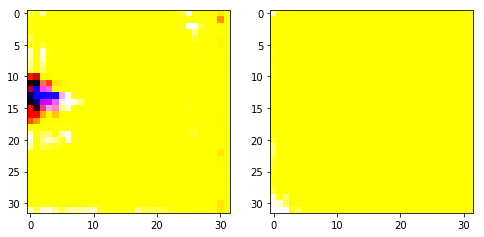

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


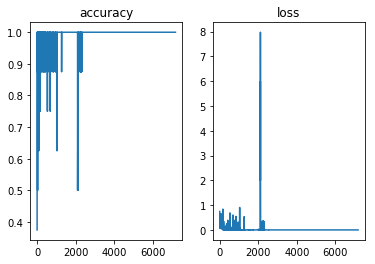

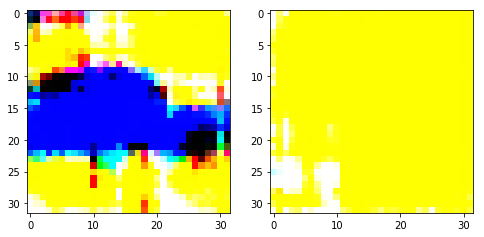

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


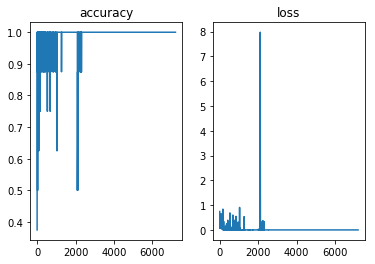

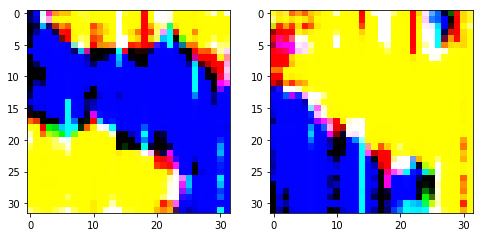

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


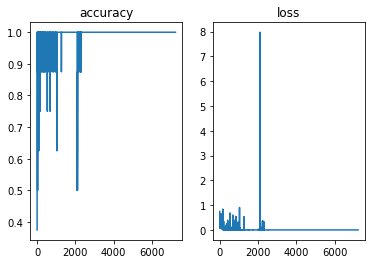

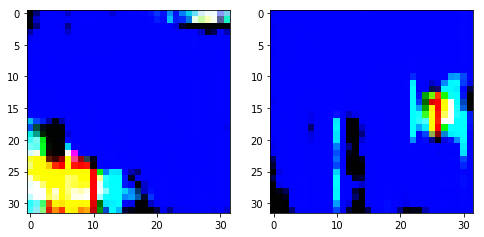

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


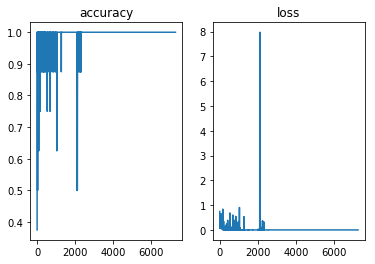

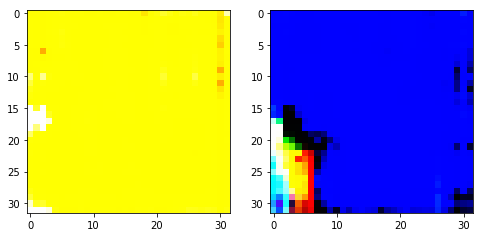

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


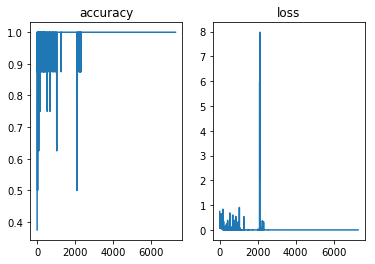

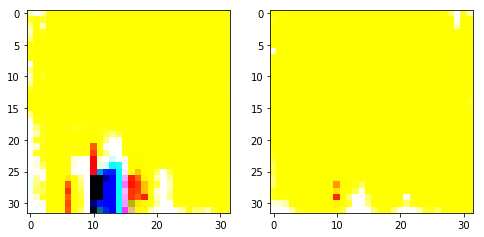

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


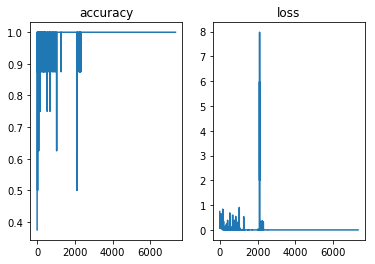

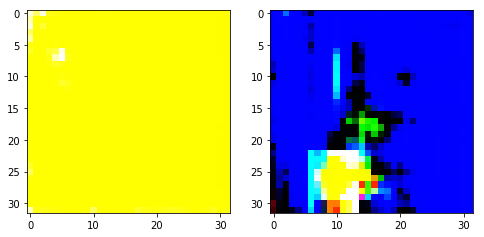

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


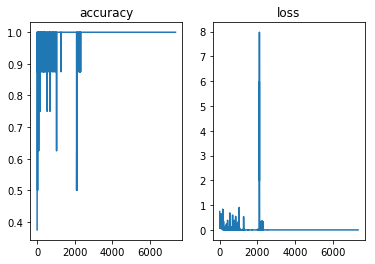

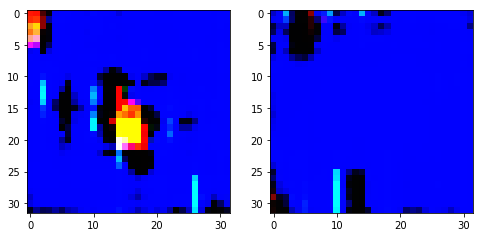

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


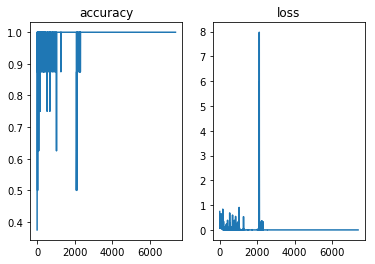

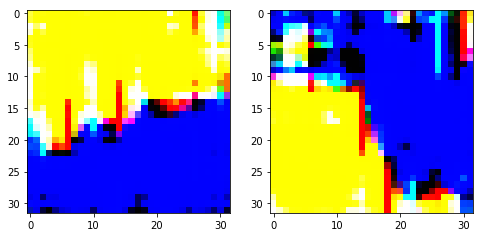

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


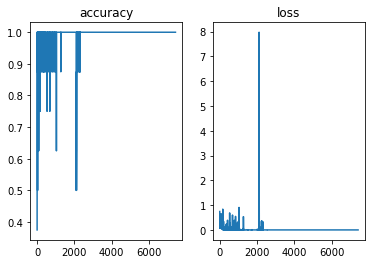

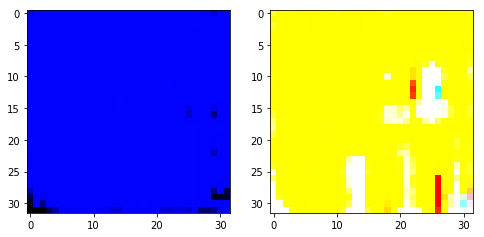

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


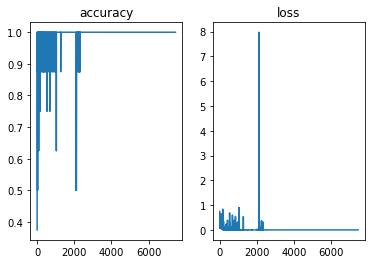

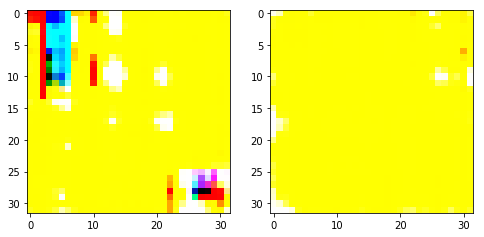

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


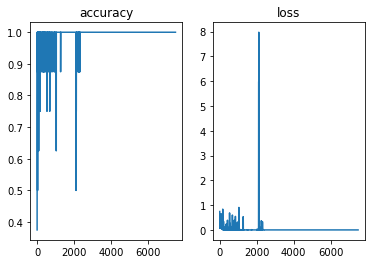

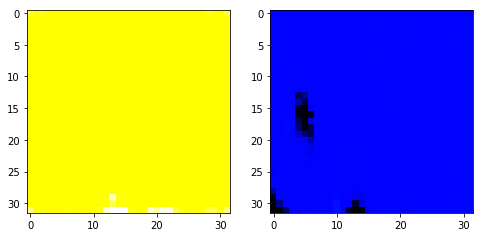

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


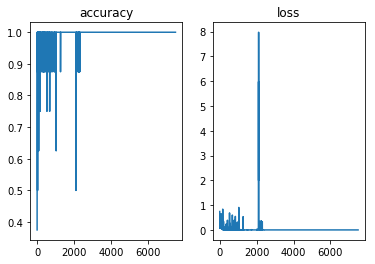

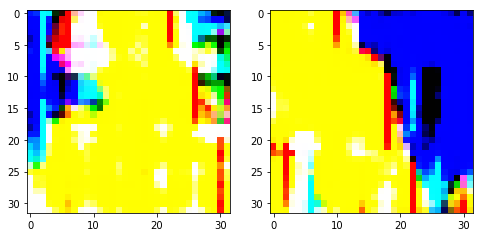

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


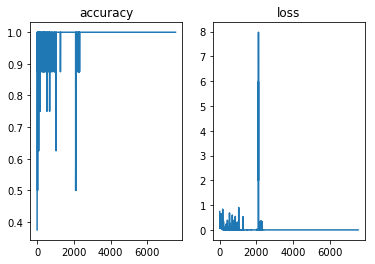

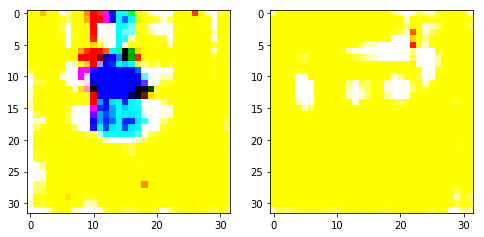

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


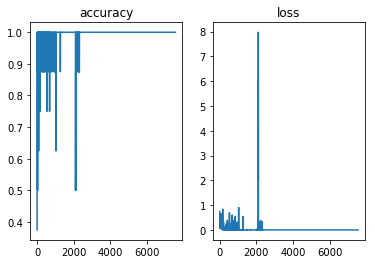

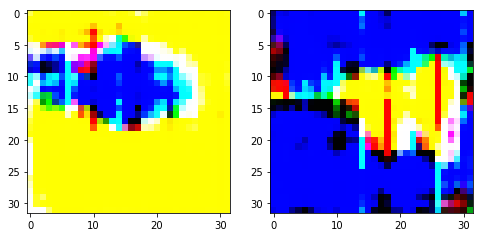

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


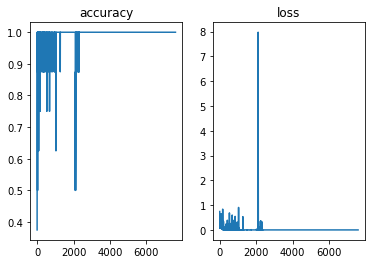

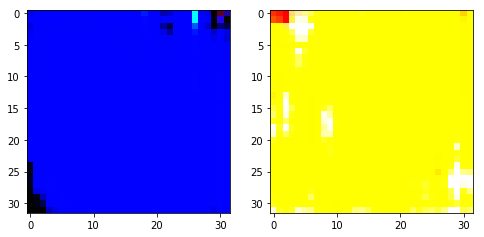

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


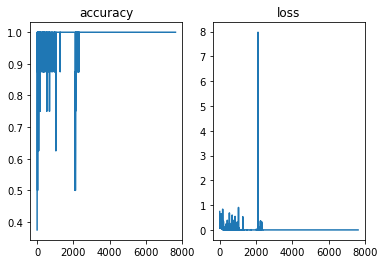

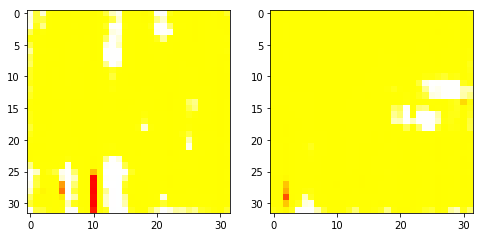

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


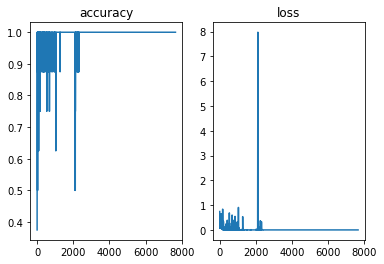

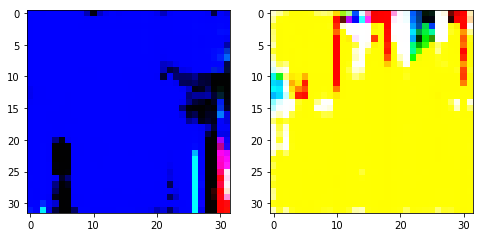

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


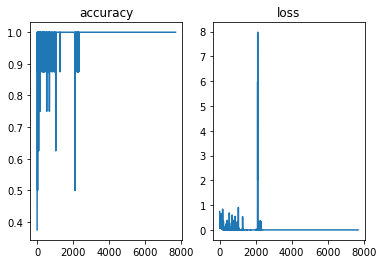

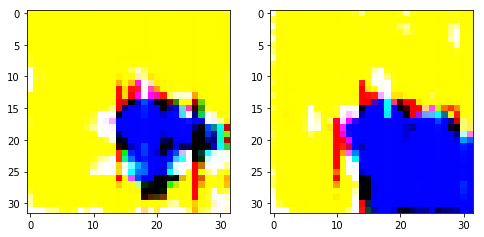

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


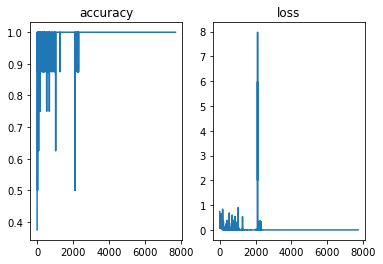

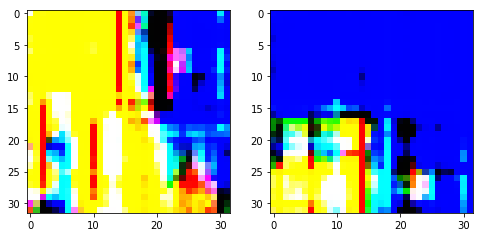

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


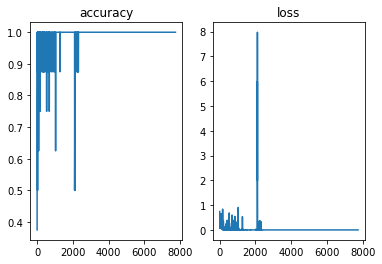

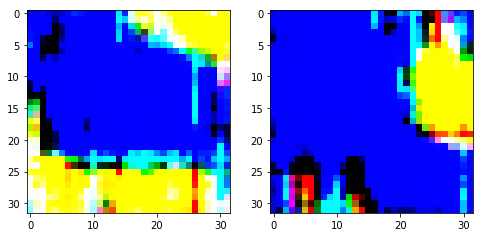

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


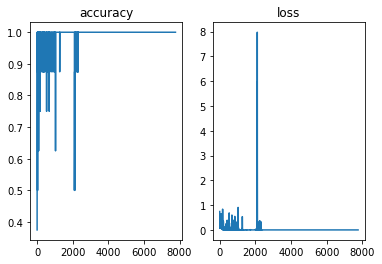

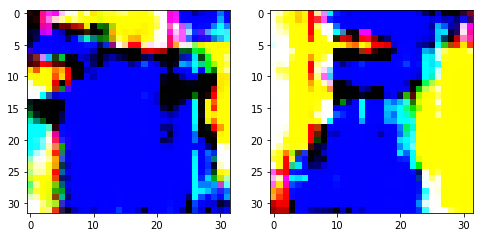

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


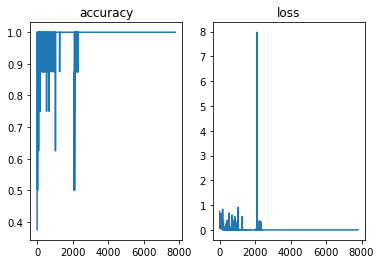

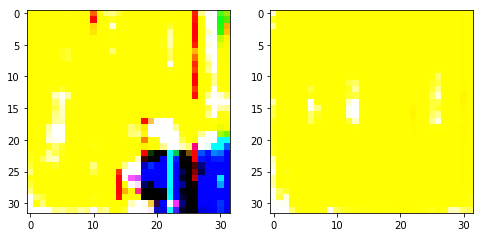

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


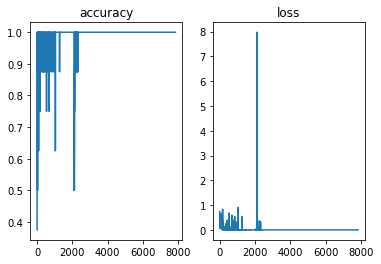

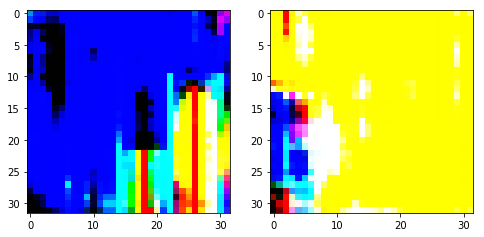

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


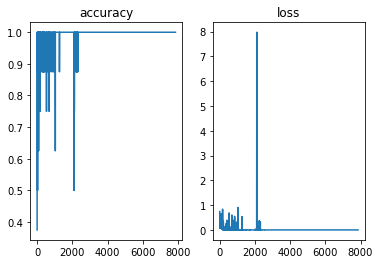

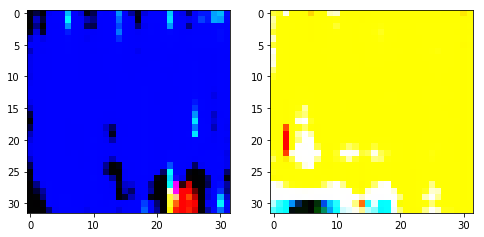

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


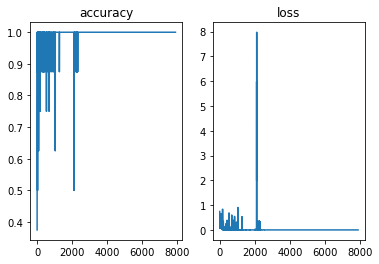

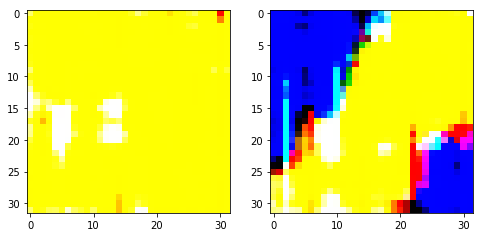

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


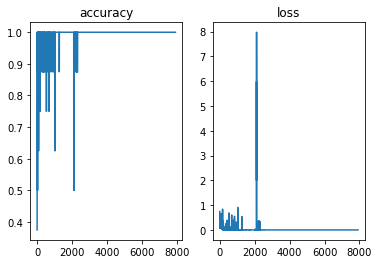

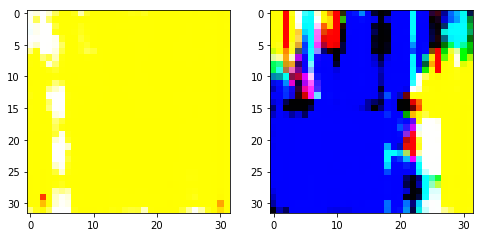

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


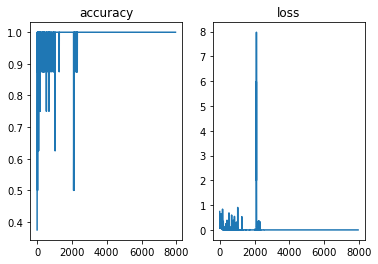

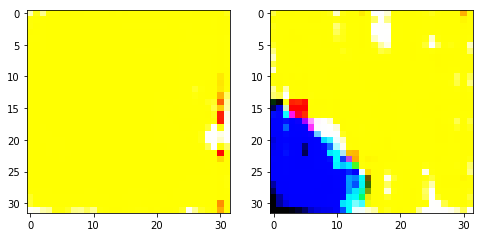

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


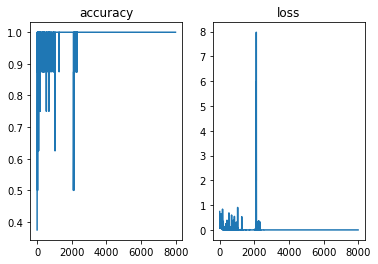

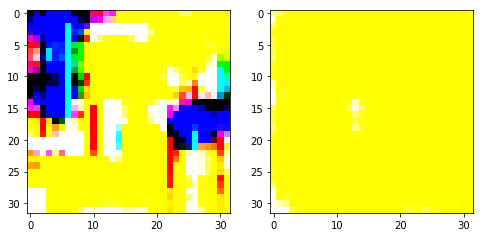

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


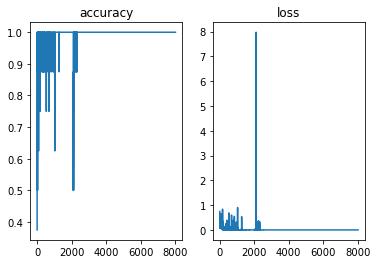

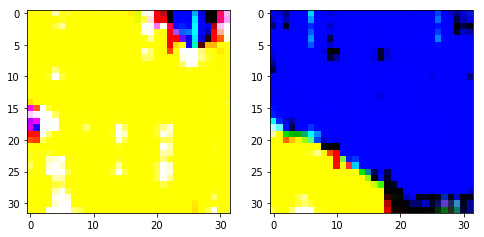

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


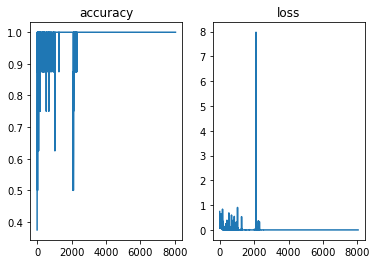

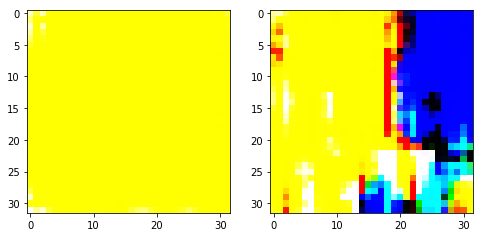

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


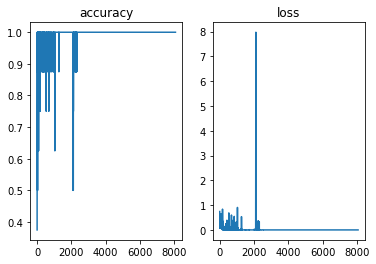

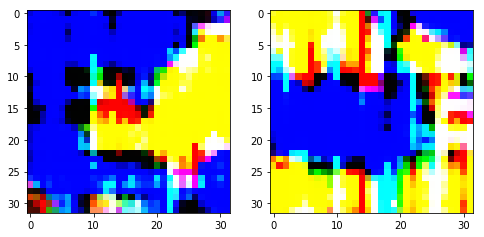

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


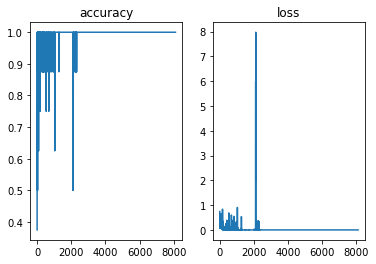

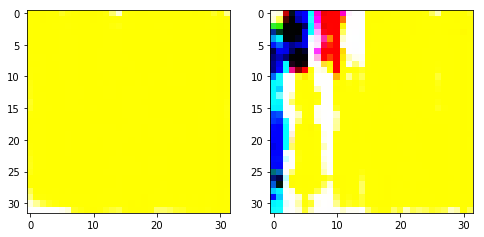

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


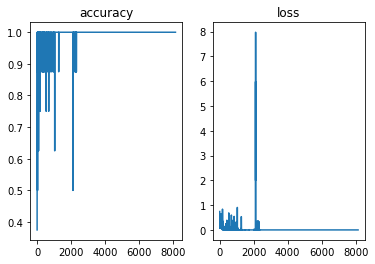

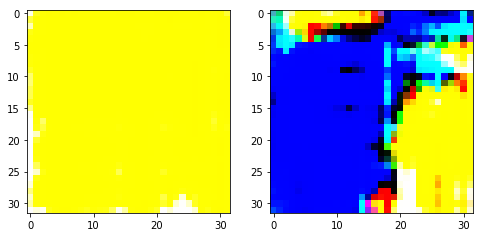

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


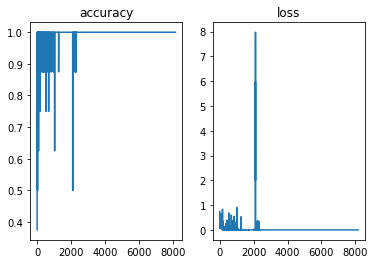

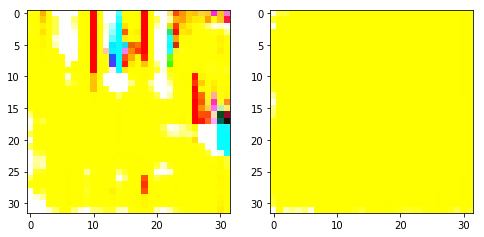

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


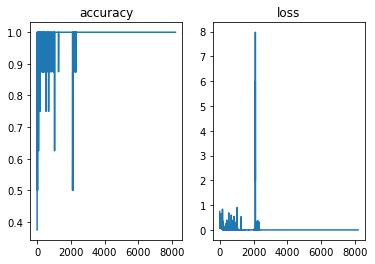

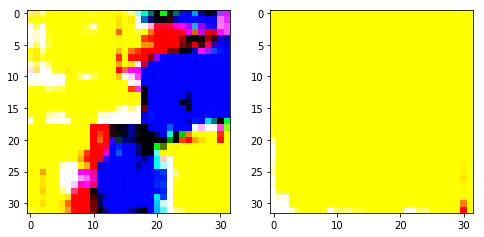

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


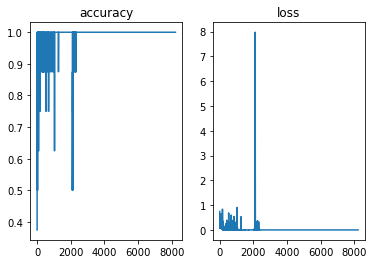

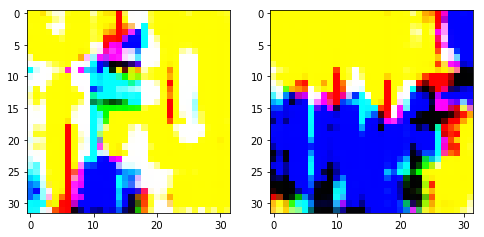

g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181
g_loss :  16.1181


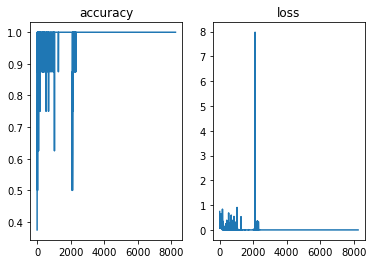

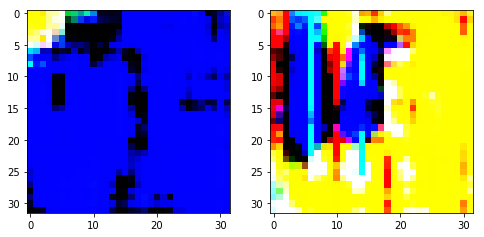

In [ ]:
# %matplotlib notebook
%matplotlib inline

epochs = 20000
batch_size = 8
save_interval= 10
half_batch = int(batch_size / 2)

z = Input(shape=(100,))
acc = []
loss = []

img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
# combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
combined.compile(loss='binary_crossentropy', optimizer='nadam')

for epoch in range(epochs):
    d_input, d_output = getData(half_batch)
    discriminator.trainable = True
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.6,
              patience=10, min_lr=0.001)
    #myPlot
    h = discriminator.fit(d_input, d_output, epochs = 3, verbose=0, callbacks=[reduce_lr])
    acc.extend(h.history.get('acc'))
    loss.extend(h.history.get('loss'))
#     print('history : ', h.history)

    
    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)
    print('g_loss : ', g_loss)
    
    if epoch % save_interval == 0:
        plt.figure(accuracyFig.number)
        plt.subplot(1,2,1)
        plt.plot(acc, label="accuracy")
        plt.title('accuracy')
        plt.subplot(1,2,2)
        plt.title('loss')
        plt.plot(loss, label="loss")
        accuracyFig.canvas.draw()
#         plt.show()
        save_imgs(epoch)